### Capstone Function Optimisation

There are comments below, but the main description of the techniques is in the accompanying README file.

To run analysis on a given Capstone function, the key function is:

**run_func(func_num, use_features=True, input_dir="Functions/Source_Data", output_dir="Functions/Visualisations")**

where
- **func_num** is the desired Capstone function number (1 to 8)
- **use_features** controls whether to turn on feature engineering (True/False)
- **input_dir** specifies where to find the source data, which should be in files **function_n_inputs.npy** and **function_n_outputs.npy** (where n is func_num)
- **output_dir** specifies where to put the visualisations, which can most easily be accessed through the **index.html** file generated; a subdirectory will be created for each run

At a high level, the approach is as follows:
- Load input & output data for the relevant Capstone function
- Apply a shift to the output if necessary (so that transforms such as logs can be applied later)
- Initialise a Bayesian Optimiser class with the data
- Optionally, include feature engineering, i.e. pre-processing to add new feature dimensions which are bespoke functions of the inputs
- Fit a Gaussian Process (GP) with a variety of kernels, with and without log-transforming the outputs and with and without warping; use cross-validation to assess the fit and choose the best kernel
- Fit a BoTorch model to the same data
- Apply a variety of techniques to find the best candidate input to try next, including Expected Improvement (EI), Upper Confidene Bound (UCB) & Potential Improvement (PI) with both the GP model and the BoTorch model (the latter with and without feature engineering), but also various Monte-Carlo methods, Knowledge Gradient, Maximum Entropy Search, Thompson Sampling, Bootstrapping and Cross-Validation
- Compare the candidates in terms of predicted mean and EI
- Produce a range of visualisations to help choose the best candidate, including Parallel Coordinates (which helps identify patterns of promising inputs across multiple dimensions); the Prediction Surface (showing the predicted mean and uncertainty); the Acquisition Landscape of some of the standard acquisition functions; Dimensional Importance (including the feature dimensions, if used); Partial Dependence plots (showing fit vs observations for each dimension separately); Expected Improvement Landscapes (for various combinations of dimensions); Decision Boundary plots (for various combinations of dimensions and percentiles); various Dimensional Reduction Projections to analyse clustering (t-SNE, UMAP and MDS); SHAP analysis (showing the effect of each input dimension separately); a Dimension Interaction Heatmap; and some plots showing Model Fits
- Apply human judgement to choose the best candidate, bearing in mind the expected mean and EI but also the knowledge gained from the visualisations, including the position of the various candidates in the input space.

The Bayesian Optimiser class also contains functionality which was not used in the final analysis:
- Deep Kernels: these were expensive to fit and performed worse than standard or warped kernels so were disabled
- Historical Optimisation Analysis: this was designed to track the performance of the various techniques, saving and loading state each week and feeding the information into the decision for the next candidate, but this did not prove particularly helpful
- Reverse Engineering History: this was designed to look back at the data as it was at each decision point in the past and to reverse engineer which type of acquisition function must have been used to choose the next candidate; the idea was to fill in the "gaps" in memory as the historical optimisation analysis was only implemented some time after the start of the project

In [1]:
# Imports
# - include standard libraries such as numpy and pandas
# - include Bayesian Optimisation libraries such as BoTorch and scikit-learn
# - include visualisation libraries such as matplotlib and plotly

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import seaborn as sns
import pickle
import os
import shap
import umap
import torch
import torch.nn as nn
import time
import warnings
warnings.filterwarnings('ignore')

from abc import ABC, abstractmethod
from tqdm.notebook import tqdm
from copy import deepcopy
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, ConstantKernel, WhiteKernel, RationalQuadratic, ExpSineSquared, DotProduct
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, cross_val_score
#from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.inspection import partial_dependence
from sklearn.manifold import TSNE, MDS
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from scipy.stats import norm
from scipy.optimize import minimize, fmin_l_bfgs_b
from scipy.interpolate import griddata

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from torch.autograd import Function
from torch import Tensor

import gpytorch
from gpytorch.constraints import Positive
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import Kernel, MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.models import ExactGP
from gpytorch.mlls import ExactMarginalLogLikelihood

from botorch.acquisition import ExpectedImprovement, LogExpectedImprovement, UpperConfidenceBound, ProbabilityOfImprovement
from botorch.acquisition import qExpectedImprovement, qLogExpectedImprovement, qLogNoisyExpectedImprovement, qKnowledgeGradient, qMaxValueEntropy
from botorch.acquisition import MCAcquisitionFunction
from botorch.acquisition.acquisition import AcquisitionFunction
from botorch.acquisition.objective import MCAcquisitionObjective
from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.models.gpytorch import GPyTorchModel
from botorch.models.transforms.input import InputTransform
from botorch.optim import optimize_acqf
from botorch.posteriors.gpytorch import GPyTorchPosterior
from botorch.sampling import SobolQMCNormalSampler

The following section implements feature engineering for the specific Imperial ML/AI Capstone Competition functions, to keep this separate from the general Bayesian Optimisation class.

In [2]:
class FeatureTransformer(ABC):
    """Abstract base class for feature transformers."""
    
    @abstractmethod
    def transform(self, X):
        """Transform input features X."""
        pass

class IdentityTransformer(FeatureTransformer):
    """Default transformer that returns original features."""
    
    def transform(self, X):
        return X

class Function2Transformer(FeatureTransformer):
    """Feature transformer for function 2."""
    
    def transform(self, X):
        features = [X]
        
        # Feature 1: Distance from optimal x0 region
        x0_optimal = 0.72
        x0_penalty = np.square(X[:, 0] - x0_optimal).reshape(-1, 1)
        features.append(x0_penalty)
        
        # Feature 2: Multi-modal x1 activation
        x1_mode1 = np.exp(-50 * np.square(X[:, 1] - 0.0)).reshape(-1, 1)
        x1_mode2 = np.exp(-50 * np.square(X[:, 1] - 0.4)).reshape(-1, 1)
        x1_mode3 = np.exp(-25 * np.square(X[:, 1] - 0.95)).reshape(-1, 1)
        x1_multimodal = np.maximum(np.maximum(x1_mode1, x1_mode2), x1_mode3)
        features.append(x1_multimodal)
        
        # Feature 3: Interaction term
        x0_good = np.exp(-25 * np.square(X[:, 0] - 0.72))
        interaction = (x0_good * x1_multimodal.flatten()).reshape(-1, 1)
        features.append(interaction)
        
        # Feature 4: RBF around best known point
        best_point = np.array([0.723, 0.438])
        distances_to_best = np.sqrt(np.sum(np.square(X - best_point), axis=1))
        rbf_best = np.exp(-10 * np.square(distances_to_best)).reshape(-1, 1)
        features.append(rbf_best)
        
        return np.hstack(features)

class Function3Transformer(FeatureTransformer):
    """Feature transformer for function 3."""
    
    def transform(self, X):
        features = [X]
        optimal_point = np.array([0.407, 0.574, 0.428])
        
        # Feature 1: Tight Gaussian around optimum
        sigma = 0.05
        gaussian_tight = np.exp(-np.sum(np.square(X - optimal_point), axis=1) / 
                               (2 * sigma**2)).reshape(-1, 1)
        features.append(gaussian_tight)
        
        # Feature 2: X2 sweet spot penalty
        x2_optimal = 0.428
        x2_tolerance = 0.02
        x2_penalty = np.maximum(0, np.abs(X[:, 2] - x2_optimal) - x2_tolerance).reshape(-1, 1)
        features.append(x2_penalty)
        
        # Feature 3: Ellipsoidal distance
        weights = np.array([1.5, 1., 2.0])
        ellipsoid_dist = np.sqrt(np.sum(
            weights * np.square(X - optimal_point), axis=1
        )).reshape(-1, 1)
        features.append(ellipsoid_dist)
        
        # Feature 4: Binary indicator for proven optimal region
        proven_region = (
            (X[:, 0] >= 0.40) & (X[:, 0] <= 0.53) &
            (X[:, 1] >= 0.51) & (X[:, 1] <= 0.64) &
            (X[:, 2] >= 0.40) & (X[:, 2] <= 0.48)
        ).astype(float).reshape(-1, 1)
        features.append(proven_region)
        
        return np.hstack(features)

class Function4Transformer(FeatureTransformer):
    """Feature transformer for function 4."""
    
    def transform(self, X):
        features = [X]
        optimal_point = np.array([0.420, 0.418, 0.373, 0.413])
        
        # Feature 1: Very tight Gaussian around global optimum
        sigma = 0.04
        gaussian_tight = np.exp(-np.sum(np.square(X - optimal_point), axis=1) / 
                               (2 * sigma**2)).reshape(-1, 1)
        features.append(gaussian_tight)
        
        # Feature 2: Distance to optimal
        dist_to_optimal = np.sqrt(np.sum(np.square(X - optimal_point), axis=1)).reshape(-1, 1)
        features.append(dist_to_optimal)
        
        # Feature 3: Sum penalty (optimal sum around 1.625)
        optimal_sum = 1.625
        sum_penalty = np.abs(np.sum(X, axis=1) - optimal_sum).reshape(-1, 1)
        features.append(sum_penalty)
        
        # Feature 4: Edge penalty
        edge_penalty = np.zeros(X.shape[0])
        for i in range(X.shape[1]):
            edge_penalty += np.maximum(0, 0.35 - X[:, i])**2 + np.maximum(0, X[:, i] - 0.45)**2
        edge_penalty = edge_penalty.reshape(-1, 1)
        features.append(edge_penalty)
        
        # Feature 5: Binary indicator for ultra-tight optimal region
        ultra_tight_region = (
            (np.abs(X[:, 0] - 0.420) < 0.025) &
            (np.abs(X[:, 1] - 0.418) < 0.025) &
            (np.abs(X[:, 2] - 0.373) < 0.025) &
            (np.abs(X[:, 3] - 0.413) < 0.025)
        ).astype(float).reshape(-1, 1)
        features.append(ultra_tight_region)
        
        return np.hstack(features)

class Function5Transformer(FeatureTransformer):
    """Feature transformer for function 5."""
    
    def transform(self, X):
        features = [X]
        
        # Feature 1: Full product (strongest predictor)
        full_product = np.prod(X, axis=1).reshape(-1, 1)
        features.append(full_product)
        
        # Feature 2: Core triple product x1 * x2 * x3
        triple_product = (X[:, 1] * X[:, 2] * X[:, 3]).reshape(-1, 1)
        features.append(triple_product)
        
        # Feature 3: Log of products (helps with extreme scaling)
        epsilon = 1e-8
        log_full_product = np.log(full_product + epsilon)
        features.append(log_full_product)
        
        # Feature 4: "Weak link" penalty - minimum of x1,x2,x3
        weak_link = np.minimum(np.minimum(X[:, 1], X[:, 2]), X[:, 3]).reshape(-1, 1)
        features.append(weak_link)
        
        # Feature 5: High-performance region indicator
        high_region = ((X[:, 1] > 0.8) & (X[:, 2] > 0.8) & (X[:, 3] > 0.8)).astype(float).reshape(-1, 1)
        features.append(high_region)
        
        return np.hstack(features)

class Function6Transformer(FeatureTransformer):
    """Feature transformer for function 6."""
    
    def transform(self, X):
        features = [X]
        optimal_point = np.array([0.463, 0.368, 0.640, 0.727, 0.046])
        
        # Feature 1: Distance to refined optimal point
        dist_to_optimal = np.sqrt(np.sum(np.square(X - optimal_point), axis=1)).reshape(-1, 1)
        features.append(dist_to_optimal)
        
        # Feature 2: X3*(1-X4) interaction
        x3_x4inv = (X[:, 3] * (1 - X[:, 4])).reshape(-1, 1)
        features.append(x3_x4inv)
        
        # Feature 3: X4 "sweet spot" penalty
        x4_optimal = 0.045
        x4_tolerance = 0.015
        x4_penalty = np.maximum(0, np.abs(X[:, 4] - x4_optimal) - x4_tolerance).reshape(-1, 1)
        features.append(x4_penalty)
        
        # Feature 4: X3 "must be high" constraint
        x3_threshold = 0.7
        x3_goodness = np.maximum(0, X[:, 3] - x3_threshold).reshape(-1, 1)
        features.append(x3_goodness)
        
        # Feature 5: Tight Gaussian around refined optimal
        sigma = 0.06
        gaussian_tight = np.exp(-np.sum(np.square(X - optimal_point), axis=1) / 
                               (2 * sigma**2)).reshape(-1, 1)
        features.append(gaussian_tight)
        
        return np.hstack(features)

class Function7Transformer(FeatureTransformer):
    """Feature transformer for function 7."""
    
    def transform(self, X):
        features = [X]
        optimal_point = np.array([0.142, 0.133, 0.447, 0.303, 0.319, 0.698])
        
        # Feature 1: Distance to refined optimal point
        dist_to_optimal = np.sqrt(np.sum(np.square(X - optimal_point), axis=1)).reshape(-1, 1)
        features.append(dist_to_optimal)
        
        # Feature 2: X0 "sweet spot" penalty
        x0_optimal = 0.13
        x0_penalty = np.abs(X[:, 0] - x0_optimal).reshape(-1, 1)
        features.append(x0_penalty)
        
        # Feature 3: Refined X0-X3-X5 interaction
        x0_factor = np.exp(-50 * np.square(X[:, 0] - 0.13))
        x3_factor = np.exp(-100 * np.square(X[:, 3] - 0.303))
        x5_factor = np.exp(-20 * np.square(X[:, 5] - 0.698))
        x0_x3_x5_optimal = (x0_factor * x3_factor * x5_factor).reshape(-1, 1)
        features.append(x0_x3_x5_optimal)
        
        # Feature 4: X4 optimal constraint
        x4_goodness = np.exp(-100 * np.square(X[:, 4] - 0.318)).reshape(-1, 1)
        features.append(x4_goodness)
        
        # Feature 5: Tight Gaussian around refined optimal
        sigma = 0.06
        gaussian_tight = np.exp(-np.sum(np.square(X - optimal_point), axis=1) / 
                               (2 * sigma**2)).reshape(-1, 1)
        features.append(gaussian_tight)
        
        return np.hstack(features)

class Function8Transformer(FeatureTransformer):
    """Feature transformer for function 8."""
    
    def transform(self, X):
        features = [X]
        optimal_point = np.array([0.130, 0.167, 0.146, 0.169, 0.815, 0.487, 0.209, 0.606])
        
        # Feature 1: Distance to refined optimal point
        dist_to_optimal = np.sqrt(np.sum(np.square(X - optimal_point), axis=1)).reshape(-1, 1)
        features.append(dist_to_optimal)
        
        # Feature 2: Refined key indicator
        refined_key_indicator = ((X[:, 0] < 0.19) &
                                (X[:, 4] > 0.70) &
                                (X[:, 5] > 0.43) &
                                (X[:, 5] < 0.59)).astype(float).reshape(-1, 1)
        features.append(refined_key_indicator)
        
        # Feature 3: X4-X0 difference
        x4_minus_x0 = (X[:, 4] - X[:, 0]).reshape(-1, 1)
        features.append(x4_minus_x0)
        
        # Feature 4: X4-X0 "sweet spot" indicator
        x4x0_good = ((X[:, 4] - X[:, 0]) >= 0.55) & ((X[:, 4] - X[:, 0]) <= 0.86)
        x4x0_indicator = x4x0_good.astype(float).reshape(-1, 1)
        features.append(x4x0_indicator)
        
        # Feature 5: Tight Gaussian around optimal
        sigma = 0.05
        gaussian_tight = np.exp(-np.sum(np.square(X - optimal_point), axis=1) / 
                               (2 * sigma**2)).reshape(-1, 1)
        features.append(gaussian_tight)
        
        return np.hstack(features)

# Factory for creating transformers
class TransformerFactory:
    """Factory for creating feature transformers."""
    
    _transformers = {
        1: IdentityTransformer,
        2: Function2Transformer,
        3: Function3Transformer,
        4: Function4Transformer,
        5: Function5Transformer,
        6: Function6Transformer,
        7: Function7Transformer,
        8: Function8Transformer,
    }
    
    @classmethod
    def create_transformer(cls, func_num):
        """Create appropriate transformer for function number."""
        transformer_class = cls._transformers.get(func_num, IdentityTransformer)
        return transformer_class()
    
    @classmethod
    def register_transformer(cls, func_num, transformer_class):
        """Register a new transformer for a function number."""
        cls._transformers[func_num] = transformer_class

The following sections set up some classes and helper functions to implement warped kernels and deep kernels, for later use.

In [3]:
# Assorted classes and functions to implement warped kernels

class WarpedGP(ExactGP, GPyTorchModel):
    """Gaussian Process with input warping for non-stationary functions."""
    
    _num_outputs = 1  # Single output for standard GP
    
    def __init__(
        self, 
        train_X, 
        train_Y, 
        likelihood=None,
        kernel_type="matern",
        nu=2.5,
        ard=True,
        warp_type="kumaraswamy",
        min_noise=1e-4
    ):
        # Initialize likelihood if not provided
        if likelihood is None:
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
            
        # Add minimum noise constraint for numerical stability
        likelihood.noise_covar.register_constraint(
            "raw_noise", 
            gpytorch.constraints.GreaterThan(min_noise)
        )
        
        # Flatten train_Y if needed to avoid shape issues
        if train_Y.ndim > 1 and train_Y.shape[1] == 1:
            train_Y = train_Y.squeeze(-1)
            
        # Initialize the ExactGP parent class
        super(WarpedGP, self).__init__(train_X, train_Y, likelihood)
        
        # BoTorch compatibility attributes
        self.train_inputs = (train_X,)
        self.train_targets = train_Y
        self._input_batch_shape = train_X.shape[:-1]
        self._aug_batch_shape = self._input_batch_shape
        
        # Input warping transform
        self.input_dim = train_X.shape[-1]
        self.warp_transform = WarpedInputTransform(self.input_dim, warp_type)
        
        # Mean and covariance modules
        self.mean_module = gpytorch.means.ConstantMean()
        
        # Set up kernel
        if kernel_type == "matern":
            base_kernel = gpytorch.kernels.MaternKernel(
                nu=nu, ard_num_dims=self.input_dim if ard else None
            )
        elif kernel_type == "rbf":
            base_kernel = gpytorch.kernels.RBFKernel(
                ard_num_dims=self.input_dim if ard else None
            )
        elif kernel_type == "rational_quadratic":
            base_kernel = gpytorch.kernels.RQKernel(
                ard_num_dims=self.input_dim if ard else None
            )
        else:
            raise ValueError(f"Unknown kernel type: {kernel_type}")
        
        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)
        
        # Initialize parameters to reasonable values
        self._initialize_parameters()
    
    def _initialize_parameters(self):
        """Initialize model parameters to reasonable values."""
        # Initialize warping parameters to small values to prevent extreme warping initially
        if hasattr(self.warp_transform, 'warp_params'):
            self.warp_transform.warp_params.data.fill_(0.5)
            # Add small noise to break symmetry
            self.warp_transform.warp_params.data += torch.randn_like(self.warp_transform.warp_params.data) * 0.1
        
        # Initialize kernel parameters
        if hasattr(self.covar_module, 'outputscale'):
            self.covar_module.outputscale = torch.tensor(1.0)
        
        if hasattr(self.covar_module.base_kernel, 'lengthscale'):
            self.covar_module.base_kernel.lengthscale = torch.tensor(0.5)
    
    def forward(self, x):
        """Forward pass with input warping."""
        # Apply input warping
        x_warped = self.warp_transform.transform(x)
        
        # Pass through GP
        mean_x = self.mean_module(x_warped)
        covar_x = self.covar_module(x_warped)
        
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

class WarpedInputTransform(InputTransform):
    """Input warping transformation using parameterized functions."""
    
    def __init__(self, input_dim, warp_type="kumaraswamy"):
        """
        Initialize input warping transform.
        
        Args:
            input_dim: Number of input dimensions
            warp_type: Type of warping function to use
        """
        super().__init__()
        self.input_dim = input_dim
        self.warp_type = warp_type
        self._is_trained = False
        
        # Initialize warping parameters (3 per dimension)
        # Use smaller initial values
        if warp_type == "kumaraswamy":
            # a, b, c parameters - a & b control shape, c controls direction
            self.register_parameter(
                "warp_params",
                torch.nn.Parameter(torch.ones(input_dim, 3) * 0.5)
            )
        elif warp_type == "tanh":
            # scale, shift, direction parameters
            self.register_parameter(
                "warp_params",
                torch.nn.Parameter(torch.ones(input_dim, 3) * 0.5)
            )
        elif warp_type == "sigmoid":
            # scale, shift, direction parameters
            self.register_parameter(
                "warp_params",
                torch.nn.Parameter(torch.ones(input_dim, 3) * 0.5)
            )
        else:
            raise ValueError(f"Unknown warp type: {warp_type}")
        
        # Initialize bounds - will be set during transform
        self.register_buffer("mins", torch.zeros(input_dim))
        self.register_buffer("ranges", torch.ones(input_dim))
        self._has_initialized_bounds = False
    
    def _update_bounds(self, X):
        """Update bounds for normalization."""
        if not self._has_initialized_bounds:
            with torch.no_grad():
                self.mins = X.min(dim=0)[0].clone()
                self.ranges = (X.max(dim=0)[0] - X.min(dim=0)[0]).clone()
                self.ranges[self.ranges < 1e-6] = 1.0  # Avoid division by zero
                self._has_initialized_bounds = True
    
    def _normalize(self, X):
        """Normalize inputs to [0, 1] range."""
        self._update_bounds(X)
        # Use torch.clamp to ensure numerical stability
        return torch.clamp((X - self.mins) / self.ranges, 0.0, 1.0)
    
    def _warp_kumaraswamy(self, X_norm):
        """Apply Kumaraswamy warping function with numerical stability."""
        # Get parameters and ensure a, b > 0 without getting too large
        a = torch.exp(self.warp_params[:, 0].unsqueeze(0)) + 0.5  # Less extreme than abs()
        b = torch.exp(self.warp_params[:, 1].unsqueeze(0)) + 0.5
        c = torch.tanh(self.warp_params[:, 2].unsqueeze(0)) * 0.5 + 0.5  # Bound to [0, 1]
        
        # Add small epsilon to prevent issues at boundaries
        X_norm_safe = torch.clamp(X_norm, 1e-6, 1.0 - 1e-6)
        
        # Apply Kumaraswamy transformation with numerical stability
        warped = 1 - (1 - X_norm_safe.pow(a)).pow(b)
        
        # Linear combination for directional control
        result = warped * c + X_norm_safe * (1 - c)
        
        # Ensure result is in [0, 1]
        return torch.clamp(result, 0.0, 1.0)
    
    def _warp_tanh(self, X_norm):
        """Apply hyperbolic tangent warping with numerical stability."""
        # Get parameters with bounded magnitudes
        scale = torch.exp(self.warp_params[:, 0].unsqueeze(0))  # Positive
        shift = torch.tanh(self.warp_params[:, 1].unsqueeze(0)) * 2  # Between -2 and 2
        direction = torch.sigmoid(self.warp_params[:, 2].unsqueeze(0))  # Between 0 and 1
        
        # Apply tanh warping
        centered = X_norm * 2 - 1  # Map [0,1] to [-1,1]
        warped = torch.tanh(scale * (centered + shift))  # Apply tanh
        warped = (warped + 1) / 2  # Map back to [0,1]
        
        # Linear combination
        result = warped * direction + X_norm * (1 - direction)
        
        return torch.clamp(result, 0.0, 1.0)
    
    def _warp_sigmoid(self, X_norm):
        """Apply sigmoid warping with numerical stability."""
        # Get parameters with bounded magnitudes
        scale = torch.exp(self.warp_params[:, 0].unsqueeze(0)) + 1.0  # > 1.0
        shift = torch.tanh(self.warp_params[:, 1].unsqueeze(0)) * 2  # Between -2 and 2
        direction = torch.sigmoid(self.warp_params[:, 2].unsqueeze(0))  # Between 0 and 1
        
        # Apply sigmoid warping
        centered = X_norm * 2 - 1  # Map [0,1] to [-1,1]
        warped = torch.sigmoid(scale * (centered + shift))  # Apply sigmoid
        
        # Linear combination
        result = warped * direction + X_norm * (1 - direction)
        
        return torch.clamp(result, 0.0, 1.0)
    
    def transform(self, X):
        """Transform the inputs using the selected warping function."""
        if torch.isnan(X).any():
            raise ValueError("Input contains NaN values")
        
        # Normalize to [0,1]
        X_norm = self._normalize(X)
        
        if torch.isnan(X_norm).any():
            raise ValueError("Normalized input contains NaN values")
        
        # Apply appropriate warping
        if self.warp_type == "kumaraswamy":
            X_warped = self._warp_kumaraswamy(X_norm)
        elif self.warp_type == "tanh":
            X_warped = self._warp_tanh(X_norm)
        elif self.warp_type == "sigmoid":
            X_warped = self._warp_sigmoid(X_norm)
        
        # Check for NaNs in the output
        if torch.isnan(X_warped).any():
            # Fall back to identity transform in case of NaNs
            print("Warning: NaN detected in warped output. Falling back to identity transform.")
            return X_norm
        
        return X_warped

def fit_warped_gp_model(model, training_iterations=300, early_stopping=True):
    """Train warped GP model with robust error handling."""
    model.train()
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    
    # Create optimizer with reasonable learning rates
    optimizer = torch.optim.Adam([
        {'params': model.warp_transform.parameters(), 'lr': 0.01},  # Lower learning rate
        {'params': model.covar_module.parameters(), 'lr': 0.01},
        {'params': model.mean_module.parameters(), 'lr': 0.01},
        {'params': model.likelihood.parameters(), 'lr': 0.01},
    ])
    
    # Learning rate scheduler with less aggressive decay
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)
    
    # Training loop with robust error handling
    losses = []
    best_loss = float('inf')
    patience = 20
    patience_counter = 0
    nan_counter = 0
    
    # Try multiple initializations if needed
    max_reinits = 3
    reinit_counter = 0
    
    while reinit_counter < max_reinits:
        try:
            # Main training loop
            for i in range(training_iterations):
                optimizer.zero_grad()
                
                try:
                    # Forward pass with error checking
                    output = model(model.train_inputs[0])
                    
                    # Check for NaNs in output
                    if torch.isnan(output.mean).any() or torch.isnan(output.variance).any():
                        print(f"NaN detected in model output at iteration {i+1}")
                        nan_counter += 1
                        if nan_counter > 5:
                            raise ValueError("Too many NaN outputs")
                        continue
                    
                    # Calculate loss with robust error handling
                    try:
                        loss = -mll(output, model.train_targets)
                        if torch.isnan(loss) or torch.isinf(loss):
                            print(f"NaN/Inf loss at iteration {i+1}")
                            nan_counter += 1
                            if nan_counter > 5:
                                raise ValueError("Too many NaN losses")
                            continue
                            
                        if loss.numel() > 1:
                            loss = loss.mean()
                            
                        current_loss = loss.item()
                        losses.append(current_loss)
                        
                    except RuntimeError as e:
                        if "cholesky" in str(e).lower():
                            print(f"Cholesky error at iteration {i+1}: {e}")
                            # Add jitter to the model's covariance matrix
                            if hasattr(model.likelihood, 'noise'):
                                # Increase noise level
                                with torch.no_grad():
                                    current_noise = model.likelihood.noise.item()
                                    model.likelihood.noise = torch.tensor(current_noise + 1e-3)
                            continue
                        else:
                            raise e
                    
                    # Backward pass
                    loss.backward()
                    
                    # Gradient clipping to prevent extreme parameter updates
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    
                    optimizer.step()
                    
                    # Step the scheduler
                    if (i + 1) % 20 == 0:
                        scheduler.step()
                    
                    # Early stopping logic
                    if early_stopping:
                        if current_loss < best_loss:
                            best_loss = current_loss
                            patience_counter = 0
                        else:
                            patience_counter += 1
                            
                        if patience_counter >= patience:
                            print(f"Early stopping at iteration {i+1}")
                            break
                        
                    # Print progress
#                    if (i + 1) % 50 == 0:
#                        print(f"Iteration {i+1}/{training_iterations} - Loss: {current_loss:.6f}")
                
                except RuntimeError as e:
                    print(f"Runtime error at iteration {i+1}: {e}")
                    if "cholesky" in str(e).lower() or "nan" in str(e).lower():
                        nan_counter += 1
                        if nan_counter > 5:
                            break
                        continue
                    else:
                        raise e
            
            # If we completed at least some iterations successfully, return the model
            if len(losses) > 0:
#                print(f"Training completed with final loss: {losses[-1]:.6f}")
                model.eval()
                return model
                
        except Exception as e:
            print(f"Exception during training: {e}")
            print(f"Reinitializing model parameters (attempt {reinit_counter+1}/{max_reinits})")
        
        # If we reached here, training failed - reinitialize and try again
        reinit_counter += 1
        
        # Reinitialize model parameters
        if reinit_counter < max_reinits:
            with torch.no_grad():
                # Reset warping parameters to small values
                if hasattr(model.warp_transform, 'warp_params'):
                    model.warp_transform.warp_params.data.fill_(0.0)
                    model.warp_transform.warp_params.data += torch.randn_like(model.warp_transform.warp_params.data) * 0.1
                
                # Reset kernel parameters
                if hasattr(model.covar_module, 'outputscale'):
                    model.covar_module.outputscale = torch.tensor(1.0)
                
                if hasattr(model.covar_module.base_kernel, 'lengthscale'):
                    model.covar_module.base_kernel.lengthscale = torch.tensor(1.0)
                
                # Increase noise for stability
                model.likelihood.noise = torch.tensor(1e-3 * (reinit_counter + 1))
            
            # Create new optimizer
            optimizer = torch.optim.Adam([
                {'params': model.warp_transform.parameters(), 'lr': 0.01 / (reinit_counter + 1)},
                {'params': model.covar_module.parameters(), 'lr': 0.01 / (reinit_counter + 1)},
                {'params': model.mean_module.parameters(), 'lr': 0.01 / (reinit_counter + 1)},
                {'params': model.likelihood.parameters(), 'lr': 0.01 / (reinit_counter + 1)},
            ])
            
            # Reset counters
            losses = []
            best_loss = float('inf')
            patience_counter = 0
            nan_counter = 0
    
    # If all training attempts failed, return a simple GP model
    print("Warning: Could not train warped GP model. Falling back to simple GP.")
    return create_fallback_model(model.train_inputs[0], model.train_targets)

def create_fallback_model(train_X, train_Y):
    """Create a simple GP model as fallback."""
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    
    class SimpleGP(gpytorch.models.ExactGP, GPyTorchModel):
        _num_outputs = 1
        
        def __init__(self, train_X, train_Y, likelihood):
            super().__init__(train_X, train_Y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
            
            # BoTorch compatibility
            self.train_inputs = (train_X,)
            self.train_targets = train_Y
            self._input_batch_shape = train_X.shape[:-1]
            self._aug_batch_shape = self._input_batch_shape
        
        def forward(self, x):
            mean = self.mean_module(x)
            covar = self.covar_module(x)
            return gpytorch.distributions.MultivariateNormal(mean, covar)
        
        @property
        def num_outputs(self):
            return self._num_outputs
            
        @property
        def batch_shape(self):
            return torch.Size(self._aug_batch_shape)
        
        def posterior(self, X, observation_noise=False, **kwargs):
            self.eval()
            dist = self(X)
            if observation_noise:
                dist = self.likelihood(dist)
            from botorch.posteriors.gpytorch import GPyTorchPosterior
            return GPyTorchPosterior(distribution=dist)
    
    # Create and train a simple model
    model = SimpleGP(train_X, train_Y, likelihood)
    
    # Simple training loop
    model.train()
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    
    for i in range(100):
        optimizer.zero_grad()
        output = model(train_X)
        loss = -mll(output, train_Y)
        loss.backward()
        optimizer.step()
    
    model.eval()
    return model

class WarpedGPWrapper:
    """Enhanced wrapper for warped GP model with support for kernel analysis."""
    
    def __init__(self, warped_gp_model, X_train=None, y_train=None):
        """
        Initialize with a trained warped GP model.
        
        Args:
            warped_gp_model: A trained WarpedGP or RobustWarpedGP model
            X_train: Training inputs (needed for refitting)
            y_train: Training outputs (needed for refitting)
        """
        self.model = deepcopy(warped_gp_model)  # Make a deep copy
        self.model.eval()  # Ensure model is in evaluation mode
        
        # Store training data for refitting if provided
        self.X_train = X_train
        self.y_train = y_train
        
        # Extract kernel parameters for compatibility
        self._extract_kernel_params()
        
        # Create a kernel attribute that mimics scikit-learn's kernel
        self._create_kernel_attribute()
    
    def _extract_kernel_params(self):
        """Extract kernel parameters from the warped GP model."""
        # Extract lengthscale
        if hasattr(self.model.covar_module, 'base_kernel') and hasattr(self.model.covar_module.base_kernel, 'lengthscale'):
            self.length_scale_ = self.model.covar_module.base_kernel.lengthscale.detach().cpu().numpy()
            if len(self.length_scale_.shape) > 1:
                self.length_scale_ = self.length_scale_.squeeze()
        else:
            self.length_scale_ = np.ones(1)
        
        # Extract output scale (constant kernel parameter in sklearn)
        if hasattr(self.model.covar_module, 'outputscale'):
            self.constant_ = self.model.covar_module.outputscale.detach().cpu().numpy()
        else:
            self.constant_ = 1.0
            
        # Extract noise level
        if hasattr(self.model, 'likelihood') and hasattr(self.model.likelihood, 'noise'):
            self.alpha = self.model.likelihood.noise.detach().cpu().numpy()
        else:
            self.alpha = 0.01
            
        # Determine kernel type
        if hasattr(self.model.covar_module, 'base_kernel'):
            kernel_type = self.model.covar_module.base_kernel.__class__.__name__
            if 'Matern' in kernel_type:
                self.kernel_type = 'Matern'
                # Extract nu parameter if available
                if hasattr(self.model.covar_module.base_kernel, 'nu'):
                    self.nu = self.model.covar_module.base_kernel.nu
                else:
                    self.nu = 2.5  # Default value
            elif 'RBF' in kernel_type:
                self.kernel_type = 'RBF'
            elif 'RQ' in kernel_type or 'RationalQuadratic' in kernel_type:
                self.kernel_type = 'RationalQuadratic'
            else:
                self.kernel_type = 'Generic'
        else:
            self.kernel_type = 'Unknown'
        
        # Input dimension
        if hasattr(self.model, 'input_dim'):
            self.n_dims = self.model.input_dim
        elif hasattr(self.length_scale_, '__len__'):
            self.n_dims = len(self.length_scale_)
        else:
            self.n_dims = 1
    
    def _create_kernel_attribute(self):
        """Create a kernel attribute that behaves similarly to sklearn's kernels."""
        from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel, RationalQuadratic
        
        # Create base kernel
        if self.kernel_type == 'Matern':
            base_kernel = Matern(length_scale=self.length_scale_, nu=self.nu)
        elif self.kernel_type == 'RationalQuadratic':
            base_kernel = RationalQuadratic(length_scale=self.length_scale_, alpha=1.0)
        else:  # Default to RBF
            base_kernel = RBF(length_scale=self.length_scale_)
        
        # Create compound kernel with constant
        self.kernel_ = ConstantKernel(constant_value=self.constant_) * base_kernel
        
        # Add kernel name for display
        if hasattr(self.model, 'warp_transform'):
            warp_type = getattr(self.model.warp_transform, 'warp_type', 'unknown')
            self.kernel_name = f"Warped ({warp_type}) {self.kernel_type}"
        else:
            self.kernel_name = f"Warped {self.kernel_type}"
    
    def predict(self, X, return_std=False, return_cov=False):
        """Predict using the warped GP model."""
        # Convert input to tensor
        X_tensor = torch.tensor(X, dtype=torch.float32)
        
        # Get predictions
        with torch.no_grad():
            try:
                posterior = self.model(X_tensor)
                mean = posterior.mean.cpu().numpy()
                
                if return_std or return_cov:
                    # Get variance/covariance
                    if hasattr(posterior, 'variance'):
                        variance = posterior.variance.cpu().numpy()
                    else:
                        # Calculate from confidence region
                        lower, upper = posterior.confidence_region()
                        variance = ((upper - lower) / 4.0).cpu().numpy() ** 2
                    
                    if return_cov:
                        # Create full covariance matrix (diagonal for simplicity)
                        cov = np.diag(variance)
                        return mean, cov
                    else:
                        std = np.sqrt(variance)
                        return mean, std
                else:
                    return mean
                    
            except Exception as e:
                print(f"Prediction error: {e}")
                # Fallback prediction
                if return_std:
                    return np.zeros(len(X)), np.ones(len(X))
                elif return_cov:
                    return np.zeros(len(X)), np.eye(len(X))
                else:
                    return np.zeros(len(X))
    
    def sample_y(self, X, n_samples=1, random_state=None):
        """Sample from the GP posterior at X."""
        # Set random seed if provided
        if random_state is not None:
            torch.manual_seed(random_state)
            
        # Convert input to tensor
        X_tensor = torch.tensor(X, dtype=torch.float32)
        
        # Get posterior
        with torch.no_grad():
            try:
                posterior = self.model(X_tensor)
                
                # Sample from posterior
                samples = posterior.sample(sample_shape=torch.Size([n_samples])).cpu().numpy()
                
                # Transpose to match scikit-learn's output format
                return samples.T
                
            except Exception as e:
                print(f"Sampling error: {e}")
                # Fallback: return zeros
                return np.zeros((len(X), n_samples))
    
    def log_marginal_likelihood(self, theta=None):
        """Return log marginal likelihood."""
        # If no theta is provided, return the current model's LML
        if theta is None:
            # We need the training data to compute this
            if self.X_train is not None and self.y_train is not None:
                # Convert to tensors
                X_tensor = torch.tensor(self.X_train, dtype=torch.float32)
                y_tensor = torch.tensor(self.y_train, dtype=torch.float32)
                
                # Compute LML
                from gpytorch.mlls import ExactMarginalLogLikelihood
                mll = ExactMarginalLogLikelihood(self.model.likelihood, self.model)
                with torch.no_grad():
                    output = self.model(X_tensor)
                    lml = mll(output, y_tensor).item()
                return lml
            return 0.0
        
        # If theta is provided, this is typically used for optimization
        # We don't support this directly in the wrapper
        return 0.0
    
    def score(self, X, y):
        """Return R^2 score."""
        from sklearn.metrics import r2_score
        
        # Convert input to tensor
        X_tensor = torch.tensor(X, dtype=torch.float32)
        
        # Get predictions
        with torch.no_grad():
            try:
                posterior = self.model(X_tensor)
                mean = posterior.mean.cpu().numpy()
                return r2_score(y, mean)
            except Exception as e:
                print(f"Scoring error: {e}")
                return -1.0  # Fallback score
                
    def fit(self, X=None, y=None):
        """
        Provide a fit method that mimics sklearn's fit.
        This doesn't actually refit the model but provides compatibility.
        """
        # Store the data if provided
        if X is not None:
            self.X_train = X
        if y is not None:
            self.y_train = y
            
        # Return self for chaining
        return self
        
    def clone_and_set_params(self, **params):
        """
        Create a clone of this wrapper with modified parameters.
        This is used for dimension analysis.
        """
        # Create a new wrapper
        new_wrapper = deepcopy(self)
        
        # If we're modifying kernel parameters
        if 'kernel' in params:
            # Here we would need to modify the underlying warped GP
            # This is challenging to do generically
            # Let's implement a simplified version for common cases
            
            # Extract the parameter changes
            kernel = params['kernel']
            
            # Check if we're modifying the lengthscales
            if hasattr(kernel, 'k2') and hasattr(kernel.k2, 'length_scale'):
                new_lengthscales = kernel.k2.length_scale
                
                # Update the model's lengthscales
                if hasattr(new_wrapper.model.covar_module, 'base_kernel') and hasattr(new_wrapper.model.covar_module.base_kernel, 'lengthscale'):
                    with torch.no_grad():
                        new_wrapper.model.covar_module.base_kernel.lengthscale = torch.tensor(new_lengthscales, dtype=torch.float32)
                        
                # Update stored lengthscales
                new_wrapper.length_scale_ = new_lengthscales
            
            # Check if we're modifying the constant
            if hasattr(kernel, 'k1') and hasattr(kernel.k1, 'constant_value'):
                new_constant = kernel.k1.constant_value
                
                # Update the model's outputscale
                if hasattr(new_wrapper.model.covar_module, 'outputscale'):
                    with torch.no_grad():
                        new_wrapper.model.covar_module.outputscale = torch.tensor(new_constant, dtype=torch.float32)
                        
                # Update stored constant
                new_wrapper.constant_ = new_constant
                
            # Update the kernel attribute
            new_wrapper._create_kernel_attribute()
        
        return new_wrapper

In [4]:
# Assorted classes and functions to implement deep kernels

class DeepKernelGP(gpytorch.models.ExactGP, GPyTorchModel):
    """GP model with a deep kernel feature extractor and BoTorch compatibility."""
    
    # Class attribute required by BoTorch
    _num_outputs = 1
    
    def __init__(self, train_X, train_Y, likelihood=None, input_dim=None, 
                hidden_dims=[50, 20], output_dim=None):
        if likelihood is None:
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
        
        # Ensure tensors have the right type and shape
        if train_Y.ndim > 1 and train_Y.shape[1] == 1:
            train_Y = train_Y.squeeze(-1)
        
        # Initialize the ExactGP parent class
        super(DeepKernelGP, self).__init__(train_X, train_Y, likelihood)
        
        # BoTorch compatibility attributes
        self._is_trained = True
        self._input_batch_shape = train_X.shape[:-1]
        self._aug_batch_shape = self._input_batch_shape
        
        self.input_dim = input_dim or train_X.shape[-1]
        self.output_dim = output_dim or max(3, self.input_dim)
        
        # Feature extractor
        layers = []
        prev_dim = self.input_dim
        for h_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.ReLU())
            prev_dim = h_dim
        layers.append(nn.Linear(prev_dim, self.output_dim))
        self.feature_extractor = nn.Sequential(*layers)
        
        # Initialize weights
        self._init_weights()
        
        # GP components
        self.mean_module = gpytorch.means.ConstantMean()
        self.base_covar_module = gpytorch.kernels.MaternKernel(
            nu=1.5, ard_num_dims=self.output_dim)
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_covar_module)
    
    def _init_weights(self):
        """Initialize network weights."""
        for m in self.feature_extractor:
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.zeros_(m.bias)
    
    def forward(self, x):
        """Forward pass through the model."""
        # Ensure x has the correct data type
        x = x.to(self.feature_extractor[0].weight.dtype)
        projected_x = self.feature_extractor(x)
        mean_x = self.mean_module(projected_x)
        covar_x = self.covar_module(projected_x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
    # Required properties and methods for BoTorch compatibility
    @property
    def num_outputs(self):
        """The number of outputs of the model."""
        return self._num_outputs
    
    @property
    def batch_shape(self):
        """The batch shape of the model."""
        return torch.Size(self._aug_batch_shape)
    
    def posterior(self, X, observation_noise=False, **kwargs):
        """Get posterior distribution at test points."""
        self.eval()  # Set model to evaluation mode
        
        # Ensure inputs require gradients for optimization
        X_input = X
        if X.requires_grad == False and X.is_leaf:
            X_input = X.detach().clone().requires_grad_(True)
            
        # Convert input dtype if needed
        X_input = X_input.to(self.feature_extractor[0].weight.dtype)
        
        # Get the predictive distribution
        dist = self(X_input)
        if observation_noise:
            dist = self.likelihood(dist)
            
        # Create GPyTorchPosterior
        return GPyTorchPosterior(distribution=dist)

def fit_deep_kernel_model(model, training_iterations=500, early_stopping=True, min_loss_threshold=0.2):
    """Train deep kernel GP model with regularization and early stopping."""
    model.train()
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    '''
    optimizer = torch.optim.Adam([
        {'params': model.feature_extractor.parameters(), 'lr': 0.05, 'weight_decay': 1e-4},
        {'params': model.mean_module.parameters(), 'lr': 0.01, 'weight_decay': 1e-6},
        {'params': model.covar_module.parameters(), 'lr': 0.01, 'weight_decay': 1e-6},
        {'params': model.likelihood.parameters(), 'lr': 0.01, 'weight_decay': 1e-6},
    ])
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)  # Faster decay
    '''
    
    # Optimizer with weight decay
    optimizer = torch.optim.Adam([
        {'params': model.feature_extractor.parameters(), 'lr': 0.01, 'weight_decay': 1e-2}, # was 1e-4
        {'params': model.mean_module.parameters(), 'weight_decay': 1e-4}, # all these were 1e-6
        {'params': model.covar_module.parameters(), 'weight_decay': 1e-4},
        {'params': model.likelihood.parameters(), 'weight_decay': 1e-4},
    ])
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
    

    # Training loop
    losses = []
    best_loss = float('inf')
    patience = 20  # Early stopping patience
    patience_counter = 0
    
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(model.train_inputs[0])
        
        try:
            # Calculate loss - ensure it's scalar
            loss = -mll(output, model.train_targets)
            if loss.numel() > 1:
                loss = loss.mean()
            current_loss = loss.item()
        except Exception as e:
            print(f"Warning: {e}. Using alternative loss calculation.")
            # Alternative approach if we encounter issues
            loss = -mll(output, model.train_targets)
            if isinstance(loss, torch.Tensor) and loss.numel() > 1:
                loss = loss.mean()
            current_loss = float(loss.detach().cpu().numpy().mean())
            
        losses.append(current_loss)
        
        # Stop if loss is too small (potential overfitting)
        if current_loss < min_loss_threshold:
            print(f"Loss below threshold ({current_loss:.6f} < {min_loss_threshold:.6f}), stopping early")
            break
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Step the scheduler every 10 iterations
        if (i + 1) % 10 == 0:
            scheduler.step()
        
        # Early stopping logic
        if early_stopping:
            if current_loss < best_loss:
                best_loss = current_loss
                patience_counter = 0
            else:
                patience_counter += 1
                
            if patience_counter >= patience:
                print(f"Early stopping at iteration {i+1}")
                break
            
        # Print progress
#        if (i + 1) % 50 == 0:
#            print(f"Iteration {i+1}/{training_iterations} - Loss: {current_loss:.6f}")
    
    model.eval()  # Set model to evaluation mode
    return model

The following sections set up some helper classes for logging, tensor manipulation and optimisation

In [5]:
# Helper function for logging

class OptimizationLogger:
    def __init__(self):
        self.history = []

    def __call__(self, parameters, result):
        self.history.append({
            "parameters": {k: deepcopy(v.numpy(force=True)) for k, v in parameters.items()},
            "result": result
        })

In [6]:
# Class to help with tensor shapes when adding feature engineering to BoTorch through an input transformation

class CustomInputTransform(InputTransform):
    def __init__(self, preprocess_func):
        super().__init__()
        self.preprocess_func = preprocess_func
        # Initialize the transform properties
        self._transform_on_train = True 
        self._transform_on_eval = True
        self._transform_on_fantasize = True

    def transform(self, X):
        """Transform inputs while preserving gradients and batch dimensions"""
        # Get the original shape for reference
        original_shape = X.shape
        original_ndim = X.dim()
        
        try:
            # Make sure X is contiguous in memory before reshaping
            if not X.is_contiguous():
                X = X.contiguous()
            
            # Handle different tensor shapes based on dimensionality
            if original_ndim > 3:  # Complex batch structure like [num_fantasies, batch, q, dim]
                # Extract key dimensions
                fantasy_batch = original_shape[:-3]  # Fantasy and other leading batch dims
                t_batch = original_shape[-3]         # t-batch dimension
                q_batch = original_shape[-2]         # q-batch dimension
                feat_dim = original_shape[-1]        # Feature dimension
                
                # Flatten to 2D for preprocessing
                # Combine all batch dimensions into one
                total_batch = np.prod(fantasy_batch) * t_batch * q_batch
                X_flat = X.reshape(total_batch, feat_dim)
                
                # Convert to numpy for preprocessing
                X_np = X_flat.detach().cpu().numpy()
                X_processed_np = self.preprocess_func(X_np)
                
                # Get the processed feature dimension
                processed_feat_dim = X_processed_np.shape[1] if X_processed_np.ndim > 1 else 1
                
                # Create tensor and reshape back to original batch dimensions
                X_processed = torch.tensor(
                    X_processed_np, 
                    dtype=X.dtype, 
                    device=X.device
                )
                
                # Reshape back to match the original batch structure
                new_shape = fantasy_batch + (t_batch, q_batch, processed_feat_dim)
                X_processed = X_processed.reshape(new_shape)
                
            elif original_ndim == 3:  # Standard batched input [batch, q, dim]
                batch_size, q, feat_dim = original_shape
                
                # Reshape to 2D for preprocessing
                X_flat = X.reshape(batch_size * q, feat_dim)
                
                # Convert to numpy for preprocessing
                X_np = X_flat.detach().cpu().numpy()
                X_processed_np = self.preprocess_func(X_np)
                
                # Get the processed feature dimension
                processed_feat_dim = X_processed_np.shape[1] if X_processed_np.ndim > 1 else 1
                
                # Create tensor and reshape back to original batch dimensions
                X_processed = torch.tensor(
                    X_processed_np, 
                    dtype=X.dtype, 
                    device=X.device
                )
                
                # Reshape back to [batch, q, processed_feat_dim]
                X_processed = X_processed.reshape(batch_size, q, processed_feat_dim)
                
            else:  # Simple 2D input [batch, dim] or 1D input [dim]
                # Just process normally
                X_np = X.detach().cpu().numpy()
                X_processed_np = self.preprocess_func(X_np)
                X_processed = torch.tensor(
                    X_processed_np, 
                    dtype=X.dtype, 
                    device=X.device
                )
            
            # Add dummy computation to preserve gradients
            dummy = torch.sum(X) * 0.0
            X_processed = X_processed + dummy
            
            return X_processed
            
        except Exception as e:
            print(f"Error in transform: {str(e)}. X shape: {X.shape}. Falling back to original X.")
            print(f"Input shape was: {original_shape}")
            if original_ndim > 2:
                print(f"First slice: {X[(0,) * (original_ndim-2)]}")
            return X
    
    def untransform(self, X):
        """Convert transformed points back to the original space"""
        # If we've added features, return just the original features
        return X
    
    @property
    def transform_on_train(self):
        return self._transform_on_train
        
    @property
    def transform_on_eval(self):
        return self._transform_on_eval
        
    @property
    def transform_on_fantasize(self):
        return self._transform_on_fantasize
    
    # Fix the to() method to handle the case where a tensor is passed
    def to(self, *args, **kwargs):
        # Check if the first argument is a tensor
        if args and isinstance(args[0], torch.Tensor):
            # This is the case from model.py:214
            # We don't need to do anything here, just return self
            return self
        
        # Otherwise, delegate to the parent class's to method
        return super().to(*args, **kwargs)
        
    # Make the class hashable
    def __hash__(self):
        return hash(id(self))
        
    def __eq__(self, other):
        return (
            type(self) is type(other) and
            self.transform_on_train == other.transform_on_train and
            self.transform_on_eval == other.transform_on_eval and 
            self.transform_on_fantasize == other.transform_on_fantasize
        )

In [7]:
# Custom optimiser function with increased iterations

def custom_optimizer(obj_func, initial_theta, bounds):
    # The scipy optimizer returns (theta_opt, func_min, info_dict)
    # But scikit-learn only expects (theta_opt, func_min)
    opt_result = fmin_l_bfgs_b(obj_func, initial_theta, bounds=bounds, 
                              maxiter=200, 
                              factr=1e7,   # Increase tolerance
                              pgtol=1e-5)  # Increase gradient tolerance
    
    # Only return the first two values
    return opt_result[0], opt_result[1]

This is the main workhorse: the Bayesian Optimisation class.

It is initialised with the input (X) and output (y) data, together with bounds for the input dimensions and the function number, which is solely used for (optional) feature engineering.

The _preprocess_X function implements (optional) function-specific feature engineering by calling a transformer if supplied.

The init_models function fits a BoTorch model and a scikit-learn GP regression model, selecting the best kernel to use with the latter by a process of cross-validation, using the cross_validate_models function and its helpers.

The _acquisition... functions implement standard metrics such as Expected Improvement (EI).

The get_next_candidate_... functions implement various methodologies for suggesting the next candidate input to try. The main get_next_candidate function uses those to get all the suggestions and then produces metrics by which to assess them.

The plot... functions generate a variety of  visualisations.

Other functions deal with historical and ongoing analysis of optimisation techniques and saving/loading of the optimiser state, but are not currently used.

In [8]:
# Main Bayesian Optimisation class
    
class BayesianOptimizer:
    """
    Bayesian optimization for black-box functions.
    Supports various acquisition functions, feature engineering, and multiple
    optimization strategies including botorch, hyperopt, bootstrapping, and CV.
    """
    
    def __init__(self, X, y, bounds, feature_transformer=None, random_state=1, load_from=None):
        """
        Initialize the Bayesian optimizer.
        
        Parameters:
        -----------
        X : numpy.ndarray
            Initial input points, shape (n_samples, n_dim)
        y : numpy.ndarray
            Function values at the initial points, shape (n_samples,)
        bounds : numpy.ndarray
            Bounds for each dimension, shape (n_dim, 2)
        feature_transformer : FeatureTransformer, optional
            Class implementing feature engineering
        random_state : int, optional
            Random seed for reproducibility
        load_from : str, optional
            Path to load a saved optimizer state
        """
        print("Initialising Bayesian Optimiser")
        
        if load_from is not None:
            self.load_state(load_from)
        else:
            self.X = np.array(X)
            self.y = np.array(y)
            self.bounds = np.array(bounds)
            self.n_dim = X.shape[1]
            self.random_state = random_state
            
            # Shift y into the positive, if necessary, to allow log kernels
            if(min(self.y)<=-1.0):
                shift = abs(min(self.y)) + 1.0
                print(f"Shifting y values by {shift} to facilitate log transformsations")
                self.y = self.y + shift

            # Set random seed
            np.random.seed(random_state)
            torch.manual_seed(random_state)
            
            # Initialize history
            self.history = {
                'iterations': [],
                'best_value': [],
                'candidate_points': [],
                'method_used': [],
                'predicted_values': [],
                'acquisition_values': []
            }
            
            # Initialize device for PyTorch
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            
            # Initialize hyperopt space
            self.hyperopt_space = {f'x{i}': hp.uniform(f'x{i}', self.bounds[i, 0], self.bounds[i, 1]) 
                                 for i in range(self.n_dim)}
            
            # Initialize models
#            self._init_models()
            
            # Find initial best observation
            self.best_idx = np.argmax(self.y)
            self.best_x = self.X[self.best_idx]
            self.best_y = self.y[self.best_idx]

            colnames = []
            for i in range(self.n_dim):
                colnames.append('x'+str(i))
            colnames.append('y')
    
            self.df = pd.DataFrame(np.column_stack((self.X, self.y)),columns=colnames)

            if feature_transformer is None:
                self.use_features = False
                self.feature_transformer = IdentityTransformer()
            else:
                self.use_features = True
                self.feature_transformer = feature_transformer

            self.verbose = True
                
    def print_data(self):
        pd.options.display.max_rows = 200
        pd.options.display.float_format = "{:,.5f}".format
        print(self.df)
    
    # Feature Engineering
    def _preprocess_X(self, X):
        X_orig = X.copy()

        if not self.use_features:
            return X_orig
        
        original_shape = X_orig.shape

        # Check if we have a 3D tensor with a singleton dimension in the middle
        # Shape [batch_size, 1, feature_dim] -> reshape to [batch_size, feature_dim]
        if len(X_orig.shape) == 3 and X_orig.shape[1] == 1:
            X_orig = X_orig.reshape(X_orig.shape[0], X_orig.shape[2])

        # Check dimensions and reshape if needed
        was_3d = False
        was_4d = False
        
        if X_orig.ndim == 4:
            # For 4D inputs (fantasy_batch, batch, q, dim) -> flatten to 2D
            X_orig = X_orig.reshape(-1, X_orig.shape[-1])
            was_4d = True
        elif X_orig.ndim == 3:
            # For 3D inputs (batch, q, dim) -> flatten to 2D
            X_orig = X_orig.reshape(-1, X_orig.shape[-1])
            was_3d = True

        # Apply feature transformation
        X_processed = self.feature_transformer.transform(X_orig)
        
        # Reshape back to original dimensions
        if was_4d:
            # Calculate new feature dimension
            new_feat_dim = X_processed.shape[1]
            # Reshape back to (fantasy_batch, batch, q, new_dim)
            X_processed = X_processed.reshape(original_shape[0], original_shape[1], 
                                            original_shape[2], new_feat_dim)
        elif was_3d:
            # Calculate new feature dimension
            new_feat_dim = X_processed.shape[1]
            # Reshape back to (batch, q, new_dim)
            X_processed = X_processed.reshape(original_shape[0], original_shape[1], new_feat_dim)

        return X_processed

    def init_models(self):
        """Initialize Gaussian Process models with various kernels and BoTorch model."""
        # Define a variety of kernels to try
        
        # Preprocess features
        X_processed = self._preprocess_X(self.X)
        self.n_dim_processed = X_processed.shape[-1]

#        self.kernels = {
#            "RBF (default)": ConstantKernel(1.0) * RBF(length_scale=1.0),
#        }

        self.kernels = {
            "RBF (default)": ConstantKernel(1.0) * RBF(length_scale=1.0),
            "RBF (short)": ConstantKernel(1.0) * RBF(length_scale=0.1),
            "Matern (default)": ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5),
            "Matern (short)": ConstantKernel(1.0) * Matern(length_scale=0.1, nu=2.5),
            "Matern (nu=0.5)": ConstantKernel(1.0) * Matern(length_scale=0.1, nu=0.5),
            "Matern (nu=1.5)": ConstantKernel(1.0) * Matern(length_scale=0.1, nu=1.5),
            "RationalQuadratic": ConstantKernel(1.0) * RationalQuadratic(length_scale=0.1, alpha=0.1),
            "RationalQuadratic (alpha=1.0)": ConstantKernel(1.0) * RationalQuadratic(length_scale=0.1, alpha=1.0),
            "RationalQuadratic (large)": ConstantKernel(1000.0) * RationalQuadratic(length_scale=0.5, alpha=0.1),
            "Combo": ConstantKernel(1.0) * (0.5 * Matern(length_scale=0.5, nu=1.5) + 0.5 * RationalQuadratic(length_scale=1.0, alpha=0.1)),
            "Combo (large)": ConstantKernel(1000.0) * (0.5 * Matern(length_scale=0.5, nu=1.5) + 0.5 * RationalQuadratic(length_scale=1.0, alpha=0.1)),
            "Periodic": ConstantKernel(1.0) * ExpSineSquared(length_scale=0.1, periodicity=0.5),
            "RBF + Periodic": ConstantKernel(1.0) * (RBF(length_scale=0.2) + ExpSineSquared(length_scale=0.1, periodicity=0.5)),
            "With Noise": ConstantKernel(1.0) * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01),
            "With Linear Trend": ConstantKernel(1.0) * RBF(length_scale=0.1) + DotProduct(sigma_0=1.0),
            "ARD RBF (default)": ConstantKernel(1.0) * RBF(length_scale=[1.0] * self.n_dim_processed),
            "ARD RBF (short)": ConstantKernel(1.0) * RBF(length_scale=[0.1] * self.n_dim_processed),
            "ARD Matern (default)": ConstantKernel(1.0) * Matern(length_scale=[1.0] * self.n_dim_processed, nu=2.5),
            "ARD Matern (short)": ConstantKernel(1.0) * Matern(length_scale=[0.1] * self.n_dim_processed, nu=2.5),
            "Simple": ConstantKernel(1.0) * RBF(length_scale=0.05) + WhiteKernel(noise_level=0.05),
            "Noise": ConstantKernel(1.0) + WhiteKernel(noise_level=0.05),
            "Noisy RBF": ConstantKernel(1.0, (1e-3, 1e3)) * RBF(length_scale=[0.1] * self.n_dim_processed, length_scale_bounds=(1e-2, 1e1)) + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-5, 1e0)),
            "Noisy Matern": ConstantKernel(1.0, (1e-3, 1e3)) * Matern(length_scale=[0.1] * self.n_dim_processed, length_scale_bounds=(1e-2, 1e1), nu=2.5) + WhiteKernel(noise_level=1e-3, noise_level_bounds=(1e-5, 1e0))
        }

        '''
        # Add deep kernel options
        self.deep_kernels = {
            "Deep Kernel (small)": {
                "hidden_dims": [32, 16],
                "output_dim": 5,
                "min_lengthscale": 0.05
            },
            "Deep Kernel (medium)": {
                "hidden_dims": [64, 32],
                "output_dim": 8,
                "min_lengthscale": 0.05
            },
            "Deep Kernel (large)": {
                "hidden_dims": [128, 64, 32],
                "output_dim": 10,
                "min_lengthscale": 0.05
            },
            "Deep Kernel (residual)": {
                "hidden_dims": [64, 64],
                "output_dim": 8,
                "min_lengthscale": 0.05,
                "residual": True
            }
        }
        '''
        '''
        # Try much simpler networks
        self.deep_kernels = {
            "Deep Kernel (tiny)": {
                "hidden_dims": [8],  # Single hidden layer with just 8 neurons
                "output_dim": 3,     # Very small output dimension
                "min_lengthscale": 0.1
            },
            "Deep Kernel (small)": {
                "hidden_dims": [16, 8],
                "output_dim": 4,
                "min_lengthscale": 0.1
            }
        }
        '''

        # Add warped GP configurations
        self.warped_configs = {
            "Warped Matern (Kumaraswamy)": {
                "kernel_type": "matern",
                "nu": 2.5,
                "ard": True,
                "warp_type": "kumaraswamy"
            },
            "Warped RBF (Kumaraswamy)": {
                "kernel_type": "rbf",
                "ard": True,
                "warp_type": "kumaraswamy"
            },
            "Warped Matern (Tanh)": {
                "kernel_type": "matern",
                "nu": 2.5,
                "ard": True,
                "warp_type": "tanh"
            },
            "Warped RQ (Kumaraswamy)": {
                "kernel_type": "rational_quadratic",
                "ard": True,
                "warp_type": "kumaraswamy"
            },
            "Warped Matern 1.5 (Kumaraswamy)": {
                "kernel_type": "matern",
                "nu": 1.5,
                "ard": True,
                "warp_type": "kumaraswamy"
            }
        }
            
        '''
        # Check if we should use log transformation
        self.use_log_y = self._check_log_transform()
        
        # Prepare y data based on log transform decision
        if self.use_log_y:
            self.y_log = np.log1p(self.y)  # log(1+y) to handle zeros/small values
            y_for_cv = self.y_log
            print("Using log transformation for y values")
        else:
            y_for_cv = self.y
        '''

        # Cross-validate the kernels to compare R^2
        print("\nCross-validating standard kernels")
        self.use_log_y = False
        cv_results = self.cross_validate_models('standard', n_splits=5)

        print("\nCross-validating log kernels")
        self.use_log_y = True
        self.y_log = np.log1p(self.y)  # log(1+y) to handle zeros/small values
        cvl_results = self.cross_validate_models('standard', n_splits=5)

        '''
        # Cross-validate deep kernels
        print("\nCross-validating deep kernels")
        self.use_log_y = False
        cv_deep_results = self.cross_validate_models('deep', n_splits=5)
        
        # Cross-validate deep kernels with log transform
        print("\nCross-validating deep kernels with log transform")
        self.use_log_y = True
        cv_deep_log_results = self.cross_validate_models('deep', n_splits=5)
        '''
        
        # Cross-validate warped kernels
        print("\nCross-validating warped kernels")
        self.use_log_y = False
        cv_warped_results = self.cross_validate_models('warped', n_splits=5)
        
        # Cross-validate warped kernels with log transform
        print("\nCross-validating warped kernels with log transform")
        self.use_log_y = True
        cv_warped_log_results = self.cross_validate_models('warped', n_splits=5)
        
        '''
        # Combine standard results and select best model
        all_results = {}
        all_results.update(cv_results['r2_mean'])
        all_results.update({f"log_{k}": v for k, v in cvl_results['r2_mean'].items()})

        self.best_model_name = max(all_results.items(), key=lambda x: x[1])[0]

        # Set appropriate flags based on best model
        if self.best_model_name.startswith("log_"):
            self.use_log_y = True
            self.is_deep_kernel = False
            self.best_kernel_name = self.best_model_name[4:]  # Remove "log_" prefix
            y_for_fit = self.y_log
        else:
            self.use_log_y = False
            self.is_deep_kernel = False
            self.best_kernel_name = self.best_model_name
            y_for_fit = self.y

        print(f"Selected best model: {self.best_model_name}")
        print(f"Using standard kernel: {self.best_kernel_name}")
        self.init_standard_kernel_model(self.best_kernel_name, y_for_fit)

        all_results = {}
        all_results.update({f"deep_{k}": v for k, v in cv_deep_results['r2_mean'].items()})
        all_results.update({f"deep_log_{k}": v for k, v in cv_deep_log_results['r2_mean'].items()})
    
        self.best_model_name = max(all_results.items(), key=lambda x: x[1])[0]

        # Select best model
        if self.best_model_name.startswith("deep_log_"):
            self.use_log_y = True
            self.is_deep_kernel = True
            self.best_deep_kernel_name = self.best_model_name[9:]  # Remove "deep_log_" prefix
            y_for_fit = self.y_log
        else:
            self.use_log_y = False
            self.is_deep_kernel = True
            self.best_deep_kernel_name = self.best_model_name[5:]  # Remove "deep_" prefix
            y_for_fit = self.y
        
        print(f"Selected best deep model: {self.best_model_name}")   
        print(f"Using deep kernel: {self.best_deep_kernel_name}")
        self.init_deep_kernel_model(self.best_deep_kernel_name, y_for_fit)
        '''
        
        # Combine all results and select best model
        all_results = {}
        all_results.update(cv_results['r2_mean'])
        all_results.update({f"log_{k}": v for k, v in cvl_results['r2_mean'].items()})
        all_results.update({f"warped_{k}": v for k, v in cv_warped_results['r2_mean'].items()})
        all_results.update({f"warped_log_{k}": v for k, v in cv_warped_log_results['r2_mean'].items()})
        
        # Select best model
        self.best_model_name = max(all_results.items(), key=lambda x: x[1])[0]
        
        # Set appropriate flags based on best model
        if self.best_model_name.startswith("log_"):
            self.use_log_y = True
            self.is_warped = False
            self.best_kernel_name = self.best_model_name[4:]  # Remove "log_" prefix
            y_for_fit = self.y_log
        elif self.best_model_name.startswith("warped_log_"):
            self.use_log_y = True
            self.is_warped = True
            self.best_warped_name = self.best_model_name[11:]  # Remove "warped_log_" prefix
            y_for_fit = self.y_log
        elif self.best_model_name.startswith("warped_"):
            self.use_log_y = False
            self.is_warped = True
            self.best_warped_name = self.best_model_name[7:]  # Remove "warped_" prefix
            y_for_fit = self.y
        else:
            self.use_log_y = False
            self.is_warped = False
            self.best_kernel_name = self.best_model_name
            y_for_fit = self.y
        
        print(f"Selected best model: {self.best_model_name}")

        # Initialize appropriate model based on selection
        if self.is_warped:
            print(f"Using warped kernel: {self.best_warped_name}"+(" (with logs)" if self.use_log_y else ""))
            self.init_warped_gp_model(self.best_warped_name, y_for_fit)
        else:
            print(f"Using standard kernel: {self.best_kernel_name}"+(" (with logs)" if self.use_log_y else ""))
            self.init_standard_kernel_model(self.best_kernel_name, y_for_fit)
        
        # Initialize BoTorch model
        self.X_torch = torch.tensor(self.X, dtype=torch.float64, device=self.device)
        self.y_torch = torch.tensor(self.y.reshape(-1, 1), dtype=torch.float64, device=self.device)

        # If train_Y is 1D, fix it:
        if self.y_torch.dim() == 1:
            self.y_torch = self.y_torch.unsqueeze(-1)
            print(f"Fixed train_Y shape: {self.y_torch.shape}")

        
        self.botorch_gp = SingleTaskGP(self.X_torch, self.y_torch)

        self.mll = ExactMarginalLogLikelihood(self.botorch_gp.likelihood, self.botorch_gp)
        logger = OptimizationLogger()
        fit_gpytorch_mll(self.mll, optimizer_kwargs={'callback':logger})
#        print(logger.history)
        
    def _check_log_transform(self):
        """
        Check if log transformation should be applied to y values.
        Returns True if log transformation improves model fit.
        """
        # If y range spans multiple orders of magnitude, try log transform
        y_range = self.y.max() - self.y.min()
        y_min = self.y.min()
        y_max = self.y.max()
        
        # Check if there are negative values (can't use log)
        if y_min < 0:
            return False
        
        # If range is larger than 2 orders of magnitude, or values are very large
        if y_max / max(y_min, 1e-10) > 100 or y_max > 1000:
            # Transform y
            y_log = np.log1p(self.y)
            
            # Preprocess features
            X_processed = self._preprocess_X(self.X)
            
            # Simple 2-fold cross-validation to test which is better
            kf = KFold(n_splits=2, shuffle=True, random_state=self.random_state)
            
            # Use simple kernel for testing
            kernel = ConstantKernel(1.0) * Matern(length_scale=np.ones(self.n_dim), nu=2.5)
            
            r2_original = []
            r2_log = []
            
            for train_idx, test_idx in kf.split(X_processed):
                X_train, X_test = X_processed[train_idx], X_processed[test_idx]
                y_train, y_test = self.y[train_idx], self.y[test_idx]
                y_log_train, y_log_test = y_log[train_idx], y_log[test_idx]
                
                # Fit model on original data
                gp_orig = GaussianProcessRegressor(kernel=clone(kernel), normalize_y=True, random_state=self.random_state, optimizer=custom_optimizer)
                gp_orig.fit(X_train, y_train)
                y_pred_orig = gp_orig.predict(X_test)
                r2_orig = 1 - np.sum((y_test - y_pred_orig)**2) / np.sum((y_test - y_train.mean())**2)
                r2_original.append(r2_orig)
                
                # Fit model on log data
                gp_log = GaussianProcessRegressor(kernel=clone(kernel), normalize_y=True, random_state=self.random_state, optimizer=custom_optimizer)
                gp_log.fit(X_train, y_log_train)
                y_pred_log = gp_log.predict(X_test)
                y_pred_orig_from_log = np.expm1(y_pred_log)
                r2_log_transform = 1 - np.sum((y_test - y_pred_orig_from_log)**2) / np.sum((y_test - y_train.mean())**2)
                r2_log.append(r2_log_transform)
            
            # Compare average R² scores
            mean_r2_orig = np.mean(r2_original)
            mean_r2_log = np.mean(r2_log)
            
            print(f"R² original: {mean_r2_orig:.4f}, R² log-transformed: {mean_r2_log:.4f}")
            
            # Return True if log transform improves R²
            return mean_r2_log > mean_r2_orig
        
        return False
        
    def _update_models(self):
        """Update all GP models with the current data."""
        # Preprocess data
        X_processed = self._preprocess_X(self.X)
        
        # Prepare y data based on log transform decision
        if self.use_log_y:
            self.y_log = np.log1p(self.y)
            y_for_fitting = self.y_log
        else:
            y_for_fitting = self.y
        
        # Update best GP model
        self.gp_best.fit(X_processed, y_for_fitting)
                
        # Update BoTorch model
        self.X_torch = torch.tensor(X_processed, dtype=torch.float64, device=self.device)
        self.y_torch = torch.tensor(y_for_fitting.reshape(-1, 1), dtype=torch.float64, device=self.device)
        
        # Create the input transform - only once!
        input_transform = CustomInputTransform(self._preprocess_X)
        
        # Store the original input dimension
        input_transform.input_dim = self.n_dim
        
        self.botorch_gp = SingleTaskGP(self.X_torch, self.y_torch, input_transform=input_transform)
        self.mll = ExactMarginalLogLikelihood(self.botorch_gp.likelihood, self.botorch_gp)
        fit_gpytorch_mll(self.mll)

        # Update best observation
        self.best_idx = np.argmax(self.y)
        self.best_x = self.X[self.best_idx]
        self.best_y = self.y[self.best_idx]
        
    def update(self, x_next, y_next, method_used=None):
        """
        Update the model with a new observation.
        
        Parameters:
        -----------
        x_next : numpy.ndarray
            The input point that was evaluated, shape (n_dim,)
        y_next : float
            The observed function value at x_next
        method_used : str, optional
            The method used to generate x_next
        """
        # Add the new observation to the dataset
        self.X = np.vstack([self.X, x_next.reshape(1, -1)])
        self.y = np.append(self.y, y_next)
        
        # Update models
        self._update_models()
        
        # Get the method used - either provided or from last call to get_next_candidate
        if method_used is None:
            if hasattr(self, '_last_method_used'):
                method_used = self._last_method_used
            else:
                method_used = "unknown"
        
        # Update history
        self.history['iterations'].append(len(self.y))
        self.history['best_value'].append(self.best_y)
        self.history['candidate_points'].append(x_next)
        self.history['method_used'].append(method_used)
        
        # Get predictions for the new point
        X_processed = self._preprocess_X(x_next.reshape(1, -1))
        
        # Use best GP for prediction
        mu, sigma = self.gp_best.predict(X_processed, return_std=True)
        
        # If using log transform, convert prediction back to original scale
        if self.use_log_y:
            mu_orig = np.expm1(mu)
            self.history['predicted_values'].append(mu_orig[0])
        else:
            self.history['predicted_values'].append(mu[0])
        
        # Calculate acquisition value (using EI)
        acq_value = self._acquisition_ei(x_next.reshape(1, -1))[0]
        self.history['acquisition_values'].append(acq_value)
    
    # ==================== Acquisition Functions ====================
    
    def _acquisition_ei(self, X):
        """
        Expected Improvement acquisition function with log transform support.
        
        Parameters:
        -----------
        X : numpy.ndarray
            Points at which to evaluate the acquisition function
            
        Returns:
        --------
        ei : numpy.ndarray
            Expected improvement at each point
        """
        # Preprocess input
        X_processed = self._preprocess_X(X)
        
        X_processed = X_processed.reshape(1, -1) if X_processed.ndim == 1 else X_processed
        
        # Get predictions from best GP model
        mu, sigma = self.gp_best.predict(X_processed, return_std=True)
        
        # Handle case where sigma is very small
        sigma = np.maximum(sigma, 1e-10)
        
        # Convert predictions if using log transform
        if self.use_log_y:
            # Convert mu from log space to original space
            mu_orig = np.expm1(mu)
            
            # Convert sigma to original space (approximately)
            # Using delta method for variance of transformed random variables
            sigma_orig = mu_orig * sigma
            
            # Calculate improvement in original space
            best_y_orig = float(self.best_y)
            imp = mu_orig - best_y_orig
            
            # Calculate Z-score
            Z = imp / np.maximum(sigma_orig, 1e-10)
        else:
            # Standard EI calculation
            best_y = float(self.best_y)
            imp = mu - best_y
            Z = imp / sigma
        
        # Calculate expected improvement
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        
        return ei
    
    def _acquisition_log_ei(self, X):
        """
        Log Expected Improvement acquisition function with log transform support.
        
        Parameters:
        -----------
        X : numpy.ndarray
            Points at which to evaluate the acquisition function
            
        Returns:
        --------
        log_ei : numpy.ndarray
            Log expected improvement at each point
        """
        # Get regular EI values
        ei_values = self._acquisition_ei(X)
        
        # Apply log transformation (with safety for small values)
        log_ei = np.log(np.maximum(ei_values, 1e-10))
        
        return log_ei
    
    def _acquisition_ucb(self, X, beta=2.0):
        """
        Upper Confidence Bound acquisition function with log transform support.
        
        Parameters:
        -----------
        X : numpy.ndarray
            Points at which to evaluate the acquisition function
        beta : float
            Exploration-exploitation trade-off parameter
            
        Returns:
        --------
        ucb : numpy.ndarray
            UCB values at each point
        """
        # Preprocess input
        X_processed = self._preprocess_X(X)
        
        X_processed = X_processed.reshape(1, -1) if X_processed.ndim == 1 else X_processed
        
        # Get predictions from best GP model
        mu, sigma = self.gp_best.predict(X_processed, return_std=True)
        
        # Convert predictions if using log transform
        if self.use_log_y:
            # Convert mu from log space to original space
            mu_orig = np.expm1(mu)
            
            # Convert sigma to original space (approximately)
            sigma_orig = mu_orig * sigma
            
            # Calculate UCB in original space
            ucb = mu_orig + beta * sigma_orig
        else:
            # Standard UCB calculation
            ucb = mu + beta * sigma
        
        return ucb
    
    def _acquisition_pi(self, X, xi=0.01):
        """
        Probability of Improvement acquisition function with log transform support.
        
        Parameters:
        -----------
        X : numpy.ndarray
            Points at which to evaluate the acquisition function
        xi : float
            Exploration parameter
            
        Returns:
        --------
        pi : numpy.ndarray
            PI values at each point
        """
        # Preprocess input
        X_processed = self._preprocess_X(X)
        
        X_processed = X_processed.reshape(1, -1) if X_processed.ndim == 1 else X_processed
        
        # Get predictions from best GP model
        mu, sigma = self.gp_best.predict(X_processed, return_std=True)
        
        # Handle case where sigma is very small
        sigma = np.maximum(sigma, 1e-10)
        
        # Calculate probability of improvement based on log transform setting
        if self.use_log_y:
            # For log transform, we need to compare in log space
            best_y_log = np.log1p(float(self.best_y))
            
            # Here we're directly using mu (log space) and sigma from the GP
            Z = (mu - best_y_log - xi) / sigma
        else:
            # Standard PI calculation
            best_y = float(self.best_y)
            Z = (mu - best_y - xi) / sigma
        
        # Calculate probability
        pi = norm.cdf(Z)
        
        return pi
    
    # ==================== BoTorch Integration ====================
    
    def get_next_candidate_botorch_advanced(self, acq_function_type="ei", beta=2.0, num_fantasies=128, num_mc_samples=512):
        """
        Get next candidate using BoTorch with native input transformations (feature engineering)
        and log transformation support.
        """
            
        # Choose a consistent data type for the entire process
        dtype = torch.float64  # or torch.float32 if memory is a concern

        # Convert data to torch tensors
        X_torch = torch.tensor(self.X, dtype=dtype, device=self.device)
        y_torch = torch.tensor(self.y.reshape(-1, 1), dtype=dtype, device=self.device)

        # Create the input transform - only once!
        input_transform = CustomInputTransform(self._preprocess_X)
        
        # Store the original input dimension
        input_transform.input_dim = self.n_dim
        
        # Debug the shapes before the model is created
        X_transformed = input_transform.transform(X_torch)
    
        # Create the appropriate model based on acquisition function type
        if acq_function_type.startswith("deep_kernel_"):
            # Parse configuration from acq_function_type
            parts = acq_function_type.split('_')
            base_acq = parts[2] if len(parts) > 2 else "ei"  # Default to EI
            
            # Set default values
            hidden_dims = [64, 32]
            output_dim = self.n_dim * 2  # Default to 2x input dimensions
            
            # Parse hidden dimensions if provided
            if len(parts) > 3 and parts[3]:
                try:
                    hidden_dims = [int(dim) for dim in parts[3].split('-')]
                except ValueError:
                    pass
            
            # Parse output dimension if provided
            if len(parts) > 4 and parts[4]:
                try:
                    output_dim = int(parts[4])
                except ValueError:
                    pass

            model = self.deep_kernel_model

            '''
            # Create the deep kernel GP model
            model = DeepKernelGP(
                train_X=X_torch,
                train_Y=y_torch,
                input_dim=self.n_dim,
                hidden_dims=hidden_dims,
                output_dim=output_dim
            )
            
            # Train the model with our custom training function
            model = fit_deep_kernel_model(model, training_iterations=1000) # was 500
            '''
            
            # Set the acquisition function type for later use
            actual_acq_type = base_acq
        elif acq_function_type in ["ei_fe", "log_ei_fe", "ucb_fe", "pi_fe"]:
            model = SingleTaskGP(X_torch, y_torch, input_transform=input_transform)
            actual_acq_type = acq_function_type
        else:
            model = SingleTaskGP(X_torch, y_torch)
            actual_acq_type = acq_function_type

        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)
                
        # Get bounds for original dimensions (unchanged)
        bounds = torch.tensor([
            [self.bounds[i, 0] for i in range(self.n_dim)],
            [self.bounds[i, 1] for i in range(self.n_dim)]
        ], dtype=torch.float64, device=self.device)
        
        best_f = y_torch.max().item()
        
        # Standard acquisition functions
        if actual_acq_type in ["ei","ei_fe"]:
            acq_func = ExpectedImprovement(model, best_f=best_f)
        elif actual_acq_type in ["log_ei","log_ei_fe"]:
            acq_func = LogExpectedImprovement(model, best_f=best_f)
        elif actual_acq_type in ["ucb","ucb_fe"]:
            acq_func = UpperConfidenceBound(model, beta=beta)
        elif actual_acq_type in ["pi","pi_fe"]:
            acq_func = ProbabilityOfImprovement(model, best_f=best_f)
        # Monte Carlo Expected Improvement
        elif actual_acq_type == "mc_ei":
            sampler = SobolQMCNormalSampler(sample_shape=torch.Size([num_mc_samples]), seed=1) # collapse_batch_dims=True in dev botorch
            acq_func = qExpectedImprovement(model=model, best_f=best_f, sampler=sampler)
        # Noisy Expected Improvement
        elif actual_acq_type == "noisy_ei":
            X_train = torch.tensor(self.X, dtype=torch.float64, device=self.device)
            sampler = SobolQMCNormalSampler(sample_shape=torch.Size([num_mc_samples]), seed=1) #, collapse_batch_dims=True)
            acq_func = qLogNoisyExpectedImprovement(model=model, X_baseline=X_train, sampler=sampler) #, objective=objective)
        # Knowledge Gradient
        elif actual_acq_type == "kg":
            # Use custom initialization samples for the fantasy model
            # This helps avoid the sampling error
            fantasy_sampler = SobolQMCNormalSampler(sample_shape=torch.Size([num_fantasies]), seed=1) #, collapse_batch_dims=True)
            acq_func = qKnowledgeGradient(model=model, num_fantasies=num_fantasies, sampler=fantasy_sampler)#, objective=objective)
        # Max-value Entropy Search
        elif actual_acq_type == "mes":
            X_train = torch.tensor(self.X, dtype=torch.float64, device=self.device)
            # Use a different candidate set approach
            # Instead of using all training points, sample a subset
            if len(X_train) > 10:  # If we have many training points
                # Sample a smaller candidate set
                indices = torch.randperm(len(X_train))[:10]
                candidate_set = X_train[indices]
            else:
                candidate_set = X_train
            acq_func = qMaxValueEntropy(model=model, candidate_set=candidate_set)  # Reduce number of samples
        # Thompson Sampling
        elif actual_acq_type == "thompson":
            return self._thompson_sampling_with_preprocessing(model)
        else:
            raise ValueError(f"Unknown acquisition function type: {actual_acq_type}")

        # Try to use BoTorch's optimization
        try:
            if actual_acq_type == "kg":
                candidate, _ = optimize_acqf(
                    acq_function=acq_func,
                    bounds=bounds,
                    q=1,#num_fantasies+1,
                    num_restarts=20, # was 10
                    raw_samples=1024, # was 512
                    options={"batch_limit": 1, "maxiter": 1000, "allow_unused": True}
                )
                best_idx = 0  # or select based on some criterion
                return candidate[best_idx].detach().cpu().numpy().flatten()
            else:
                candidate, _ = optimize_acqf(
                    acq_function=acq_func,
                    bounds=bounds,
                    q=1,
                    num_restarts=100, # was 10
                    raw_samples=1000, # was 512
                    options={"batch_limit": 1, "maxiter": 10000, "allow_unused": True} # , "sample_around_best": True}
                )
                return candidate.detach().cpu().numpy().flatten()
        except Exception as e:
            print(f"BoTorch optimization failed with error: {e}")
            print("Falling back to sampling-based optimization...")
            return self._get_next_via_sampling_with_model(model, actual_acq_type)

    def _thompson_sampling_with_preprocessing(self, model):
        """Thompson sampling with preprocessing model and log transform support."""
        # Generate random candidates
        n_samples = 10000 # was 1000
        X_samples = np.random.uniform(
            low=self.bounds[:, 0],
            high=self.bounds[:, 1],
            size=(n_samples, self.n_dim)
        )
        
        # Convert to tensor
        X_samples_torch = torch.tensor(X_samples, dtype=torch.float64, device=self.device)
        
        # Sample from posterior
        with torch.no_grad():
            posterior = model.posterior(X_samples_torch)
            samples = posterior.rsample().cpu().numpy().flatten()
        
        # If using log transform, convert samples back to original scale
        if self.use_log_y:
            samples = np.expm1(samples)
        
        # Return point with highest sampled value
        best_idx = np.argmax(samples)
        return X_samples[best_idx]

    def _get_next_via_sampling_with_model(self, model, acq_function_type):
        """
        Fallback method that uses sampling with the preprocessing model.
        Supports log transformation.
        """
        # Generate random candidates
        n_samples = 10000
        X_samples = np.random.uniform(
            low=self.bounds[:, 0],
            high=self.bounds[:, 1],
            size=(n_samples, self.n_dim)
        )
        
        # Convert to tensor
        X_samples_torch = torch.tensor(X_samples, dtype=torch.float64, device=self.device)
        
        # Get mean and variance from model
        with torch.no_grad():
            posterior = model.posterior(X_samples_torch)
            mean = posterior.mean.cpu().numpy().flatten()
            variance = posterior.variance.cpu().numpy().flatten()
            std = np.sqrt(variance)
        
        # Handle log transform if needed
        if self.use_log_y:
            # Convert mean from log space to original space
            mean_orig = np.expm1(mean)
            
            # Convert std to original space (approximately)
            std_orig = mean_orig * std
            
            # Use transformed values for calculations
            mean = mean_orig
            std = std_orig
            best_f = float(self.best_y)  # Original scale
        else:
            best_f = float(self.best_y)
        
        # Different acquisition functions
        if acq_function_type == "ei":
            # Expected Improvement
            imp = mean - best_f
            Z = imp / np.maximum(std, 1e-10)
            ei = imp * norm.cdf(Z) + std * norm.pdf(Z)
            scores = ei
        elif acq_function_type == "log_ei":
            # Log Expected Improvement
            imp = mean - best_f
            Z = imp / np.maximum(std, 1e-10)
            ei = imp * norm.cdf(Z) + std * norm.pdf(Z)
            scores = np.log(np.maximum(ei, 1e-10))
        elif acq_function_type == "ucb":
            # Upper Confidence Bound
            scores = mean + 2.0 * std
        elif acq_function_type == "pi":
            # Probability of Improvement
            Z = (mean - best_f) / np.maximum(std, 1e-10)
            scores = norm.cdf(Z)
        elif acq_function_type in ["mc_ei", "noisy_ei"]:
            # Monte Carlo or Noisy EI (approximated)
            imp = mean - best_f
            Z = imp / np.maximum(std, 1e-10)
            ei = imp * norm.cdf(Z) + std * norm.pdf(Z)
            scores = ei
        elif acq_function_type in ["kg", "mes"]:
            # Knowledge Gradient or Max Entropy (approximated as UCB with high beta)
            scores = mean + 3.0 * std
        else:
            # Default to UCB
            scores = mean + 2.0 * std
        
        # Return best candidate
        best_idx = np.argmax(scores)
        return X_samples[best_idx]
    
    # ==================== Traditional Acquisition Method Implementations ====================
    
    def get_next_candidate_ei(self, n_restarts=10, n_samples=1000):
        """Get next candidate using Expected Improvement (EI)."""
        # Generate random candidates
        X_samples = np.random.uniform(
            low=self.bounds[:, 0],
            high=self.bounds[:, 1],
            size=(n_samples, self.n_dim)
        )
        
        # Evaluate acquisition function at random points
        ei_values = self._acquisition_ei(X_samples)
        
        # Pick top points as starting points for optimization
        top_indices = np.argsort(ei_values.ravel())[-n_restarts:]
        X_starts = X_samples[top_indices]
        
        # Optimize from each starting point
        best_x = None
        best_ei = -np.inf
        
        for x_start in X_starts:
            # Define objective function (negative EI for minimization)
            def objective(x):
                x = x.reshape(1, -1)
                return -float(self._acquisition_ei(x)[0])
            
            # Run optimization with bounds
            bounds = [(low, high) for low, high in self.bounds]
            result = minimize(
                objective,
                x_start,
                method='L-BFGS-B',
                bounds=bounds
            )
            
            # Check if this is better than previous
            if result.success and -result.fun > best_ei:
                best_ei = -result.fun
                best_x = result.x
        
        # If optimization failed, return best random sample
        if best_x is None:
            best_idx = np.argmax(ei_values)
            best_x = X_samples[best_idx]
        
        return best_x
    
    def get_next_candidate_log_ei(self, n_restarts=10, n_samples=1000):
        """Get next candidate using Log Expected Improvement (LogEI)."""
        # Generate random candidates
        X_samples = np.random.uniform(
            low=self.bounds[:, 0],
            high=self.bounds[:, 1],
            size=(n_samples, self.n_dim)
        )
        
        # Evaluate acquisition function at random points
        log_ei_values = self._acquisition_log_ei(X_samples)
        
        # Pick top points as starting points for optimization
        top_indices = np.argsort(log_ei_values.ravel())[-n_restarts:]
        X_starts = X_samples[top_indices]
        
        # Optimize from each starting point
        best_x = None
        best_log_ei = -np.inf
        
        for x_start in X_starts:
            # Define objective function (negative LogEI for minimization)
            def objective(x):
                x = x.reshape(1, -1)
                return -float(self._acquisition_log_ei(x)[0])
            
            # Run optimization with bounds
            bounds = [(low, high) for low, high in self.bounds]
            result = minimize(
                objective,
                x_start,
                method='L-BFGS-B',
                bounds=bounds
            )
            
            # Check if this is better than previous
            if result.success and -result.fun > best_log_ei:
                best_log_ei = -result.fun
                best_x = result.x
        
        # If optimization failed, return best random sample
        if best_x is None:
            best_idx = np.argmax(log_ei_values)
            best_x = X_samples[best_idx]
        
        return best_x
    
    def get_next_candidate_ucb(self, beta=2.0, n_restarts=100, n_samples=10000): # was 10, 1000
        """Get next candidate using Upper Confidence Bound (UCB)."""
        # Generate random candidates
        X_samples = np.random.uniform(
            low=self.bounds[:, 0],
            high=self.bounds[:, 1],
            size=(n_samples, self.n_dim)
        )
        
        # Evaluate acquisition function at random points
        ucb_values = self._acquisition_ucb(X_samples, beta=beta)
        
        # Pick top points as starting points for optimization
        top_indices = np.argsort(ucb_values.ravel())[-n_restarts:]
        X_starts = X_samples[top_indices]
        
        # Optimize from each starting point
        best_x = None
        best_ucb = -np.inf
        
        for x_start in X_starts:
            # Define objective function (negative UCB for minimization)
            def objective(x):
                x = x.reshape(1, -1)
                return -float(self._acquisition_ucb(x, beta=beta)[0])
            
            # Run optimization with bounds
            bounds = [(low, high) for low, high in self.bounds]
            result = minimize(
                objective,
                x_start,
                method='L-BFGS-B',
                bounds=bounds
            )
            
            # Check if this is better than previous
            if result.success and -result.fun > best_ucb:
                best_ucb = -result.fun
                best_x = result.x
        
        # If optimization failed, return best random sample
        if best_x is None:
            best_idx = np.argmax(ucb_values)
            best_x = X_samples[best_idx]
        
        return best_x
    
    def get_next_candidate_pi(self, xi=0.01, n_restarts=10, n_samples=1000):
        """Get next candidate using Probability of Improvement (PI)."""
        # Generate random candidates
        X_samples = np.random.uniform(
            low=self.bounds[:, 0],
            high=self.bounds[:, 1],
            size=(n_samples, self.n_dim)
        )
        
        # Evaluate acquisition function at random points
        pi_values = self._acquisition_pi(X_samples, xi=xi)
        
        # Pick top points as starting points for optimization
        top_indices = np.argsort(pi_values.ravel())[-n_restarts:]
        X_starts = X_samples[top_indices]
        
        # Optimize from each starting point
        best_x = None
        best_pi = -np.inf
        
        for x_start in X_starts:
            # Define objective function (negative PI for minimization)
            def objective(x):
                x = x.reshape(1, -1)
                return -float(self._acquisition_pi(x, xi=xi)[0])
            
            # Run optimization with bounds
            bounds = [(low, high) for low, high in self.bounds]
            result = minimize(
                objective,
                x_start,
                method='L-BFGS-B',
                bounds=bounds
            )
            
            # Check if this is better than previous
            if result.success and -result.fun > best_pi:
                best_pi = -result.fun
                best_x = result.x
        
        # If optimization failed, return best random sample
        if best_x is None:
            best_idx = np.argmax(pi_values)
            best_x = X_samples[best_idx]
        
        return best_x
    
    # ==================== Hyperopt Method ====================
    
    def get_next_candidate_hyperopt(self, max_evals=1000): # was 100
        """Get next candidate using HyperOpt."""
        from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
        
        # Define objective function for hyperopt
        def objective(params):
            x = np.array([params[f'x{i}'] for i in range(self.n_dim)])
            x = x.reshape(1, -1)
            
            # Apply feature engineering for prediction
            x_processed = self._preprocess_X(x)
            
            # Get predictions from GP
            mu, sigma = self.gp_best.predict(x_processed, return_std=True)
            
            # Convert predictions if using log transform
            if self.use_log_y:
                # Convert mu from log space to original space
                mu = np.expm1(mu)
                
                # Convert sigma to original space (approximately)
                sigma = mu * sigma
            
            # Calculate EI
            best_y = float(self.best_y)
            imp = mu - best_y
            Z = imp / np.maximum(sigma, 1e-10)
            ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
            
            # We want to maximize EI, but hyperopt minimizes
            return {'loss': -float(ei[0]), 'status': STATUS_OK}
        
        # Create trials object to store results
        trials = Trials()
        
        # Run optimization with seed (not rstate) to avoid the 'integers' attribute error
        best = fmin(
            fn=objective,
            space=self.hyperopt_space,
            algo=tpe.suggest,
            max_evals=max_evals,
            trials=trials,
            rstate=np.random.default_rng(seed=1),
            verbose=0
        )
        
        # Extract best parameters
        x_next = np.array([best[f'x{i}'] for i in range(self.n_dim)])
        return x_next
    
    # ==================== Bootstrap Method ====================
    
    def get_next_candidate_bootstrap(self, n_bootstrap=10): # was 10
        """
        Get next candidate by bootstrapping the data and averaging predictions.
        
        Parameters:
        -----------
        n_bootstrap : int
            Number of bootstrap samples to use
            
        Returns:
        --------
        x_next : numpy.ndarray
            The next candidate point to evaluate
        """
        candidates = []
        n_samples = len(self.X)
        
        # Get X with applied feature engineering
        X_processed = self._preprocess_X(self.X)
        
        # Get appropriate y values based on log transform
        if self.use_log_y:
            y_for_bootstrap = self.y_log
        else:
            y_for_bootstrap = self.y
        
        for i in range(n_bootstrap):
            # Bootstrap the data
            indices = np.random.choice(n_samples, size=n_samples, replace=True)
            X_boot = X_processed[indices]
            y_boot = y_for_bootstrap[indices]
            
            # Fit GP on bootstrapped data
            gp_boot = GaussianProcessRegressor(
                kernel=clone(self.best_kernel),  # Use sklearn.base.clone
                alpha=1e-6,
                normalize_y=True,
                n_restarts_optimizer=100, # was 20
                random_state=i,
                optimizer=custom_optimizer
            )
            gp_boot.fit(X_boot, y_boot)
            
            # Use random search to find candidate
            X_random = np.random.uniform(
                low=self.bounds[:, 0],
                high=self.bounds[:, 1],
                size=(1000, self.n_dim)
            )
            
            # Process random points
            X_random_processed = self._preprocess_X(X_random)
            
            # Predict
            mu, sigma = gp_boot.predict(X_random_processed, return_std=True)
            
            # Convert predictions if using log transform
            if self.use_log_y:
                # Convert mu from log space to original space
                mu_orig = np.expm1(mu)
                
                # Convert sigma to original space (approximately)
                sigma_orig = mu_orig * sigma
                
                # Use UCB in original space
                ucb = mu_orig + 2.0 * sigma_orig
            else:
                # Standard UCB
                ucb = mu + 2.0 * sigma
            
            # Find best candidate for this bootstrap sample
            best_idx = np.argmax(ucb)
            candidates.append(X_random[best_idx])
        
        # Average candidates
        return np.mean(candidates, axis=0)
    
    # ==================== Cross-Validation Method ====================
    
    def get_next_candidate_cv(self, n_splits=5):
        """
        Get next candidate using cross-validation to estimate uncertainty.
        
        Parameters:
        -----------
        n_splits : int
            Number of cross-validation folds
            
        Returns:
        --------
        x_next : numpy.ndarray
            The next candidate point to evaluate
        """
        # Generate random candidates
        n_candidates = 1000
        X_candidates = np.random.uniform(
            low=self.bounds[:, 0],
            high=self.bounds[:, 1],
            size=(n_candidates, self.n_dim)
        )
        
        # Process candidates
        X_candidates_processed = self._preprocess_X(X_candidates)
        
        # Process training data
        X_processed = self._preprocess_X(self.X)
        
        # Get appropriate y values based on log transform
        if self.use_log_y:
            y_for_cv = self.y_log
        else:
            y_for_cv = self.y
        
        # Set up cross-validation
        kf = KFold(n_splits=min(n_splits, len(self.X)), shuffle=True, random_state=self.random_state)
        
        # Initialize arrays to store predictions and uncertainties
        pred_mean = np.zeros(n_candidates)
        pred_var = np.zeros(n_candidates)
        
        # Perform cross-validation
        for train_idx, _ in kf.split(X_processed):
            # Get training data for this fold
            X_train = X_processed[train_idx]
            y_train = y_for_cv[train_idx]
            
            # Fit GP on training data
            gp = GaussianProcessRegressor(
                kernel=clone(self.best_kernel),  # Use sklearn.base.clone
                alpha=1e-6,
                normalize_y=True,
                n_restarts_optimizer=20,
                random_state=self.random_state,
                optimizer=custom_optimizer
            )
            gp.fit(X_train, y_train)
            
            # Predict for all candidates
            mu, sigma = gp.predict(X_candidates_processed, return_std=True)
            
            # Accumulate predictions and variances
            pred_mean += mu
            pred_var += sigma**2
        
        # Average predictions and convert variance to std
        pred_mean /= kf.get_n_splits()
        pred_std = np.sqrt(pred_var / kf.get_n_splits())
        
        # Convert predictions if using log transform
        if self.use_log_y:
            # Convert mean from log space to original space
            pred_mean_orig = np.expm1(pred_mean)
            
            # Convert std to original space (approximately)
            pred_std_orig = pred_mean_orig * pred_std
            
            # Calculate EI in original space
            best_y_orig = float(self.best_y)
            imp = pred_mean_orig - best_y_orig
            Z = imp / np.maximum(pred_std_orig, 1e-10)
            ei = imp * norm.cdf(Z) + pred_std_orig * norm.pdf(Z)
        else:
            # Standard EI calculation
            best_y = float(self.best_y)
            imp = pred_mean - best_y
            Z = imp / np.maximum(pred_std, 1e-10)
            ei = imp * norm.cdf(Z) + pred_std * norm.pdf(Z)
        
        # Return candidate with highest score
        best_idx = np.argmax(ei)
        return X_candidates[best_idx]

    # ==================== Warped Method ====================
    
    def get_next_candidate_warped_gp(self, acq_function_type="ei", beta=2.0):
        """Get next candidate point using warped GP model."""
        # Create bounds
        bounds = torch.tensor([
            [self.bounds[i, 0] for i in range(self.n_dim)],
            [self.bounds[i, 1] for i in range(self.n_dim)]
        ], dtype=torch.float32, device=self.device)
        
        # Get the best observed value
        y_for_acq = self.y_log if self.use_log_y else self.y
        best_f = torch.tensor(np.max(y_for_acq), dtype=torch.float32)
        
        # Create acquisition function
        if acq_function_type == "ei":
            acq_func = ExpectedImprovement(model=self.warped_gp_model, best_f=best_f)
        elif acq_function_type == "log_ei":
            acq_func = LogExpectedImprovement(model=self.warped_gp_model, best_f=best_f)
        elif acq_function_type == "ucb":
            acq_func = UpperConfidenceBound(model=self.warped_gp_model, beta=beta)
        elif acq_function_type == "pi":
            acq_func = ProbabilityOfImprovement(model=self.warped_gp_model, best_f=best_f)
        else:
            raise ValueError(f"Unsupported acquisition function: {acq_function_type}")
        
        # Try using standard optimizer
        try:
            # Optimize the acquisition function
            candidate, _ = optimize_acqf(
                acq_function=acq_func,
                bounds=bounds,
                q=1,
                num_restarts=10,
                raw_samples=512,
                options={
                    "batch_limit": 5, 
                    "maxiter": 200
                }
            )
            
            # Convert to numpy array
            next_x = candidate.detach().cpu().numpy().flatten()
        except Exception as e:
            print(f"Optimization failed: {e}")
            print("Using fallback sampling approach")
            
            # Fallback to sampling-based optimization
            num_samples = 10000
            X_samples = np.random.uniform(
                self.bounds[:, 0], 
                self.bounds[:, 1], 
                size=(num_samples, self.n_dim)
            )
            
            # Convert to tensor
            X_tensor = torch.tensor(X_samples, dtype=torch.float32, device=self.device)
            
            # Evaluate acquisition function
            with torch.no_grad():
                acq_values = acq_func(X_tensor)
            
            # Find best sample
            best_idx = torch.argmax(acq_values)
            next_x = X_samples[best_idx]
        
        # Verify the candidate is within bounds
        next_x = np.clip(next_x, self.bounds[:, 0], self.bounds[:, 1])
        
        return next_x
    
    # ==================== Main Method Selection ====================

    def get_next_candidate(self, method="blend"):
        """
        Get the next candidate point to evaluate.
        
        Parameters:
        -----------
        method : str
            Method to use for selecting the next candidate point.
            Options: 'ei', 'log_ei', 'ucb', 'pi', 'botorch_ei', 'botorch_log_ei', 
                    'botorch_ucb', 'botorch_pi', 'botorch_mc_ei', 'botorch_noisy_ei', 
                    'botorch_kg', 'botorch_mes', 'botorch_thompson', 'hyperopt', 
                    'bootstrap', 'cv', 'blend', 'auto'
        
        Returns:
        --------
        x_next : numpy.ndarray
            The next candidate point to evaluate
        method : str
            The method used to generate the candidate
        candidates_df : pandas.DataFrame
            Dataframe comparing different candidate selection methods
        """
        # If auto mode, decide based on historical performance
        if method == "auto" and len(self.history['iterations']) > 2:
            recommendation = self.recommend_next_method()
            
            if recommendation.startswith("Exploration:"):
                method = recommendation.split(":")[1].strip().split(" ")[0]
            elif recommendation.startswith("Exploitation:"):
                method = recommendation.split(":")[1].strip().split(" ")[0]
            else:
                method = "blend"  # Fall back to blend if no clear recommendation

        '''
        # Ensure models are fitted before making predictions
        if not hasattr(self.gp_best, 'X_train_'):
            # Preprocess features for fitting
            X_processed = self._preprocess_X(self.X)
            
            # Get appropriate y values based on log transform
            if self.use_log_y:
                y_for_fitting = self.y_log
            else:
                y_for_fitting = self.y
                
            self.gp_best.fit(X_processed, y_for_fitting)
        '''
        
        features_added = True if self.n_dim_processed != self.n_dim else False
        
        # Dictionary to store candidates from different methods
        candidates = {}
        
        # Get candidate based on specified method
        if method == "ei":
            x_next = self.get_next_candidate_warped_gp(method) if self.is_warped else self.get_next_candidate_ei()
            candidates['ei'] = x_next
        elif method == "log_ei":
            x_next = self.get_next_candidate_warped_gp(method) if self.is_warped else self.get_next_candidate_log_ei()
            candidates['log_ei'] = x_next
        elif method == "ucb":
            if self.is_warped:
                x_next = self.get_next_candidate_warped_gp(method)
                candidates['ucb'] = x_next
            else:
                x_next = self.get_next_candidate_ucb(beta=0.2)
                candidates['ucb_0.2'] = x_next
                x_next = self.get_next_candidate_ucb(beta=2)
                candidates['ucb_2'] = x_next
                x_next = self.get_next_candidate_ucb(beta=5)
                candidates['ucb_5'] = x_next
        elif method == "pi":
            if self.is_warped:
                x_next = self.get_next_candidate_warped_gp(method)
                candidates['pi'] = x_next
            else:
                x_next = self.get_next_candidate_pi(xi=0)
                candidates['pi_0'] = x_next
                x_next = self.get_next_candidate_pi(xi=0.001)
                candidates['pi_0.001'] = x_next
                x_next = self.get_next_candidate_pi(xi=0.01)
                candidates['pi_0.01'] = x_next
                x_next = self.get_next_candidate_pi(xi=0.1)
                candidates['pi_0.1'] = x_next
        elif method == "botorch_ei":
            x_next = self.get_next_candidate_botorch_advanced(acq_function_type="ei")
            candidates['bo_ei'] = x_next
            if features_added:
                x_next = self.get_next_candidate_botorch_advanced(acq_function_type="ei_fe")
                candidates['bo_ei_fe'] = x_next            
        elif method == "bo_log_ei":
            x_next = self.get_next_candidate_botorch_advanced(acq_function_type="log_ei")
            candidates['bo_log_ei'] = x_next
            if features_added:
                x_next = self.get_next_candidate_botorch_advanced(acq_function_type="log_ei_fe")
                candidates['bo_ei_fe'] = x_next            
        elif method == "botorch_ucb":
            x_next = self.get_next_candidate_botorch_advanced(acq_function_type="ucb")
            candidates['bo_ucb'] = x_next
            if features_added:
                x_next = self.get_next_candidate_botorch_advanced(acq_function_type="ucb_fe")
                candidates['bo_ei_fe'] = x_next            
        elif method == "botorch_pi":
            x_next = self.get_next_candidate_botorch_advanced(acq_function_type="pi")
            candidates['bo_pi'] = x_next
            if features_added:
                x_next = self.get_next_candidate_botorch_advanced(acq_function_type="pi_fe")
                candidates['bo_ei_fe'] = x_next            
        elif method == "botorch_mc_ei":
            x_next = self.get_next_candidate_botorch_advanced(acq_function_type="mc_ei")
            candidates['bo_mc_ei'] = x_next
        elif method == "botorch_noisy_ei":
            x_next = self.get_next_candidate_botorch_advanced(acq_function_type="noisy_ei")
            candidates['bo_noisy_ei'] = x_next
        elif method == "botorch_kg":
            x_next = self.get_next_candidate_botorch_advanced(acq_function_type="kg")
            candidates['bo_kg'] = x_next
        elif method == "botorch_mes":
            x_next = self.get_next_candidate_botorch_advanced(acq_function_type="mes")
            candidates['bo_mes'] = x_next
        elif method == "botorch_thompson":
            x_next = self.get_next_candidate_botorch_advanced(acq_function_type="thompson")
            candidates['bo_thompson'] = x_next
        elif method == "hyperopt":
            x_next = self.get_next_candidate_hyperopt()
            candidates['hyperopt'] = x_next
        elif method == "bootstrap":
            x_next = self.get_next_candidate_bootstrap()
            candidates['bootstrap'] = x_next
        elif method == "cv":
            x_next = self.get_next_candidate_cv()
            candidates['cv'] = x_next
        elif method == "blend":
            # Get candidates from all methods
            print("Initialising blend of acquisition functions:")
            candidates['bo_mes'] = self.get_next_candidate_botorch_advanced(acq_function_type="mes")
            pbar = tqdm(total=20) # update to 24 if using deep as well
            try:
                pbar.update(1)
                candidates['ei'] = self.get_next_candidate_ei()
            except:
                pass
            try:
                pbar.update(1)
                candidates['log_ei'] = self.get_next_candidate_log_ei()
            except:
                pass
            try:
                pbar.update(1)
                if self.is_warped:
                    candidates['ucb_0.2'] = self.get_next_candidate_warped_gp(acq_function_type=='ucb',beta=0.2)
                    candidates['ucb_2'] = self.get_next_candidate_warped_gp(acq_function_type=='ucb',beta=2)
                    candidates['ucb_5'] = self.get_next_candidate_warped_gp(acq_function_type=='ucb',beta=5)
                else:
                    candidates['ucb_0.2'] = self.get_next_candidate_ucb(beta=0.2)
                    candidates['ucb_2'] = self.get_next_candidate_ucb(beta=2)
                    candidates['ucb_5'] = self.get_next_candidate_ucb(beta=5)
            except:
                pass
            try:
                pbar.update(1)
                if self.is_warped:
                    candidates['pi'] = self.get_next_candidate_warped_gp(acq_function_type=='pi')
                else:
                    candidates['pi_0'] = self.get_next_candidate_pi(xi=0)
                    candidates['pi_0.001'] = self.get_next_candidate_pi(xi=0.001)
                    candidates['pi_0.01'] = self.get_next_candidate_pi(xi=0.01)
                    candidates['pi_0.1'] = self.get_next_candidate_pi(xi=0.1)
            except:
                pass
            '''
            try:
                pbar.update(1)
                candidates['dk_ei'] = self.get_next_candidate_botorch_advanced(acq_function_type="deep_kernel_ei")
            except:
                pass
            try:
                pbar.update(1)
                candidates['dk_log_ei'] = self.get_next_candidate_botorch_advanced(acq_function_type="deep_kernel_log_ei")
            except:
                pass
            try:
                pbar.update(1)
                candidates['dk_ucb'] = self.get_next_candidate_botorch_advanced(acq_function_type="deep_kernel_ucb")
            except:
                pass
            try:
                pbar.update(1)
                candidates['dk_pi'] = self.get_next_candidate_botorch_advanced(acq_function_type="deep_kernel_pi")
            except:
                pass
            '''
            try:
                pbar.update(2)
                candidates['bo_ei'] = self.get_next_candidate_botorch_advanced(acq_function_type="ei")
                candidates['bo_ei_fe'] = self.get_next_candidate_botorch_advanced(acq_function_type="ei_fe")
            except:
                pass
            try:
                pbar.update(2)
                candidates['bo_log_ei'] = self.get_next_candidate_botorch_advanced(acq_function_type="log_ei")
                candidates['bo_log_ei_fe'] = self.get_next_candidate_botorch_advanced(acq_function_type="log_ei_fe")
            except:
                pass
            try:
                pbar.update(2)
                candidates['bo_ucb'] = self.get_next_candidate_botorch_advanced(acq_function_type="ucb")
                candidates['bo_ucb_fe'] = self.get_next_candidate_botorch_advanced(acq_function_type="ucb_fe")
            except:
                pass
            try:
                pbar.update(2)
                candidates['bo_pi'] = self.get_next_candidate_botorch_advanced(acq_function_type="pi")
                candidates['bo_pi_fe'] = self.get_next_candidate_botorch_advanced(acq_function_type="pi_fe")
            except:
                pass
            try:
                pbar.update(1)
                candidates['bo_mc_ei'] = self.get_next_candidate_botorch_advanced(acq_function_type="mc_ei")
            except:
                pass
            try:
                pbar.update(1)
                candidates['bo_noisy_ei'] = self.get_next_candidate_botorch_advanced(acq_function_type="noisy_ei")
            except:
                pass
            try:
                pbar.update(1)
                candidates['bo_kg'] = self.get_next_candidate_botorch_advanced(acq_function_type="kg")
            except:
                pass
            try:
                pbar.update(1)
                candidates['bo_mes'] = self.get_next_candidate_botorch_advanced(acq_function_type="mes")
            except:
                pass
            try:
                pbar.update(1)
                candidates['bo_thompson'] = self.get_next_candidate_botorch_advanced(acq_function_type="thompson")
            except:
                pass
            try:
                pbar.update(1)
                candidates['hyperopt'] = self.get_next_candidate_hyperopt()
            except:
                pass
            try:
                pbar.update(1)
                candidates['bootstrap'] = self.get_next_candidate_bootstrap()
            except:
                pass
            try:
                pbar.update(1)
                candidates['cv'] = self.get_next_candidate_cv()
            except:
                pass

            pbar.close()

            # If no candidates were generated successfully, fall back to EI
            if not candidates:
                print("All methods failed, falling back to EI with random sampling")
                # Generate random candidates
                X_samples = np.random.uniform(
                    low=self.bounds[:, 0],
                    high=self.bounds[:, 1],
                    size=(1000, self.n_dim)
                )
                
                # Process for prediction
                X_processed = self._preprocess_X(X_samples)
                
                # Predict with appropriate model
                mu, sigma = self.gp_best.predict(X_processed, return_std=True)
                
                # Convert predictions if using log transform
                if self.use_log_y:
                    # Convert mu from log space to original space
                    mu_orig = np.expm1(mu)
                    
                    # Convert sigma to original space (approximately)
                    sigma_orig = mu_orig * sigma
                    
                    # Calculate EI in original space
                    best_y_orig = float(self.best_y)
                    imp = mu_orig - best_y_orig
                    Z = imp / np.maximum(sigma_orig, 1e-10)
                    ei = imp * norm.cdf(Z) + sigma_orig * norm.pdf(Z)
                else:
                    # Standard EI calculation
                    best_y = float(self.best_y)
                    imp = mu - best_y
                    Z = imp / np.maximum(sigma, 1e-10)
                    ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
                
                # Get best candidate
                best_idx = np.argmax(ei)
                x_next = X_samples[best_idx]
                method = "fallback_ei"
            else:
                # Evaluate each candidate
                methods = []
                means = []
                stds = []
                eis = []
                cands = []

                print("Methods and candidate points:")
                for method_name, candidate in candidates.items():
                    print('{0: >20}'.format(method_name),":", "-".join(f'{x:.6f}' for x in candidate))

                    if method_name in ['botorch_ei', 'botorch_ei_fe', 'botorch_log_ei', 'botorch_log_ei_fe', 'botorch_ucb', 'botorch_ucb_fe', 'botorch_pi', 'botorch_pi_fe', 'botorch_mc_ei', 'botorch_noisy_ei', 'botorch_kg', 'botorch_mes', 'botorch_thompson', 'botorch_vbo']:
                        # Make predictions
                        with torch.no_grad():
                            if isinstance(candidate, np.ndarray):
                                x = torch.tensor(candidate, dtype=torch.float32, device=self.device)
                            
                            # Add batch dimension if needed
                            if x.dim() == 1:
                                x = x.unsqueeze(0)
                                
                            posterior = self.botorch_gp.posterior(x)
                            
                            mu_val = posterior.mean.detach().cpu().numpy().flatten()[0]
                            sigma_val = posterior.variance.sqrt().detach().cpu().numpy().flatten()[0]

                        ei = ExpectedImprovement(model=self.botorch_gp, best_f=self.y.max())
        
                        # Calculate EI
                        with torch.no_grad():
                            ei_values = ei(x)
            
                            ei_val = ei(x).detach().cpu().numpy().flatten()[0]
                    elif method_name in ['dk_ei']:
                        # Make predictions
                        with torch.no_grad():
                            if isinstance(candidate, np.ndarray):
                                x = torch.tensor(candidate, dtype=torch.float32, device=self.device)
                            
                            # Add batch dimension if needed
                            if x.dim() == 1:
                                x = x.unsqueeze(0)
                                
                            posterior = self.deep_kernel_model.posterior(x)
                            
                            mu_val = posterior.mean.detach().cpu().numpy().flatten()[0]
                            sigma_val = posterior.variance.sqrt().detach().cpu().numpy().flatten()[0]

                        ei = ExpectedImprovement(model=self.deep_kernel_model, best_f=self.y.max())
        
                        # Calculate EI
                        with torch.no_grad():
                            ei_values = ei(x)
            
                            ei_val = ei(x).detach().cpu().numpy().flatten()[0]  
                    else:    
                        # Process candidate
                        candidate_processed = self._preprocess_X(candidate.reshape(1, -1))
                        
                        # Predict with appropriate GP model
                        mu, sigma = self.gp_best.predict(candidate_processed, return_std=True)
                        
                        # Convert predictions if using log transform
                        if self.use_log_y:
                            # Convert mu from log space to original space
                            mu_orig = np.expm1(mu)
                            mu_val = float(mu_orig[0])
                            
                            # Convert sigma to original space (approximately)
                            sigma_orig = mu_orig * sigma
                            sigma_val = float(sigma_orig[0])
                            
                            # Calculate EI in original space
                            best_y_orig = float(self.best_y)
                            imp = mu_orig - best_y_orig
                            Z = imp / np.maximum(sigma_orig, 1e-10)
                            ei = imp * norm.cdf(Z) + sigma_orig * norm.pdf(Z)
                            ei_val = float(ei[0])
                        else:
                            # Use values directly
                            mu_val = float(mu[0])
                            sigma_val = float(sigma[0])
                            
                            # Calculate EI
                            best_y = float(self.best_y)
                            imp = mu - best_y
                            Z = imp / np.maximum(sigma, 1e-10)
                            ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
                            ei_val = float(ei[0])
                    
                    # Store values
                    methods.append(method_name)
                    means.append(mu_val)
                    stds.append(sigma_val)
                    eis.append(ei_val)
                    cands.append(candidate)
                
                # Create DataFrame for comparison
                candidates_df = pd.DataFrame({
                    'Method': methods,
                    'Pred. Mean': means,
                    'Pred. Std': stds,
                    'EI': eis,
                    'Candidate': cands
                })
                
                # Sort by EI
                candidates_df = candidates_df.sort_values('EI', ascending=False)

                # STORE FOR VISUALISATION - DOES THIS WORK?
                self.candidates_df = candidates_df
                
                # Select best method
                best_method = candidates_df.iloc[0]['Method']
                x_next = candidates[best_method]
                method = best_method
        else:
            raise ValueError(f"Unknown method: {method}")
        
        # Store method used
        self._last_method_used = method
        
        # Evaluate candidates if not already done
        if 'candidates_df' not in locals():
            methods = [method]
            means = []
            stds = []
            eis = []
            cands = []
            
            # Process candidate
            candidate_processed = self._preprocess_X(x_next.reshape(1, -1))
            
            # Predict with appropriate GP model
            mu, sigma = self.gp_best.predict(candidate_processed, return_std=True)
            
            # Convert predictions if using log transform
            if self.use_log_y:
                # Convert mu from log space to original space
                mu_orig = np.expm1(mu)
                mu_val = float(mu_orig[0])
                
                # Convert sigma to original space (approximately)
                sigma_orig = mu_orig * sigma
                sigma_val = float(sigma_orig[0])
                
                # Calculate EI in original space
                best_y_orig = float(self.best_y)
                imp = mu_orig - best_y_orig
                Z = imp / np.maximum(sigma_orig, 1e-10)
                ei = imp * norm.cdf(Z) + sigma_orig * norm.pdf(Z)
                ei_val = float(ei[0])
            else:
                # Use values directly
                mu_val = float(mu[0])
                sigma_val = float(sigma[0])
                
                # Calculate EI
                best_y = float(self.best_y)
                imp = mu - best_y
                Z = imp / np.maximum(sigma, 1e-10)
                ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
                ei_val = float(ei[0])
            
            # Store values
            means.append(mu_val)
            stds.append(sigma_val)
            eis.append(ei_val)
            cands.append(candidate_processed)
            
            # Create DataFrame for comparison
            candidates_df = pd.DataFrame({
                'Method': methods,
                'Pred. Mean': means,
                'Pred. Std': stds,
                'EI': eis,
                'Candidate': cands
            })
        
        return x_next, method, candidates_df
    
    # ==================== Methods to help with historical analysis / reverse engineering ====================

    def suggest_next_candidate(self):
        """
        Suggest the next candidate based on the analysis of historical performance.
        Returns candidate point, method used, and comparison DataFrame.
        """
        x_next, method, candidates_df = self.get_next_candidate(method="blend")
        
        # Plot comparison of candidate selection methods
        try:
            # Convert to Python lists for plotting
            methods_list = candidates_df['Method'].tolist()
            means_list = candidates_df['Pred. Mean'].tolist()
            stds_list = candidates_df['Pred. Std'].tolist()
            
            plt.figure(figsize=(10, 6))
            plt.bar(methods_list, means_list, yerr=stds_list, alpha=0.7)
            plt.xlabel('Method')
            plt.ylabel('Predicted Mean')
            plt.title('Comparison of Candidate Selection Methods')
            plt.xticks(rotation=90)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error creating visualization: {e}")
            # Alternative visualization
            try:
                # Create a simple table instead of a bar chart
                plt.figure(figsize=(10, 6))
                plt.axis('off')
                
                # Create table data
                table_data = []
                for i, method in enumerate(methods_list):
                    table_data.append([method, f"{means_list[i]:.4f}", f"{stds_list[i]:.4f}"])
                
                # Create the table
                table = plt.table(cellText=table_data,
                                colLabels=['Method', 'Predicted Mean', 'Std'],
                                loc='center',
                                cellLoc='center')
                
                # Style the table
                table.auto_set_font_size(False)
                table.set_fontsize(12)
                table.scale(1.2, 1.5)
                
                plt.title('Comparison of Candidate Selection Methods')
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Error creating table visualization: {e}")
        
        # Print method comparison table
        print("\nMethod Comparison:")
        print(candidates_df[['Method', 'Pred. Mean', 'Pred. Std', 'EI']])
        
        return x_next, method, candidates_df
    
    def recommend_next_method(self):
        """
        Recommend which method to use for the next iteration
        based on historical performance.
        """
        # If we don't have enough history, use a blend
        if len(self.history['iterations']) < 3:
            return "Not enough history to make a recommendation. Using blend."
        
        # Check if exploration or exploitation is needed
        # Simple heuristic: if recent iterations show little improvement, explore more
        recent_improvements = []
        for i in range(max(3, min(10, len(self.history['best_value']) - 1))):
            idx = -(i+1)
            prev_best = self.history['best_value'][idx-1]
            curr_best = self.history['best_value'][idx]
            improvement = curr_best - prev_best
            recent_improvements.append(improvement)
        
        avg_improvement = np.mean(recent_improvements)
        
        # If improvements are small, explore more
        if avg_improvement < 0.01 * self.best_y:
            # Recommend exploration methods
            exploration_methods = ["botorch_ucb", "botorch_thompson", "bootstrap", "hyperopt"]
            return f"Exploration: {np.random.choice(exploration_methods)} recommended due to slowing improvements"
        else:
            # Recommend exploitation methods
            exploitation_methods = ["botorch_ei", "ei", "botorch_mc_ei", "botorch_kg"]
            return f"Exploitation: {np.random.choice(exploitation_methods)} recommended based on good progress"
    
    def evaluate_methods(self):
        """
        Evaluate which method would have performed best historically.
        Handles log transformation properly.
        """
        if len(self.history['iterations']) < 2:
            print("Not enough history to evaluate methods")
            return None
        
        # Extract the method used at each iteration
        methods = self.history['method_used']
        improvements = []
        
        for i in range(1, len(self.history['iterations'])):
            prev_best = self.history['best_value'][i-1]
            curr_best = self.history['best_value'][i]
            improvement = curr_best - prev_best
            improvements.append(improvement)
        
        # Ensure methods and improvements have the same length
        if len(methods[1:]) != len(improvements):
            min_length = min(len(methods[1:]), len(improvements))
            methods_adjusted = methods[1:min_length+1]
            improvements_adjusted = improvements[:min_length]
        else:
            methods_adjusted = methods[1:]
            improvements_adjusted = improvements
        
        # Create a DataFrame with method performance
        method_df = pd.DataFrame({
            'Method': methods_adjusted,
            'Improvement': improvements_adjusted
        })
        
        # Group by method and calculate average improvement
        method_performance = method_df.groupby('Method')['Improvement'].agg(['mean', 'std', 'count']).reset_index()
        method_performance = method_performance.sort_values('mean', ascending=False)
        
        return method_performance
    
    # ==================== Cross validation ====================

    def cross_validate_models(self, model_type='standard', n_splits=5):
        """
        Unified cross-validation method for all model types.
        
        Parameters:
        -----------
        model_type : str
            Type of models to cross-validate ('standard', 'deep', 'warped')
        n_splits : int
            Number of cross-validation folds
            
        Returns:
        --------
        cv_results : dict
            Cross-validation results for the specified model type
        """
        # Get model configurations based on type
        model_configs = self._get_model_configs(model_type)
        if not model_configs:
            print(f"No {model_type} models configured")
            return None
        
        # Basic validation
        n_splits = min(n_splits, len(self.X))
        if n_splits < 2:
            print("Not enough data for cross-validation")
            return None
        
        # Prepare data
        X, y = self._prepare_cv_data()
        
        # Initialize results storage
        results = self._initialize_results(model_configs.keys())
        failed_configs = set()
        
        # Setup cross-validation
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=self.random_state)
        
        # Perform cross-validation
        for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X)):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            y_test_orig = self.y[test_idx] if self.use_log_y else y_test
            
            for name, config in model_configs.items():
                if name in failed_configs:
                    continue
                    
                try:
                    # Create and train model based on type
                    model = self._create_model(model_type, config, X_train, y_train)
                    trained_model = self._train_model(model_type, model, X_train, y_train)
                    
                    if trained_model is None:
                        raise RuntimeError("Model training failed")
                    
                    # Make predictions and calculate metrics
                    metrics = self._evaluate_model(
                        model_type, trained_model, X_test, y_test, y_test_orig, y_train
                    )
                    
                    # Store results
                    for metric_name, value in metrics.items():
                        results[metric_name][name].append(value)
                        
#                    if model_type != 'warped':  # Only print for non-warped to reduce output
#                        print(f"CV Fold {fold_idx+1} - {name}: R² = {metrics['r2']:.4f}, RMSE = {metrics['rmse']:.4f}")
                        
                except Exception as e:
                    print(f"Failed to train/evaluate {name} on fold {fold_idx+1}: {e}")
                    if fold_idx == 0:
                        failed_configs.add(name)
                        print(f"Skipping {name} for remaining folds")
                    
                    # Add fallback metrics if we've already collected some
                    if len(results['r2'][name]) > 0:
                        fallback_metrics = self._get_fallback_metrics(y_test)
                        for metric_name, value in fallback_metrics.items():
                            results[metric_name][name].append(value)
        
        # Process and return results
        return self._process_cv_results(results, model_configs.keys(), model_type)
    
    def _get_model_configs(self, model_type):
        """Get model configurations based on type."""
        if model_type == 'standard':
            return self.kernels
        elif model_type == 'deep':
            return self.deep_kernels
        elif model_type == 'warped':
            return self.warped_configs
        else:
            raise ValueError(f"Unknown model type: {model_type}")
    
    def _prepare_cv_data(self):
        """Prepare data for cross-validation."""
        if hasattr(self, '_preprocess_X'):
            X = self._preprocess_X(self.X)
        else:
            X = self.X
        
        y = self.y_log if self.use_log_y else self.y
        return X, y
    
    def _initialize_results(self, model_names):
        """Initialize results storage dictionaries."""
        return {
            'r2': {name: [] for name in model_names},
            'rmse': {name: [] for name in model_names},
            'mae': {name: [] for name in model_names},
            'nlpd': {name: [] for name in model_names}
        }
    
    def _create_model(self, model_type, config, X_train, y_train):
        """Create model based on type and configuration."""
        if model_type == 'standard':
            return self._create_standard_model(config)
        elif model_type == 'deep':
            return self._create_deep_model(config, X_train, y_train)
        elif model_type == 'warped':
            return self._create_warped_model(config, X_train, y_train)
    
    def _create_standard_model(self, kernel):
        """Create standard Gaussian Process model."""
        from sklearn.base import clone
        return GaussianProcessRegressor(
            kernel=clone(kernel),
            alpha=1e-6,
            normalize_y=True,
            n_restarts_optimizer=20,
            random_state=self.random_state,
            optimizer=custom_optimizer
        )
    
    def _create_deep_model(self, config, X_train, y_train):
        """Create deep kernel GP model."""
        import torch
        
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        
        model = DeepKernelGP(
            train_X=X_train_tensor,
            train_Y=y_train_tensor,
            hidden_dims=config["hidden_dims"],
            output_dim=config["output_dim"]
        )
        
        # Apply constraints and modifications
        if "min_lengthscale" in config and config["min_lengthscale"] > 0:
            model.base_covar_module.register_constraint(
                "raw_lengthscale", 
                gpytorch.constraints.GreaterThan(config["min_lengthscale"])
            )
        
        if "residual" in config and config["residual"]:
            model.feature_extractor = self._build_residual_extractor(
                model.input_dim, 
                config["hidden_dims"],
                config["output_dim"]
            )
        
        return model
    
    def _create_warped_model(self, config, X_train, y_train):
        """Create warped GP model."""
        import torch
        import gpytorch
        
        X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
        
        # Create likelihood with constraints
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        likelihood.noise_covar.register_constraint(
            "raw_noise", 
            gpytorch.constraints.GreaterThan(1e-4)
        )
        likelihood.initialize(noise=0.01)
        
        return WarpedGP(
            train_X=X_train_tensor,
            train_Y=y_train_tensor,
            likelihood=likelihood,
            **config
        )
    
    def _train_model(self, model_type, model, X_train=None, y_train=None):
        """Train model based on type."""
        if model_type == 'standard':
            model.fit(X_train, y_train)
            return model
        elif model_type == 'deep':
            return fit_deep_kernel_model(
                model, 
                training_iterations=300,
                early_stopping=True,
                min_loss_threshold=0.2
            )
        elif model_type == 'warped':
            return fit_warped_gp_model(
                model,
                training_iterations=300,
                early_stopping=True
            )
    
    def _evaluate_model(self, model_type, model, X_test, y_test, y_test_orig, y_train):
        """Evaluate model and return metrics."""
        if model_type == 'standard':
            return self._evaluate_standard_model(model, X_test, y_test, y_test_orig, y_train)
        else:  # deep or warped
            return self._evaluate_torch_model(model, X_test, y_test, y_test_orig)
    
    def _evaluate_standard_model(self, model, X_test, y_test, y_test_orig, y_train):
        """Evaluate standard GP model."""
        y_pred = model.predict(X_test)
        
        if self.use_log_y:
            y_pred_orig = np.expm1(y_pred)
            r2 = 1 - np.sum((y_test_orig - y_pred_orig)**2) / np.sum((y_test_orig - np.mean(y_test_orig))**2)
            rmse = np.sqrt(np.mean((y_test_orig - y_pred_orig)**2))
            mae = np.mean(np.abs(y_test_orig - y_pred_orig))
        else:
            r2 = 1 - np.sum((y_test - y_pred)**2) / np.sum((y_test - np.mean(y_train))**2)
            rmse = np.sqrt(np.mean((y_test - y_pred)**2))
            mae = np.mean(np.abs(y_test - y_pred))
        
        # Simple NLPD approximation for standard GP
        nlpd = np.log(rmse)
        
        return {'r2': r2, 'rmse': rmse, 'mae': mae, 'nlpd': nlpd}
    
    def _evaluate_torch_model(self, model, X_test, y_test, y_test_orig):
        """Evaluate PyTorch-based models (deep/warped)."""
        import torch
        from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
        
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
        
        model.eval()
        with torch.no_grad():
            posterior = model(X_test_tensor)
            pred_mean = posterior.mean.cpu().numpy()
            
            # Get predictive variance
            try:
                lower, upper = posterior.confidence_region()
                pred_var = ((upper - lower) / 4.0).cpu().numpy() ** 2
                pred_var = np.maximum(pred_var, 1e-6)
            except:
                pred_var = np.ones_like(pred_mean) * 0.01
            
            # Calculate metrics with safeguards
            r2 = r2_score(y_test, pred_mean)
            r2 = r2 if not (np.isnan(r2) or np.isinf(r2)) else -1.0
            
            rmse = np.sqrt(mean_squared_error(y_test, pred_mean))
            rmse = rmse if not (np.isnan(rmse) or np.isinf(rmse)) else np.std(y_test) * 2
            
            mae = mean_absolute_error(y_test, pred_mean)
            mae = mae if not (np.isnan(mae) or np.isinf(mae)) else np.std(y_test)
            
            # Calculate NLPD
            try:
                nlpd = 0.5 * np.mean(
                    np.log(2 * np.pi * pred_var) + 
                    (y_test - pred_mean)**2 / pred_var
                )
                nlpd = nlpd if not (np.isnan(nlpd) or np.isinf(nlpd)) else np.log(np.std(y_test) ** 2)
            except:
                nlpd = np.log(np.std(y_test) ** 2)
        
        return {'r2': r2, 'rmse': rmse, 'mae': mae, 'nlpd': nlpd}
    
    def _get_fallback_metrics(self, y_test):
        """Get fallback metrics for failed model evaluation."""
        return {
            'r2': -1.0,
            'rmse': np.std(y_test) * 2,
            'mae': np.std(y_test),
            'nlpd': np.log(np.std(y_test) ** 2)
        }
    
    def _process_cv_results(self, results, model_names, model_type):
        """Process cross-validation results and create output."""
        # Filter valid configurations (at least half the folds worked)
        n_splits = len(list(results['r2'].values())[0]) if results['r2'] else 0
        valid_configs = [
            name for name in model_names 
            if len(results['r2'][name]) >= max(1, n_splits // 2)
        ]
        
        if not valid_configs:
            print(f"Warning: No valid {model_type} configurations")
            return self._create_dummy_results()
        
        # Calculate mean and std
        cv_results = {}
        for metric in ['r2', 'rmse', 'mae', 'nlpd']:
            cv_results[f'{metric}_mean'] = {
                name: np.mean(results[metric][name]) 
                for name in valid_configs
            }
            cv_results[f'{metric}_std'] = {
                name: np.std(results[metric][name]) 
                for name in valid_configs
            }
        
        # Sort by R²
        sorted_names = sorted(
            valid_configs, 
            key=lambda name: cv_results['r2_mean'][name], 
            reverse=True
        )
        
        # Print results
        print(f"\n{model_type.title()} Kernel Cross-Validation Results:")
        for name in sorted_names:
            print(f"{name}: R² = {cv_results['r2_mean'][name]:.4f} ± {cv_results['r2_std'][name]:.4f}, "
                  f"RMSE = {cv_results['rmse_mean'][name]:.4f} ± {cv_results['rmse_std'][name]:.4f}")
        
        # Create visualization
        self._create_cv_visualization(cv_results, sorted_names, model_type)
        
        return cv_results
    
    def _create_dummy_results(self):
        """Create dummy results when no configurations work."""
        return {
            'r2_mean': {"Dummy": -1.0},
            'rmse_mean': {"Dummy": np.std(self.y) * 2},
            'mae_mean': {"Dummy": np.std(self.y)},
            'nlpd_mean': {"Dummy": np.log(np.std(self.y) ** 2)}
        }
    
    def _create_cv_visualization(self, cv_results, sorted_names, model_type):
        """Create cross-validation visualization plots."""
        try:
            plt.figure(figsize=(12, 5))
            
            # R² plot
            plt.subplot(1, 2, 1)
            r2_means = [cv_results['r2_mean'][name] for name in sorted_names]
            r2_stds = [cv_results['r2_std'][name] for name in sorted_names]
            
            plt.bar(sorted_names, r2_means, yerr=r2_stds, alpha=0.7)
            plt.ylabel('R² Score')
            plt.title(f'{model_type.title()} Cross-Validation R² Score')
            plt.ylim(min(0, min(r2_means) - max(r2_stds) - 0.1), 1.0)
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=90)
            
            # RMSE plot
            plt.subplot(1, 2, 2)
            rmse_means = [cv_results['rmse_mean'][name] for name in sorted_names]
            rmse_stds = [cv_results['rmse_std'][name] for name in sorted_names]
            
            plt.bar(sorted_names, rmse_means, yerr=rmse_stds, alpha=0.7)
            plt.ylabel('Root Mean Squared Error')
            plt.title(f'{model_type.title()} Cross-Validation RMSE')
            plt.grid(True, alpha=0.3)
            plt.xticks(rotation=90)
            
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error creating visualization: {e}")
                
    # ==================== Initialisation of models ====================

    def init_deep_kernel_model(self, kernel_name, y_for_fit):
        """Initialize the best deep kernel model after cross-validation."""
        # Get configuration
        config = self.deep_kernels[kernel_name]
        
        # Convert to tensors
        X_tensor = torch.tensor(self.X, dtype=torch.float32, device=self.device)
        y_tensor = torch.tensor(y_for_fit, dtype=torch.float32, device=self.device)
        
        # Create the model
        self.deep_kernel_model = DeepKernelGP(
            train_X=X_tensor,
            train_Y=y_tensor,
            hidden_dims=config["hidden_dims"],
            output_dim=config["output_dim"]
        )
        
        # Apply minimum lengthscale constraint if specified
        if "min_lengthscale" in config and config["min_lengthscale"] > 0:
            self.deep_kernel_model.base_covar_module.register_constraint(
                "raw_lengthscale", 
                gpytorch.constraints.GreaterThan(config["min_lengthscale"])
            )
        
        # Add residual connections if specified
        if "residual" in config and config["residual"]:
            self.deep_kernel_model.feature_extractor = self._build_residual_extractor(
                self.deep_kernel_model.input_dim, 
                config["hidden_dims"],
                config["output_dim"]
            )
        
        # Train the model with more iterations for final model
        self.deep_kernel_model = fit_deep_kernel_model(
            self.deep_kernel_model, 
            training_iterations=500,
            early_stopping=True,
            min_loss_threshold=0.1
        )
        
        # Set model to evaluation mode
        self.deep_kernel_model.eval()
        
        # Store the model parameters
        self.deep_kernel_config = config
    
    def init_standard_kernel_model(self, kernel_name, y_for_fit):
        """Initialize standard kernel model after cross-validation."""
        # Your existing code to initialize standard GP with selected kernel
        self.best_kernel = clone(self.kernels[kernel_name])
        
        # Initialize GP with best kernel
        self.gp_best = GaussianProcessRegressor(
            kernel=self.best_kernel,
            alpha=1e-6,
            normalize_y=True,
            n_restarts_optimizer=100,
            random_state=self.random_state,
            optimizer=custom_optimizer        
        )
        
        # Fit GP with best kernel
        X_processed = self._preprocess_X(self.X)
        self.gp_best.fit(X_processed, y_for_fit)

    def init_warped_gp_model(self, config_name, y_for_fit):
        """Initialize warped GP model after cross-validation."""
        # Get configuration
        config = self.warped_configs[config_name]

        X_processed = self._preprocess_X(self.X)
        
        # Convert to tensors
        X_tensor = torch.tensor(X_processed, dtype=torch.float32, device=self.device)
        y_tensor = torch.tensor(y_for_fit, dtype=torch.float32, device=self.device)
        
        # Create model
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.warped_gp_model = WarpedGP(
            train_X=X_tensor,
            train_Y=y_tensor,
            likelihood=likelihood,
            **config
        )
        
        # Train model
        self.warped_gp_model = fit_warped_gp_model(
            self.warped_gp_model,
            training_iterations=2000 # was 500
        )
        
        # Set to evaluation mode
        self.warped_gp_model.eval()
        
        # Store model configuration
        self.warped_gp_config = config

        # Create a wrapper around the warped model with training data for refitting
        self.gp_best = WarpedGPWrapper(
            self.warped_gp_model,
            X_train=X_processed,
            y_train=self.y_log if self.use_log_y else self.y
        )
        print("Using warped GP model through compatibility wrapper")
        
    # ==================== Analysis methods ====================
    
    def analyze_warping_parameters(self):
        """Analyze and print the learned warping parameters."""
        if not hasattr(self, 'warped_gp_model') or not self.is_warped:
            print("No warped GP model available")
            return
        
        model = self.warped_gp_model
        warp_type = model.warp_transform.warp_type
        input_dim = model.input_dim
        
        print(f"\nWarping Analysis for {warp_type} warping:")
        
        # Get parameters
        with torch.no_grad():
            params = model.warp_transform.warp_params.cpu().numpy()
        
        # Interpret parameters based on warping type
        if warp_type == "kumaraswamy":
            print("Kumaraswamy Warping Parameters (a, b, direction):")
            for i in range(input_dim):
                a = abs(params[i, 0]) + 0.5  # Ensure a > 0
                b = abs(params[i, 1]) + 0.5  # Ensure b > 0
                direction = torch.sigmoid(torch.tensor(params[i, 2])).item()
                
                warping_effect = "Strong" if abs(direction - 0.5) > 0.3 else "Moderate" if abs(direction - 0.5) > 0.1 else "Weak"
                shape_description = ""
                
                if a < 1 and b < 1:
                    shape_description = "U-shaped (bimodal)"
                elif a < 1 and b > 1:
                    shape_description = "J-shaped, right-skewed"
                elif a > 1 and b < 1:
                    shape_description = "J-shaped, left-skewed"
                elif a > 1 and b > 1:
                    if abs(a - b) < 0.5:
                        shape_description = "Bell-shaped, symmetric"
                    else:
                        shape_description = "Bell-shaped, asymmetric"
                
                print(f"  Dim {i+1}: a={a:.4f}, b={b:.4f}, direction={direction:.4f} - {warping_effect} {shape_description}")
                
        elif warp_type == "tanh" or warp_type == "sigmoid":
            param_names = ["scale", "shift", "direction"]
            print(f"{warp_type.capitalize()} Warping Parameters ({', '.join(param_names)}):")
            for i in range(input_dim):
                if warp_type == "tanh":
                    scale = abs(params[i, 0]) + 0.5
                    shift = params[i, 1]
                    direction = torch.sigmoid(torch.tensor(params[i, 2])).item()
                else:  # sigmoid
                    scale = abs(params[i, 0]) + 1.0
                    shift = params[i, 1] * 2
                    direction = torch.sigmoid(torch.tensor(params[i, 2])).item()
                    
                warping_effect = "Strong" if abs(direction - 0.5) > 0.3 else "Moderate" if abs(direction - 0.5) > 0.1 else "Weak"
                print(f"  Dim {i+1}: scale={scale:.4f}, shift={shift:.4f}, direction={direction:.4f} - {warping_effect}")
        
        # Analyze covariance parameters
        print("\nCovariance Parameters:")
        try:
            # Output scale (signal variance)
            outputscale = model.covar_module.outputscale.item()
            print(f"  Output Scale: {outputscale:.4f}")
            
            # Lengthscales
            if hasattr(model.covar_module.base_kernel, 'lengthscale'):
                lengthscales = model.covar_module.base_kernel.lengthscale.cpu().numpy()
                if lengthscales.ndim > 1 and lengthscales.shape[1] > 1:  # ARD case
                    for i in range(input_dim):
                        print(f"  Lengthscale Dim {i+1}: {lengthscales[0, i]:.4f}")
                else:
                    print(f"  Lengthscale: {lengthscales.item():.4f}")
            
            # Noise variance
            noise = model.likelihood.noise.item()
            print(f"  Noise Variance: {noise:.6f}")
        except:
            print("  Could not extract all covariance parameters")
        
        return {
            'warp_params': params,
            'warp_type': warp_type,
            'covariance_params': {
                'outputscale': outputscale if 'outputscale' in locals() else None,
                'lengthscales': lengthscales.flatten() if 'lengthscales' in locals() else None,
                'noise': noise if 'noise' in locals() else None
            }
        }
        
    # ==================== Visualisation Methods ====================
        
    def visualize_optimization(self):
        """Visualize the optimization process."""
        # Create figure with 3 subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Bayesian Optimization Progress', fontsize=16)
        
        # Plot 1: Optimization progress
        iterations = self.history['iterations']
        best_values = self.history['best_value']
        
        axs[0, 0].plot(iterations, best_values, 'b-', marker='o')
        axs[0, 0].set_xlabel('Iteration')
        axs[0, 0].set_ylabel('Best Function Value')
        axs[0, 0].set_title('Optimization Progress')
        axs[0, 0].grid(True)
        
        # Plot 2: Prediction vs. Actual
        if len(self.history['predicted_values']) > 0:
            predicted = self.history['predicted_values']
            actual = self.y[len(self.y) - len(predicted):]
            
            axs[0, 1].scatter(predicted, actual)
            axs[0, 1].plot([min(predicted), max(predicted)], [min(predicted), max(predicted)], 'r--')
            axs[0, 1].set_xlabel('Predicted Value')
            axs[0, 1].set_ylabel('Actual Value')
            axs[0, 1].set_title('Prediction vs. Actual')
            axs[0, 1].grid(True)
        
        # Plot 3: Method Performance
        try:
            method_perf = self.evaluate_methods()
            if method_perf is not None and len(method_perf) > 0:
                method_perf = method_perf.sort_values('mean')
                methods = method_perf['Method'].values
                means = method_perf['mean'].values
                stds = method_perf['std'].values
                
                y_pos = np.arange(len(methods))
                
                axs[1, 0].barh(y_pos, means, xerr=stds, align='center')
                axs[1, 0].set_yticks(y_pos)
                axs[1, 0].set_yticklabels(methods)
                axs[1, 0].set_xlabel('Average Improvement')
                axs[1, 0].set_title('Method Performance')
                axs[1, 0].grid(True)
            else:
                axs[1, 0].text(0.5, 0.5, 'Not enough data\nto evaluate methods',
                             horizontalalignment='center',
                             verticalalignment='center',
                             transform=axs[1, 0].transAxes)
                axs[1, 0].set_title('Method Performance')
        except Exception as e:
            print(f"Error evaluating methods: {e}")
            axs[1, 0].text(0.5, 0.5, 'Error evaluating methods',
                         horizontalalignment='center',
                         verticalalignment='center',
                         transform=axs[1, 0].transAxes)
            axs[1, 0].set_title('Method Performance')
        
        # Plot 4: Acquisition Function Values
        if len(self.history['acquisition_values']) > 0:
            acq_values = self.history['acquisition_values']
            iterations = range(1, len(acq_values) + 1)
            
            axs[1, 1].plot(iterations, acq_values, 'g-', marker='x')
            axs[1, 1].set_xlabel('Iteration')
            axs[1, 1].set_ylabel('Acquisition Function Value')
            axs[1, 1].set_title('Acquisition Function Values')
            axs[1, 1].grid(True)
        
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
        
        # If dimensionality allows, visualize in 2D or 3D
        try:
            self._visualize_space()
        except Exception as e:
            print(f"Error visualizing space: {e}")
            
    def _visualize_space(self):
        """Visualize the input space, reducing dimensions if necessary."""
        # If n_dim <= 3, we can visualize directly
        if self.n_dim <= 3:
            self._direct_visualization()
        else:
            # Use PCA to reduce dimensions
            self._pca_visualization()
    
    def _direct_visualization(self):
        """Direct visualization for low-dimensional problems."""
        if self.n_dim == 1:
            # 1D visualization
            X_plot = np.linspace(self.bounds[0, 0], self.bounds[0, 1], 1000).reshape(-1, 1)
            y_pred, sigma = self.gp_best.predict(self._preprocess_X(X_plot), return_std=True)
            if self.use_log_y:
                y_pred = np.expm1(y_pred)
                sigma = np.maximum((y_pred+1.0) * sigma, 1e-10)
            
            # Plot mean and confidence intervals
            plt.figure(figsize=(10, 6))
            plt.plot(X_plot, y_pred, 'b-', label='GP Mean')
            plt.fill_between(X_plot.flatten(), 
                            y_pred - 2*sigma, 
                            y_pred + 2*sigma, 
                            alpha=0.2, color='b', label='95% Confidence')
            
            # Plot observed points
            plt.scatter(self.X, self.y, c='r', s=50, marker='o', label='Observations')
            
            # Highlight best point
            plt.scatter([self.best_x], [self.best_y], c='g', s=100, marker='*', label='Best Point')
            
            plt.xlabel('Input')
            plt.ylabel('Output')
            plt.title('1D Gaussian Process Model')
            plt.legend()
            plt.grid(True)
            plt.show()
            
        elif self.n_dim == 2:
            # 2D visualization
            x1_grid = np.linspace(self.bounds[0, 0], self.bounds[0, 1], 100)
            x2_grid = np.linspace(self.bounds[1, 0], self.bounds[1, 1], 100)
            X1, X2 = np.meshgrid(x1_grid, x2_grid)
            X_grid = np.column_stack([X1.flatten(), X2.flatten()])
            
            # Predict at grid points
            y_pred, sigma = self.gp_best.predict(self._preprocess_X(X_grid), return_std=True)
            if self.use_log_y:
                y_pred = np.expm1(y_pred)
                sigma = np.maximum((y_pred+1.0) * sigma, 1e-10)
            
            # Create plots
            fig, axs = plt.subplots(1, 2, figsize=(15, 6))
            
            # Mean prediction
            cf1 = axs[0].contourf(X1, X2, y_pred.reshape(X1.shape), 50, cmap='viridis')
            axs[0].scatter(self.X[:, 0], self.X[:, 1], c='r', s=50, marker='o')
            axs[0].scatter([self.best_x[0]], [self.best_x[1]], c='g', s=100, marker='*')
            axs[0].set_xlabel('Input Dimension 1')
            axs[0].set_ylabel('Input Dimension 2')
            axs[0].set_title('GP Mean Prediction')
            plt.colorbar(cf1, ax=axs[0])

            # Show the different candidates as well
            df = self.candidates_df.reset_index()  # make sure indexes pair with number of rows
            for index, row in df.iterrows():
                axs[0].scatter(row['Candidate'][0], row['Candidate'][1], c='b', s=100, marker='+')
                axs[0].text(row['Candidate'][0], row['Candidate'][1], row['Method'], fontsize=6, ha='right', va='bottom')
            
            # Uncertainty
            cf2 = axs[1].contourf(X1, X2, sigma.reshape(X1.shape), 50, cmap='plasma')
            axs[1].scatter(self.X[:, 0], self.X[:, 1], c='r', s=50, marker='o')
            axs[1].set_xlabel('Input Dimension 1')
            axs[1].set_ylabel('Input Dimension 2')
            axs[1].set_title('GP Prediction Uncertainty')
            plt.colorbar(cf2, ax=axs[1])
            
            # Show the different candidates as well
            df = self.candidates_df.reset_index()  # make sure indexes pair with number of rows
            for index, row in df.iterrows():
                axs[1].scatter(row['Candidate'][0], row['Candidate'][1], c='b', s=100, marker='+')
                axs[1].text(row['Candidate'][0], row['Candidate'][1], row['Method'], fontsize=6, ha='right', va='bottom')

            plt.tight_layout()
            plt.show()
            
        elif self.n_dim == 3:
            # 3D visualization using scatter plot
            fig = plt.figure(figsize=(12, 10))
            ax = fig.add_subplot(111, projection='3d')
            
            # Scatter plot of observed points, colored by function value
            scatter = ax.scatter(self.X[:, 0], self.X[:, 1], self.X[:, 2], 
                            c=self.y, cmap='viridis', s=50, alpha=0.8)
            
            # Highlight best point
            ax.scatter([self.best_x[0]], [self.best_x[1]], [self.best_x[2]], 
                     c='r', s=200, marker='*', label='Best Point')

            # Highlight candidates - DOES THIS WORK?
            df = self.candidates_df.reset_index()  # make sure indexes pair with number of rows
            for index, row in df.iterrows():
                ax.scatter(row['Candidate'], c='b', s=200, marker='+', label=row['method'])
            
            # Add colorbar
            cbar = plt.colorbar(scatter)
            cbar.set_label('Function Value')
            
            # Labels and title
            ax.set_xlabel('Input Dimension 1')
            ax.set_ylabel('Input Dimension 2')
            ax.set_zlabel('Input Dimension 3')
            ax.set_title('3D Observation Space')
            
            plt.legend()
            plt.tight_layout()
            plt.show()
    
    def _pca_visualization(self):
        """Use PCA to visualize high-dimensional data."""
        # Perform PCA on input points
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(self.X)
        
        # Create scatter plot
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=self.y, s=100, cmap='viridis')
        
        # Highlight points added during optimization
        if len(self.history['candidate_points']) > 0:
            candidate_points = np.array(self.history['candidate_points'])
            candidates_pca = pca.transform(candidate_points)
            
            # Connect points in sequence
            for i in range(len(candidates_pca)):
                plt.text(candidates_pca[i, 0], candidates_pca[i, 1], str(i+1), 
                       fontsize=12, ha='center', va='center')
            
            plt.plot(candidates_pca[:, 0], candidates_pca[:, 1], 'r--', alpha=0.5)
        
        # Highlight best point
        best_pca = pca.transform(self.best_x.reshape(1, -1))
        plt.scatter(best_pca[:, 0], best_pca[:, 1], c='r', s=200, marker='*', label='Best Point')

        # Show the different candidates as well
        df = self.candidates_df.reset_index()  # make sure indexes pair with number of rows
        for index, row in df.iterrows():
            best_pca = pca.transform(row['Candidate'].reshape(1, -1))
            plt.scatter(best_pca[:, 0], best_pca[:, 1], c='b', s=100, marker='+')
            plt.text(best_pca[:, 0], best_pca[:, 1], row['Method'], fontsize=6, ha='right', va='bottom')
        
        # Add colorbar and labels
        cbar = plt.colorbar(scatter)
        cbar.set_label('Function Value')
        
        plt.xlabel(f'PCA Component 1 (Variance: {pca.explained_variance_ratio_[0]:.2f})')
        plt.ylabel(f'PCA Component 2 (Variance: {pca.explained_variance_ratio_[1]:.2f})')
        plt.title('PCA Visualization of Input Space')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        # Also visualize in 3D if possible
        if self.n_dim > 3:
            pca3d = PCA(n_components=3)
            X_pca3d = pca3d.fit_transform(self.X)
            
            fig = plt.figure(figsize=(12, 10))
            ax = fig.add_subplot(111, projection='3d')
            
            # Scatter plot of observed points, colored by function value
            scatter = ax.scatter(X_pca3d[:, 0], X_pca3d[:, 1], X_pca3d[:, 2], 
                               c=self.y, cmap='viridis', s=50, alpha=0.8)
            
            # Highlight best point
            best_pca3d = pca3d.transform(self.best_x.reshape(1, -1))
            ax.scatter(best_pca3d[:, 0], best_pca3d[:, 1], best_pca3d[:, 2], 
                     c='r', s=200, marker='*', label='Best Point')
            
            # Show the different candidates as well
            df = self.candidates_df.reset_index()  # make sure indexes pair with number of rows
            for index, row in df.iterrows():
                best_pca3d = pca3d.transform(row['Candidate'].reshape(1, -1))
                ax.scatter(best_pca3d[:, 0], best_pca3d[:, 1], best_pca3d[:, 2], c='b', s=100, marker='+')
                ax.text(best_pca3d[0, 0], best_pca3d[0, 1], best_pca3d[0, 2], row['Method'], fontsize=6, ha='right', va='bottom')

            # Add colorbar
            cbar = plt.colorbar(scatter)
            cbar.set_label('Function Value')
            
            # Labels and title
            ax.set_xlabel(f'PCA Component 1 (Variance: {pca3d.explained_variance_ratio_[0]:.2f})')
            ax.set_ylabel(f'PCA Component 2 (Variance: {pca3d.explained_variance_ratio_[1]:.2f})')
            ax.set_zlabel(f'PCA Component 3 (Variance: {pca3d.explained_variance_ratio_[2]:.2f})')
            ax.set_title('3D PCA Visualization')
            
            plt.legend()
            plt.tight_layout()
            plt.show()

    def plot_prediction_surface(self, resolution=50):
        """
        Visualize the prediction surface using 2D PCA.
        
        Parameters:
        -----------
        resolution : int
            Grid resolution for visualization
        """
        if self.n_dim <= 1:
            print("This visualization is only for dimensions > 1")
            return
        
        # Use PCA to reduce dimensions for visualization
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(self.X)
        
        # Define grid in PCA space
        x1_min, x1_max = X_pca[:, 0].min() - 0.1, X_pca[:, 0].max() + 0.1
        x2_min, x2_max = X_pca[:, 1].min() - 0.1, X_pca[:, 1].max() + 0.1
        
        xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max, resolution),
                              np.linspace(x2_min, x2_max, resolution))
        
        # Grid points in PCA space
        grid_pca = np.c_[xx1.ravel(), xx2.ravel()]
        
        # Project grid points back to original space
        # We need to make sure we handle the dimensionality correctly
        grid_orig = np.zeros((grid_pca.shape[0], self.n_dim))
        
        for i in range(grid_pca.shape[0]):
            # This is a simplified approach - we project from PCA space back to original
            # and then ensure bounds are respected
            point_orig = pca.inverse_transform(grid_pca[i])
            # Ensure bounds
            point_orig = np.maximum(point_orig, self.bounds[:, 0])
            point_orig = np.minimum(point_orig, self.bounds[:, 1])
            grid_orig[i] = point_orig
        
        # Predict function values
        y_pred, sigma = self.gp_best.predict(self._preprocess_X(grid_orig), return_std=True)
        if self.use_log_y:
            y_pred = np.expm1(y_pred)
            sigma = np.maximum((y_pred+1.0) * sigma, 1e-10)
        
        # Reshape for plotting
        y_pred = y_pred.reshape(xx1.shape)
        sigma = sigma.reshape(xx1.shape)
        
        # Create plots
        fig, axs = plt.subplots(1, 2, figsize=(32, 16)) # was 1,2; (16,7)
        
        # Mean prediction
        cf1 = axs[0].contourf(xx1, xx2, y_pred, 50, cmap='viridis')
        axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c='r', s=50, marker='o')
        
        # Highlight best point
        best_pca = pca.transform(self.best_x.reshape(1, -1))
        axs[0].scatter(best_pca[:, 0], best_pca[:, 1], c='g', s=100, marker='*')
        
        # Show the different candidates as well
        df = self.candidates_df.reset_index()  # make sure indexes pair with number of rows
        for index, row in df.iterrows():
            best_pca = pca.transform(row['Candidate'].reshape(1, -1))
            axs[0].scatter(best_pca[:, 0], best_pca[:, 1], c='b', s=100, marker='+')
            axs[0].text(best_pca[:, 0], best_pca[:, 1], row['Method'], fontsize=6, ha='right', va='bottom')
        
        axs[0].set_xlabel(f'PCA Component 1')
        axs[0].set_ylabel(f'PCA Component 2')
        axs[0].set_title('GP Mean Prediction (PCA Space)')
        plt.colorbar(cf1, ax=axs[0])
        
        # Uncertainty
        cf2 = axs[1].contourf(xx1, xx2, sigma, 50, cmap='plasma')
        axs[1].scatter(X_pca[:, 0], X_pca[:, 1], c='r', s=50, marker='o')
        axs[1].set_xlabel(f'PCA Component 1')
        axs[1].set_ylabel(f'PCA Component 2')
        axs[1].set_title('GP Prediction Uncertainty (PCA Space)')
        plt.colorbar(cf2, ax=axs[1])
        
        # Highlight best point
        best_pca = pca.transform(self.best_x.reshape(1, -1))
        axs[1].scatter(best_pca[:, 0], best_pca[:, 1], c='g', s=100, marker='*')
        
        # Show the different candidates as well
        df = self.candidates_df.reset_index()  # make sure indexes pair with number of rows
        for index, row in df.iterrows():
            best_pca = pca.transform(row['Candidate'].reshape(1, -1))
            axs[1].scatter(best_pca[:, 0], best_pca[:, 1], c='b', s=100, marker='+')
            axs[1].text(best_pca[:, 0], best_pca[:, 1], row['Method'], fontsize=6, ha='right', va='bottom')

        plt.tight_layout()

        return fig
    
    def plot_parallel_coordinates(self):
        fig = px.parallel_coordinates(self.df,color='y',color_continuous_scale='plasma',
                                  color_continuous_midpoint=(self.df['y'].max()+self.df['y'].min())/2)
        return fig

    def plot_parallel_coordinates_with_candidates(self):
        """
        Create a parallel coordinates plot to visualize candidates and observations
        
        Args:
            candidate_points: Candidate points to highlight in the plot
        """
        X_train_np = self.X
        y_train_np = self.y

        # Create figure
        fig, ax = plt.subplots(figsize=(12, 6))
        
        # Set up dimension names and positions
        dimensions = [f'X{i+1}' for i in range(self.n_dim)]
        x = list(range(len(dimensions)))
        
        # Normalize y values for color mapping
        norm = plt.Normalize(y_train_np.min(), y_train_np.max())
        cmap = plt.cm.plasma # viridis
        
        # Plot observations
        for i, row in enumerate(X_train_np):
            ax.plot(x, row, 'o-', c=cmap(norm(y_train_np[i])), alpha=0.7)
        
        markers = ['*', 's', 'D', '^', 'v']
        df = self.candidates_df.reset_index()  # make sure indexes pair with number of rows
        for index, row in df.iterrows():
            cand = row['Candidate']
            # Plot candidates with different line styles
            marker = markers[i % len(markers)]
            ax.plot(x, cand, marker, markersize=10, label=row['Method'])
            ax.plot(x, cand, '--', linewidth=2)
        
        # Set up axes
        ax.set_xticks(x)
        ax.set_xticklabels(dimensions)
        ax.set_xlim(min(x)-0.5, max(x)+0.5)
        ax.set_ylim(0, 1)
        
        # Add legend and colorbar
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper right', fontsize='small')
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ax=ax, label='Function Value')
        
        plt.title('Parallel Coordinates Plot of Observations and Candidates')
        plt.tight_layout()
        return fig

    def plot_pca(self, n_components=2):
        """
        Visualize the data and candidates in a reduced dimensionality space using PCA
        
        Args:
            n_components: Number of PCA components to use (default: 2)
        """
        import matplotlib.pyplot as plt
        from sklearn.decomposition import PCA
        
        # Get numpy arrays for easier handling
        X_train_np = self.X
        y_train_np = self.y

        # Auto-determine n_components if not specified or too large
        if n_components is None or n_components > min(X_train_np.shape):
            n_components = min(X_train_np.shape[0], X_train_np.shape[1])

        # Apply PCA
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_train_np)
        
        # Create figure
        fig = plt.figure(figsize=(16, 12))
        
        # Plot 2D PCA projection
        if n_components >= 2:
            ax1 = fig.add_subplot(221)
            scatter = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train_np, 
                       cmap='viridis', alpha=0.7, s=50)
            
            # Add candidates
            df = self.candidates_df.reset_index()  # make sure indexes pair with number of rows
            for index, row in df.iterrows():
                cand = pca.transform(row['Candidate'].reshape(1, -1))
                ax1.scatter(cand[0][0], cand[0][1], color=f'C{index+1}', marker='*', s=200, 
                           label=row['Method'])
                
            # Add labels and legend
            ax1.set_title('PCA Projection (PC1 vs PC2)')
            ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
            ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
            ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper right', fontsize='small')
            plt.colorbar(scatter, ax=ax1, label='Function Value')
        
        # Plot 3D PCA projection if we have at least 3 components
        if n_components >= 3:
            ax2 = fig.add_subplot(222, projection='3d')
            scatter3d = ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
                         c=y_train_np, cmap='viridis', alpha=0.7, s=50)
            
            # Add candidates
            df = self.candidates_df.reset_index()  # make sure indexes pair with number of rows
            for index, row in df.iterrows():
                cand = pca.transform(row['Candidate'].reshape(1, -1))
                ax2.scatter(cand[0][0], cand[0][1], cand[0][2], color=f'C{index+1}', marker='*', s=200,
                           label=row['Method'])
                
            # Add labels
            ax2.set_title('3D PCA Projection')
            ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
            ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
            ax2.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.2%})')
        
        # Plot explained variance
        ax3 = fig.add_subplot(223)
        components = range(1, n_components+1)
        explained_variance = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance)
        
        ax3.bar(components, explained_variance, alpha=0.7, label='Individual')
        ax3.step(components, cumulative_variance, where='mid', 
                 label='Cumulative', color='red')
        ax3.axhline(y=0.95, linestyle='--', color='green', alpha=0.7, 
                    label='95% Explained Variance')
        ax3.set_title('Explained Variance by PCA Components')
        ax3.set_xlabel('Principal Components')
        ax3.set_ylabel('Explained Variance Ratio')
        ax3.set_xticks(components)
        ax3.legend()
        
        # Component loadings plot
        ax4 = fig.add_subplot(224)
        features = [f'X{i+1}' for i in range(self.n_dim)]
        loadings = pca.components_
        
        # Show top components as heatmap
        show_n = min(5, n_components)  # Show at most 5 components
        im = ax4.imshow(loadings[:show_n, :], aspect='auto', cmap='coolwarm')
        
        # Add labels
        ax4.set_title('PCA Component Loadings')
        ax4.set_xlabel('Input Features')
        ax4.set_ylabel('Principal Components')
        ax4.set_yticks(range(show_n))
        ax4.set_yticklabels([f'PC{i+1}' for i in range(show_n)])
        
        # Only show feature labels if there aren't too many
        if self.n_dim <= 20:
            ax4.set_xticks(range(self.n_dim))
            ax4.set_xticklabels(features, rotation=90)
        else:
            ax4.set_xticks([])
        
        plt.colorbar(im, ax=ax4)
        
        plt.tight_layout()
        return fig

    def plot_partial_dependence_gpr(self, dims=None, resolution=20, figsize=(15, 10)):
        """
        Create partial dependence plots for scikit-learn GP to show how each input dimension 
        affects the predicted output while averaging over all other dimensions.
        
        Properly handles feature engineering by applying preprocessing to inputs.
        
        Args:
            dims: Which dimensions to plot (None for all original dimensions)
            resolution: Number of points to evaluate along each dimension
            figsize: Size of the resulting figure
        """
        if not hasattr(self, 'gp_best') or not hasattr(self, 'X'):
            raise AttributeError("GP model not fitted or no data available")
        
        # If dims not specified, use all original dimensions
        if dims is None:
            dims = list(range(self.n_dim))
        
        n_dims_to_plot = len(dims)
        nSubDims = int(np.ceil(np.sqrt(n_dims_to_plot)))
        fig, axes = plt.subplots(nSubDims, nSubDims, figsize=figsize)
        
        if n_dims_to_plot == 1:
            axes = [axes]
            
        # Create a grid for each dimension
        for i, dim_idx in enumerate(dims):
            ax = axes[int(i/nSubDims)][i%nSubDims]
            param_name = self.param_names[dim_idx] if hasattr(self, 'param_names') else f"X{dim_idx}"
            
            # Generate points along this dimension
            x_vals = np.linspace(self.bounds[dim_idx][0], self.bounds[dim_idx][1], resolution)
            
            # For each point, create samples that vary only this dimension
            mean_predictions = []
            std_predictions = []
            
            for x_val in x_vals:
                # Create samples with this fixed value for dimension dim_idx
                X_samples = np.tile(np.mean(self.X, axis=0), (resolution, 1))
                X_samples[:, dim_idx] = x_val
                
                # Apply feature engineering to get the preprocessed inputs
                X_processed = self._preprocess_X(X_samples)
                
                # Get predictions with scikit-learn's GP
                means, stds = self.gp_best.predict(X_processed, return_std=True)
                
                # If using log transform, convert back
                if hasattr(self, 'use_log_y') and self.use_log_y:
                    means = np.expm1(means)
                    stds = means * stds  # Approximate transformation of std dev
                
                mean_predictions.append(np.mean(means))
                std_predictions.append(np.mean(stds))
            
            # Plot mean prediction
            ax.plot(x_vals, mean_predictions, 'b-', label='Mean prediction')
            
            # Plot confidence intervals
            ax.fill_between(
                x_vals,
                np.array(mean_predictions) - 2 * np.array(std_predictions),
                np.array(mean_predictions) + 2 * np.array(std_predictions),
                alpha=0.3, color='b'
            )
            
            # Plot observed data points projected onto this dimension
            y_to_plot = self.y  # Use original y values for plotting
            ax.scatter(self.X[:, dim_idx], y_to_plot, c='red', marker='o', alpha=0.5, label='Observations')
            
            ax.set_xlabel(param_name)
            if i == 0:
                ax.set_ylabel('Target value')
            ax.set_title(f'Partial Dependence for {param_name}')
            ax.legend()
        
        plt.tight_layout()
        return fig
    
    def plot_expected_improvement_landscape_gpr(self, dims=(0, 1), resolution=50, figsize=(10, 8)):
        """
        Visualize the Expected Improvement acquisition function landscape using scikit-learn's GP.
        
        Properly handles feature engineering by applying preprocessing to inputs.
        
        Args:
            dims: Tuple of two dimensions to visualize (from original dimensions)
            resolution: Grid resolution for each dimension
            figsize: Size of the resulting figure
        """
        if not hasattr(self, 'gp_best') or not hasattr(self, 'X'):
            raise AttributeError("GP model not fitted or no data available")
            
        if len(dims) != 2:
            raise ValueError("dims must specify exactly two dimensions to plot")
            
        # Create a 2D grid for the specified dimensions
        x1 = np.linspace(self.bounds[dims[0]][0], self.bounds[dims[0]][1], resolution)
        x2 = np.linspace(self.bounds[dims[1]][0], self.bounds[dims[1]][1], resolution)
        x1_grid, x2_grid = np.meshgrid(x1, x2)
        
        # Prepare grid points for all dimensions, using mean values for non-visualized dimensions
        X_mean = np.mean(self.X, axis=0)
        X_grid = np.tile(X_mean, (resolution*resolution, 1))
        flat_grid = np.vstack([x1_grid.flatten(), x2_grid.flatten()]).T
        X_grid[:, dims[0]] = flat_grid[:, 0]
        X_grid[:, dims[1]] = flat_grid[:, 1]
        
        # Apply feature engineering to get preprocessed inputs
        X_processed = self._preprocess_X(X_grid)
        
        # Current best observed value
        if hasattr(self, 'use_log_y') and self.use_log_y:
            best_y_for_ei = np.max(self.y_log)
        else:
            best_y_for_ei = np.max(self.y)
        
        # Get posterior from scikit-learn GP model
        mean, std = self.gp_best.predict(X_processed, return_std=True)
        
        # If using log transform and plotting in original space, convert back
        if hasattr(self, 'use_log_y') and self.use_log_y:
            mean = np.expm1(mean)
            std = mean * std  # Approximate transformation of std dev
            best_y_for_ei = np.expm1(best_y_for_ei)
        
        # Calculate Expected Improvement
        imp = mean - best_y_for_ei
        Z = imp * norm.cdf(imp / (std + 1e-9)) + std * norm.pdf(imp / (std + 1e-9))
        Z = Z.reshape(resolution, resolution)
        
        # Create figure
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot EI landscape
        contour = ax.contourf(x1_grid, x2_grid, Z, levels=50, cmap='viridis')
        plt.colorbar(contour, ax=ax, label='Expected Improvement')
        
        # Plot observed points
        scatter = ax.scatter(
            self.X[:, dims[0]],
            self.X[:, dims[1]],
            c=self.y,  # Use original y values for coloring
            cmap='plasma', 
            s=100,
            edgecolor='k'
        )
        plt.colorbar(scatter, ax=ax, label='Observed Values')
        
        # Highlight the best point
        best_idx = np.argmax(self.y)
        ax.scatter(
            self.X[best_idx, dims[0]],
            self.X[best_idx, dims[1]],
            s=200,
            facecolors='none',
            edgecolors='red',
            linewidth=3,
            label='Best observation'
        )
        
        # Labels and title
        dim1_name = self.param_names[dims[0]] if hasattr(self, 'param_names') else f"X{dims[0]}"
        dim2_name = self.param_names[dims[1]] if hasattr(self, 'param_names') else f"X{dims[1]}"
        
        ax.set_xlabel(dim1_name)
        ax.set_ylabel(dim2_name)
        ax.set_title(f'Expected Improvement Landscape')
        ax.legend()
        
        plt.tight_layout()
        return fig
    
    def plot_partial_dependence_botorch(self, dims=None, resolution=20, figsize=(15, 10)):
        """
        Create partial dependence plots for BoTorch model to show how each input dimension 
        affects the predicted output while averaging over all other dimensions.
        
        This method correctly leverages the input_transform already configured in the BoTorch model.
        
        Args:
            dims: Which dimensions to plot (None for all original dimensions)
            resolution: Number of points to evaluate along each dimension
            figsize: Size of the resulting figure
        """
        if not hasattr(self, 'botorch_gp') or not hasattr(self, 'X'):
            raise AttributeError("BoTorch model not fitted or no data available")
        
        # If dims not specified, use all original dimensions (not feature dimensions)
        if dims is None:
            dims = list(range(self.n_dim))  # Only use original dimensions, not engineered features
        
        n_dims_to_plot = len(dims)
        nSubDims = int(np.ceil(np.sqrt(n_dims_to_plot)))
        fig, axes = plt.subplots(nSubDims, nSubDims, figsize=figsize)
        
        if n_dims_to_plot == 1:
            axes = [axes]
        
        # Get device
        device = self.device if hasattr(self, 'device') else None
        
        # Create a grid for each dimension
        for i, dim_idx in enumerate(dims):
            ax = axes[int(i/nSubDims)][i%nSubDims]
            param_name = self.param_names[dim_idx] if hasattr(self, 'param_names') else f"X{dim_idx}"
            
            # Generate points along this dimension
            x_vals = np.linspace(self.bounds[dim_idx][0], self.bounds[dim_idx][1], resolution)
            
            # For each point, create samples that vary only this dimension
            mean_predictions = []
            std_predictions = []
            
            # Get base point as mean of original X (not preprocessed)
            X_mean = np.mean(self.X, axis=0)
            
            for x_val in x_vals:
                # Create samples with this fixed value for dimension dim_idx
                X_samples = np.tile(X_mean, (1, 1))  # Start with a single sample
                X_samples[0, dim_idx] = x_val
                
                # Convert to PyTorch tensor
                X_tensor = torch.tensor(X_samples, dtype=torch.float64, device=device)
                
                # Use the model directly (it will apply input_transform internally)
                with torch.no_grad():
                    posterior = self.botorch_gp.posterior(X_tensor)
                    means = posterior.mean.cpu().numpy().flatten()
                    variances = posterior.variance.cpu().numpy().flatten()
                
                stds = np.sqrt(variances)
                
                mean_predictions.append(means[0])  # Take just the first (and only) value
                std_predictions.append(stds[0])
            
            # Plot mean prediction
            ax.plot(x_vals, mean_predictions, 'b-', label='Mean prediction')
            
            # Plot confidence intervals
            ax.fill_between(
                x_vals,
                np.array(mean_predictions) - 2 * np.array(std_predictions),
                np.array(mean_predictions) + 2 * np.array(std_predictions),
                alpha=0.3, color='b'
            )
            
            # Plot observed data points projected onto this dimension
            y_to_plot = self.y  # Use original y values for plotting
            ax.scatter(self.X[:, dim_idx], y_to_plot, c='red', marker='o', alpha=0.5, label='Observations')
            
            ax.set_xlabel(param_name)
            if i == 0:
                ax.set_ylabel('Target value')
            ax.set_title(f'Partial Dependence for {param_name}')
            ax.legend()
        
        plt.tight_layout()
        return fig
    
    def plot_expected_improvement_landscape_botorch(self, dims=(0, 1), resolution=50, figsize=(10, 8)):
        """
        Visualize the Expected Improvement acquisition function landscape using a BoTorch model.
        
        This method correctly leverages the input_transform already configured in the BoTorch model.
        
        Args:
            dims: Tuple of two dimensions to visualize (from original dimensions)
            resolution: Grid resolution for each dimension
            figsize: Size of the resulting figure
        """
        if not hasattr(self, 'botorch_gp') or not hasattr(self, 'X'):
            raise AttributeError("BoTorch model not fitted or no data available")
            
        if len(dims) != 2:
            raise ValueError("dims must specify exactly two dimensions to plot")
            
        # Create a 2D grid for the specified dimensions
        x1 = np.linspace(self.bounds[dims[0]][0], self.bounds[dims[0]][1], resolution)
        x2 = np.linspace(self.bounds[dims[1]][0], self.bounds[dims[1]][1], resolution)
        x1_grid, x2_grid = np.meshgrid(x1, x2)
        
        # Get mean values for non-visualized dimensions
        X_mean = np.mean(self.X, axis=0)
        
        # Get device
        device = self.device if hasattr(self, 'device') else None
        
        # Current best observed value (in appropriate scale)
        best_y_for_ei = torch.tensor(np.max(self.y), dtype=torch.float64, device=device)
        
        # Initialize arrays for EI values
        Z = np.zeros((resolution, resolution))
        
        # Evaluate EI at each grid point - do it one by one to avoid memory issues
        for i in range(resolution):
            for j in range(resolution):
                # Create a single test point at this grid location
                X_test = X_mean.copy().reshape(1, -1)
                X_test[0, dims[0]] = x1_grid[i, j]
                X_test[0, dims[1]] = x2_grid[i, j]
                
                # Convert to torch tensor
                X_tensor = torch.tensor(X_test, dtype=torch.float64, device=device)
                
                # Get posterior from the model (which will apply input_transform internally)
                with torch.no_grad():
                    posterior = self.botorch_gp.posterior(X_tensor)
                    mean = posterior.mean.cpu().numpy()[0, 0]
                    std = np.sqrt(posterior.variance.cpu().numpy()[0, 0])
                
                best_y_np = best_y_for_ei.cpu().numpy()
                
                # Calculate Expected Improvement
                imp = mean - best_y_np
                z_val = imp * norm.cdf(imp / (std + 1e-9)) + std * norm.pdf(imp / (std + 1e-9))
                Z[i, j] = z_val
        
        # Create figure
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot EI landscape
        contour = ax.contourf(x1_grid, x2_grid, Z, levels=50, cmap='viridis')
        plt.colorbar(contour, ax=ax, label='Expected Improvement')
        
        # Plot observed points
        scatter = ax.scatter(
            self.X[:, dims[0]],
            self.X[:, dims[1]],
            c=self.y,  # Use original y values for coloring
            cmap='plasma', 
            s=100,
            edgecolor='k'
        )
        plt.colorbar(scatter, ax=ax, label='Observed Values')
        
        # Highlight the best point
        best_idx = np.argmax(self.y)
        ax.scatter(
            self.X[best_idx, dims[0]],
            self.X[best_idx, dims[1]],
            s=200,
            facecolors='none',
            edgecolors='red',
            linewidth=3,
            label='Best observation'
        )
        
        # Labels and title
        dim1_name = self.param_names[dims[0]] if hasattr(self, 'param_names') else f"X{dims[0]}"
        dim2_name = self.param_names[dims[1]] if hasattr(self, 'param_names') else f"X{dims[1]}"
        
        ax.set_xlabel(dim1_name)
        ax.set_ylabel(dim2_name)
        ax.set_title(f'Expected Improvement Landscape')
        ax.legend()
        
        plt.tight_layout()
        return fig
            
    def plot_decision_boundary_botorch(self, threshold_percentile=75, dims=(0, 1), resolution=50, figsize=(10, 8)):
        """
        Create a decision boundary plot showing regions above/below a performance threshold
        using a BoTorch model.
        
        This method correctly leverages the input_transform already configured in the BoTorch model.
        
        Args:
            threshold_percentile: Percentile of observed performance to use as threshold (0-100)
            dims: Tuple of two dimensions to visualize
            resolution: Grid resolution for each dimension
            figsize: Size of the resulting figure
        """
        if not hasattr(self, 'botorch_gp') or not hasattr(self, 'X'):
            raise AttributeError("BoTorch model not fitted or no data available")
            
        if len(dims) != 2:
            raise ValueError("dims must specify exactly two dimensions to plot")
            
        # Create a 2D grid for the specified dimensions
        x1 = np.linspace(self.bounds[dims[0]][0], self.bounds[dims[0]][1], resolution)
        x2 = np.linspace(self.bounds[dims[1]][0], self.bounds[dims[1]][1], resolution)
        x1_grid, x2_grid = np.meshgrid(x1, x2)
        
        # Get mean values for non-visualized dimensions
        X_mean = np.mean(self.X, axis=0)
        
        # Get device
        device = self.device if hasattr(self, 'device') else None
        
        # Calculate the threshold value based on percentile of observed values
        threshold = np.percentile(self.y, threshold_percentile)
        
        threshold_for_prediction = threshold
        
        # Initialize probability grid
        prob_grid = np.zeros((resolution, resolution))
        
        # Evaluate probability at each grid point - do it one by one
        for i in range(resolution):
            for j in range(resolution):
                # Create a single test point at this grid location
                X_test = X_mean.copy().reshape(1, -1)
                X_test[0, dims[0]] = x1_grid[i, j]
                X_test[0, dims[1]] = x2_grid[i, j]
                
                # Convert to torch tensor
                X_tensor = torch.tensor(X_test, dtype=torch.float64, device=device)
                
                # Get posterior from the model (which will apply input_transform internally)
                with torch.no_grad():
                    posterior = self.botorch_gp.posterior(X_tensor)
                    mean = posterior.mean.cpu().numpy()[0, 0]
                    std = np.sqrt(posterior.variance.cpu().numpy()[0, 0])
                
                threshold_for_prob = threshold_for_prediction
                
                # Calculate probability of being above threshold
                prob_above = 1 - norm.cdf((threshold_for_prob - mean) / (std + 1e-9))
                prob_grid[i, j] = prob_above
        
        # Create figure
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot probability contour
        contour = ax.contourf(x1_grid, x2_grid, prob_grid, levels=np.linspace(0, 1, 21), 
                           cmap='RdYlGn', alpha=0.7)
        plt.colorbar(contour, ax=ax, label=f'Probability of exceeding {threshold_percentile}th percentile')
        
        # Add contour lines
        contour_lines = ax.contour(x1_grid, x2_grid, prob_grid, levels=[0.1, 0.25, 0.5, 0.75, 0.9], 
                                colors='k', linestyles='--', linewidths=1)
        plt.clabel(contour_lines, inline=True, fontsize=8)
        
        # Add the threshold value
        threshold_text = f'Threshold value: {threshold:.4f}'
        ax.text(0.02, 0.02, threshold_text, transform=ax.transAxes, 
             bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
        
        # Plot observed points colored by their actual values
        scatter = ax.scatter(
            self.X[:, dims[0]],
            self.X[:, dims[1]],
            c=self.y > threshold,
            cmap='RdYlGn',
            s=100,
            edgecolor='k',
            alpha=1.0
        )
        
        # Highlight the best point
        best_idx = np.argmax(self.y)
        ax.scatter(
            self.X[best_idx, dims[0]],
            self.X[best_idx, dims[1]],
            s=200,
            facecolors='none',
            edgecolors='blue',
            linewidth=3,
            label='Best observation'
        )
        
        # Labels and title
        dim1_name = self.param_names[dims[0]] if hasattr(self, 'param_names') else f"X{dims[0]}"
        dim2_name = self.param_names[dims[1]] if hasattr(self, 'param_names') else f"X{dims[1]}"
        
        ax.set_xlabel(dim1_name)
        ax.set_ylabel(dim2_name)
        ax.set_title(f'Decision Boundary: P(y > {threshold:.4f})')
        ax.legend()
        
        plt.tight_layout()
        return fig

    def plot_shap_values_botorch(self, num_samples=100):
        """
        Create SHAP plots for BoTorch model with robust error handling.
        """
        if not hasattr(self, 'botorch_gp') or not hasattr(self, 'X'):
            raise AttributeError("BoTorch model not fitted or no data available")
        
        try:
            import shap
            
            # Define a safer model prediction function
            def model_predict(X):
                results = []
                # Process one point at a time to avoid batch size issues
                for i in range(len(X)):
                    x = X[i:i+1]  # Keep as 2D array with one row
                    tensor_x = torch.tensor(x, dtype=torch.float64)
                    
                    with torch.no_grad():
                        try:
                            pred = self.botorch_gp.posterior(tensor_x).mean.cpu().numpy().item()
                        except Exception:
                            # If prediction fails, return mean of training data
                            pred = np.mean(self.y)
                            
                    results.append(pred)
                return np.array(results)
            
            # Sample a manageable subset of data points (max 50)
            n_samples = min(50, len(self.X))
            sample_idx = np.random.choice(len(self.X), n_samples, replace=False)
            X_sample = self.X[sample_idx]
            
            # Create background data (max 100 points)
            background_size = min(100, len(self.X))
            background_idx = np.random.choice(len(self.X), background_size, replace=False)
            background_data = self.X[background_idx]
            
            # Initialize the explainer with fewer samples if needed
            explainer = shap.KernelExplainer(model_predict, background_data)
            
            # Calculate SHAP values with a small nsamples for speed
            shap_values = explainer.shap_values(X_sample, nsamples=100)
            
            # Create feature names
            feature_names = self.param_names if hasattr(self, 'param_names') else [f"X{i}" for i in range(self.X.shape[1])]
            
            # Create bar plot (more robust than the default summary plot)
            plt.figure(figsize=(10, 8))
            abs_shap_values = np.abs(shap_values).mean(0)
            feature_importance = pd.DataFrame(list(zip(feature_names, abs_shap_values)), 
                                             columns=['Feature', 'SHAP Importance'])
            feature_importance.sort_values('SHAP Importance', ascending=False, inplace=True)
            
            plt.barh(feature_importance['Feature'], feature_importance['SHAP Importance'])
            plt.xlabel('Mean |SHAP Value|')
            plt.title('Feature Importance (SHAP) - BoTorch Model')
            plt.tight_layout()
            
            summary_fig = plt.gcf()
            
            # Create individual dependence plots
            dependence_figs = []
            for i in range(len(feature_names)):
                # Find the index of the feature in the original data
                if isinstance(feature_names, list):
                    feature_idx = feature_names.index(feature_importance['Feature'].iloc[i])
                else:
                    feature_idx = i
                
                plt.figure(figsize=(8, 6))
                plt.scatter(X_sample[:, feature_idx], shap_values[:, feature_idx], 
                           c=model_predict(X_sample), cmap='viridis')
                plt.colorbar(label='Model output')
                plt.xlabel(feature_importance['Feature'].iloc[i])
                plt.ylabel(f'SHAP value for {feature_importance["Feature"].iloc[i]}')
                plt.title(f'SHAP Dependence Plot (BoTorch)')
                plt.tight_layout()
                
                dependence_figs.append(plt.gcf())
            
            return summary_fig, dependence_figs
            
        except Exception as e:
            print(f"Error in BoTorch SHAP calculation: {e}")
            # Return empty figures so we can continue without errors
            empty_fig1 = plt.figure()
            empty_fig2 = [plt.figure()]
            return empty_fig1, empty_fig2
            
    def plot_decision_boundary_gpr(self, threshold_percentile=75, dims=(0, 1), resolution=50, figsize=(10, 8)):
        """
        Create a decision boundary plot showing regions above/below a performance threshold
        using scikit-learn's GP. Handles feature engineering and log transformations.
        
        Args:
            threshold_percentile: Percentile of observed performance to use as threshold (0-100)
            dims: Tuple of two dimensions to visualize
            resolution: Grid resolution for each dimension
            figsize: Size of the resulting figure
        """
        if not hasattr(self, 'gp_best') or not hasattr(self, 'X'):
            raise AttributeError("GP model not fitted or no data available")
            
        if len(dims) != 2:
            raise ValueError("dims must specify exactly two dimensions to plot")
            
        # Create a 2D grid for the specified dimensions
        x1 = np.linspace(self.bounds[dims[0]][0], self.bounds[dims[0]][1], resolution)
        x2 = np.linspace(self.bounds[dims[1]][0], self.bounds[dims[1]][1], resolution)
        x1_grid, x2_grid = np.meshgrid(x1, x2)
        
        # Prepare grid points for all dimensions, using mean values for non-visualized dimensions
        X_mean = np.mean(self.X, axis=0)
        X_grid = np.tile(X_mean, (resolution*resolution, 1))
        flat_grid = np.vstack([x1_grid.flatten(), x2_grid.flatten()]).T
        X_grid[:, dims[0]] = flat_grid[:, 0]
        X_grid[:, dims[1]] = flat_grid[:, 1]
        
        # Apply feature engineering
        X_processed = self._preprocess_X(X_grid)
        
        # Calculate the threshold value based on percentile of observed values
        threshold = np.percentile(self.y, threshold_percentile)
        
        # For log-transformed models, we need the threshold in log space for prediction
        if hasattr(self, 'use_log_y') and self.use_log_y:
            threshold_for_prediction = np.log(threshold)
        else:
            threshold_for_prediction = threshold
        
        # Get predictions from scikit-learn GP model
        mean, std = self.gp_best.predict(X_processed, return_std=True)
        
        # If using log transform and we want to display in original space, transform back
        if hasattr(self, 'use_log_y') and self.use_log_y:
            mean = np.expm1(mean)
            std = mean * std  # Approximate transformation of std dev
            threshold_for_prob = threshold  # Use original threshold for probability calc
        else:
            threshold_for_prob = threshold_for_prediction
        
        # Calculate probability of being above threshold
        prob_above = 1 - norm.cdf((threshold_for_prob - mean) / (std + 1e-9))
        prob_grid = prob_above.reshape(resolution, resolution)
        
        # Create figure
        fig, ax = plt.subplots(figsize=figsize)
        
        # Plot probability contour
        contour = ax.contourf(x1_grid, x2_grid, prob_grid, levels=np.linspace(0, 1, 21), 
                           cmap='RdYlGn', alpha=0.7)
        plt.colorbar(contour, ax=ax, label=f'Probability of exceeding {threshold_percentile}th percentile')
        
        # Add contour lines
        contour_lines = ax.contour(x1_grid, x2_grid, prob_grid, levels=[0.1, 0.25, 0.5, 0.75, 0.9], 
                                colors='k', linestyles='--', linewidths=1)
        plt.clabel(contour_lines, inline=True, fontsize=8)
        
        # Add the threshold value
        threshold_text = f'Threshold value: {threshold:.4f}'
        ax.text(0.02, 0.02, threshold_text, transform=ax.transAxes, 
             bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
        
        # Plot observed points colored by their actual values
        scatter = ax.scatter(
            self.X[:, dims[0]],
            self.X[:, dims[1]],
            c=self.y > threshold,
            cmap='RdYlGn',
            s=100,
            edgecolor='k',
            alpha=1.0
        )
        
        # Highlight the best point
        best_idx = np.argmax(self.y)
        ax.scatter(
            self.X[best_idx, dims[0]],
            self.X[best_idx, dims[1]],
            s=200,
            facecolors='none',
            edgecolors='blue',
            linewidth=3,
            label='Best observation'
        )
        
        # Labels and title
        dim1_name = self.param_names[dims[0]] if hasattr(self, 'param_names') else f"X{dims[0]}"
        dim2_name = self.param_names[dims[1]] if hasattr(self, 'param_names') else f"X{dims[1]}"
        
        ax.set_xlabel(dim1_name)
        ax.set_ylabel(dim2_name)
        ax.set_title(f'Decision Boundary: P(y > {threshold:.4f})')
        ax.legend()
        
        plt.tight_layout()
        return fig
    
    def plot_shap_values_gpr(self, num_samples=100):
        """
        Create SHAP (SHapley Additive exPlanations) plots that handle sizing issues.
        """
        if not hasattr(self, 'gp_best') or not hasattr(self, 'X'):
            raise AttributeError("GP model not fitted or no data available")
        
        try:
            # Define a wrapper function that works with both single and batched inputs
            def model_predict(X):
                # Ensure X is 2D
                if X.ndim == 1:
                    X = X.reshape(1, -1)
                    
                X_processed = self._preprocess_X(X)
                predictions = self.gp_best.predict(X_processed)
                
                if hasattr(self, 'use_log_y') and self.use_log_y:
                    predictions = np.expm1(predictions)
                    
                return predictions
            
            # Sample a manageable subset of data points (max 50)
            n_samples = min(50, len(self.X))
            sample_idx = np.random.choice(len(self.X), n_samples, replace=False)
            X_sample = self.X[sample_idx]
            
            # Create background data (max 100 points)
            background_size = min(100, len(self.X))
            background_idx = np.random.choice(len(self.X), background_size, replace=False)
            background_data = self.X[background_idx]
            
            # Initialize the explainer
            explainer = shap.KernelExplainer(model_predict, background_data)
            
            # Calculate SHAP values - handle potential shape issues
            shap_values = explainer.shap_values(X_sample)
            
            # Create feature names
            feature_names = self.param_names if hasattr(self, 'param_names') else [f"X{i}" for i in range(self.X.shape[1])]
            
            # Create bar plot (more robust than the default summary plot)
            plt.figure(figsize=(10, 8))
            abs_shap_values = np.abs(shap_values).mean(0)
            feature_importance = pd.DataFrame(list(zip(feature_names, abs_shap_values)), 
                                             columns=['Feature', 'SHAP Importance'])
            feature_importance.sort_values('SHAP Importance', ascending=False, inplace=True)
            
            plt.barh(feature_importance['Feature'], feature_importance['SHAP Importance'])
            plt.xlabel('Mean |SHAP Value|')
            plt.title('Feature Importance (SHAP)')
            plt.tight_layout()
            
            summary_fig = plt.gcf()
            
            # Create individual dependence plots
            dependence_figs = []
            for i in range(len(feature_names)):
                # Find the index of the feature in the original data
                if isinstance(feature_names, list):
                    feature_idx = feature_names.index(feature_importance['Feature'].iloc[i])
                else:
                    feature_idx = i
                
                plt.figure(figsize=(8, 6))
                plt.scatter(X_sample[:, feature_idx], shap_values[:, feature_idx], 
                           c=model_predict(X_sample).flatten(), cmap='viridis')
                plt.colorbar(label='Model output')
                plt.xlabel(feature_importance['Feature'].iloc[i])
                plt.ylabel(f'SHAP value for {feature_importance["Feature"].iloc[i]}')
                plt.title(f'SHAP Dependence Plot')
                plt.tight_layout()
                
                dependence_figs.append(plt.gcf())
            
            return summary_fig, dependence_figs
            
        except Exception as e:
            print(f"Error in SHAP calculation: {e}")
            # Return empty figures so we can continue without errors
            empty_fig1 = plt.figure()
            empty_fig2 = [plt.figure()]
            return empty_fig1, empty_fig2
    
    def plot_tsne_umap(self, method='tsne', figsize=(12, 10), target_scaling='minmax', perp=30):
        """
        Create dimensionality reduction plots using t-SNE or UMAP.
        
        Args:
            method: Either 'tsne', 'umap', or 'mds'
            figsize: Size of the resulting figure
            target_scaling: How to scale target values for colors ('minmax' or 'normalized')
        """
        if not hasattr(self, 'X') or not hasattr(self, 'y'):
            raise AttributeError("No data available")
        
        # Scale target values for coloring
        if target_scaling == 'minmax':
            y_color = (self.y - np.min(self.y)) / (np.max(self.y) - np.min(self.y) + 1e-10)
        elif target_scaling == 'normalized':
            y_color = (self.y - np.mean(self.y)) / (np.std(self.y) + 1e-10)
        else:
            y_color = self.y
        
        # Choose dimensionality reduction method
        if method.lower() == 'tsne':
            # 2D t-SNE
            tsne_2d = TSNE(n_components=2, perplexity=min(perp, len(self.X)-1), 
                        random_state=1, n_iter=1000)
            X_tsne_2d = tsne_2d.fit_transform(self.X)

            fig, ax = plt.subplots(figsize=figsize)
            scatter = ax.scatter(X_tsne_2d[:, 0], X_tsne_2d[:, 1], 
                              c=y_color, cmap='viridis', s=100, alpha=0.8)
            
            # Highlight the best point
            best_idx = np.argmax(self.y)
            ax.scatter(X_tsne_2d[best_idx, 0], X_tsne_2d[best_idx, 1], 
                    s=200, facecolors='none', edgecolors='red', linewidth=3, 
                    label='Best observation')
            
            plt.colorbar(scatter, label='Normalized function value')
            ax.set_title(f't-SNE Projection (Perplexity: {perp})')
            ax.set_xlabel('t-SNE Dimension 1')
            ax.set_ylabel('t-SNE Dimension 2')
            ax.legend()                
            plt.tight_layout()
        elif method.lower() == 'umap':
            # 2D UMAP
            umap_2d = umap.UMAP(n_components=2, n_neighbors=min(15, len(self.X)-1), 
                             min_dist=0.1, random_state=1)
            X_umap_2d = umap_2d.fit_transform(self.X)
            
            fig, ax = plt.subplots(figsize=figsize)
            scatter = ax.scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], 
                              c=y_color, cmap='viridis', s=100, alpha=0.8)
            
            # Highlight the best point
            best_idx = np.argmax(self.y)
            ax.scatter(X_umap_2d[best_idx, 0], X_umap_2d[best_idx, 1], 
                    s=200, facecolors='none', edgecolors='red', linewidth=3, 
                    label='Best observation')
            
            plt.colorbar(scatter, label='Normalized function value')
            ax.set_title('UMAP Projection')
            ax.set_xlabel('UMAP Dimension 1')
            ax.set_ylabel('UMAP Dimension 2')
            ax.legend()
            plt.tight_layout()
        elif method.lower() == 'mds':
            # 2D MDS
            mds_2d = MDS(n_components=2, random_state=1)
            X_mds_2d = mds_2d.fit_transform(self.X)
            
            fig, ax = plt.subplots(figsize=figsize)
            scatter = ax.scatter(X_mds_2d[:, 0], X_mds_2d[:, 1], 
                              c=y_color, cmap='viridis', s=100, alpha=0.8)
            
            # Highlight the best point
            best_idx = np.argmax(self.y)
            ax.scatter(X_mds_2d[best_idx, 0], X_mds_2d[best_idx, 1], 
                    s=200, facecolors='none', edgecolors='red', linewidth=3, 
                    label='Best observation')
            
            plt.colorbar(scatter, label='Normalized function value')
            ax.set_title('MDS Projection')
            ax.set_xlabel('MDS Dimension 1')
            ax.set_ylabel('MDS Dimension 2')
            ax.legend()
            plt.tight_layout()
        
        else:
            raise ValueError("Method must be 'tsne', 'umap', or 'mds'")
        
        return fig
        
    def plot_feature_importance(self, figsize=(10, 6)):
        """
        Visualize the relative importance of original dimensions versus engineered features
        by comparing model performance with different feature sets.
        
        Args:
            figsize: Size of the resulting figure
        
        Returns:
            Figure showing relative feature importance
        """
        if not hasattr(self, 'X') or not hasattr(self, 'y'):
            raise AttributeError("No data available")
            
        # Get number of original dimensions and engineered features
        X_processed = self._preprocess_X(self.X)
        n_original = self.X.shape[1]
        n_engineered = X_processed.shape[1] - n_original
        
        if n_engineered == 0:
            raise ValueError("No engineered features found. _preprocess_X doesn't add features.")
            
        # Prepare data for CV
        if hasattr(self, 'use_log_y') and self.use_log_y:
            y_for_cv = self.y_log
        else:
            y_for_cv = self.y
            
        # Define feature groups to test
        feature_groups = {
            'All Features': list(range(X_processed.shape[1])),
            'Original Only': list(range(n_original)),
        }
        
        # Add individual original dimensions
        for i in range(n_original):
            feature_name = self.param_names[i] if hasattr(self, 'param_names') else f"X{i}"
            feature_groups[feature_name] = [i]
            
        # Add engineered features (if they can be identified)
        if hasattr(self, 'feature_names') and len(self.feature_names) == n_engineered:
            for i, name in enumerate(self.feature_names):
                feature_groups[name] = [n_original + i]
        else:
            feature_groups['All Engineered'] = list(range(n_original, X_processed.shape[1]))
            
        # Perform cross-validation for each feature group
        cv = KFold(n_splits=min(5, len(self.X)), shuffle=True, random_state=1)
        scores = {}
        
        for group_name, feature_indices in feature_groups.items():
            group_scores = []
            for train_idx, test_idx in cv.split(X_processed):
                X_train = X_processed[train_idx][:, feature_indices]
                X_test = X_processed[test_idx][:, feature_indices]
                y_train, y_test = y_for_cv[train_idx], y_for_cv[test_idx]
                
                # Simple GPR for testing features
                kernel = ConstantKernel() * Matern(nu=2.5)
                model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=5)
                model.fit(X_train, y_train)
                
                y_pred = model.predict(X_test)
                score = r2_score(y_test, y_pred)
                group_scores.append(score)
                
            scores[group_name] = np.mean(group_scores)
            
        # Create bar plot
        fig, ax = plt.subplots(figsize=figsize)
        
        # Sort by scores
        sorted_items = sorted(scores.items(), key=lambda x: x[1], reverse=True)
        names = [item[0] for item in sorted_items]
        values = [item[1] for item in sorted_items]
        
        # Plot
        bars = ax.bar(names, values, color='skyblue')
        
        # Highlight special categories
        if 'All Features' in scores:
            idx = names.index('All Features')
            bars[idx].set_color('green')
            
        if 'Original Only' in scores:
            idx = names.index('Original Only')
            bars[idx].set_color('orange')
            
        if 'All Engineered' in scores:
            idx = names.index('All Engineered')
            bars[idx].set_color('purple')
        
        # Add labels and formatting
        ax.set_ylabel('Cross-validation R² Score')
        ax.set_title('Feature Importance Comparison')
        ax.set_ylim([max(0, min(values) - 0.1), min(1.0, max(values) + 0.1)])
        
        # Rotate x-axis labels if there are many features
        if len(names) > 5:
            plt.xticks(rotation=45, ha='right')
            
        plt.tight_layout()
        return fig
        
    def plot_interaction_heatmap(self, figsize=(12, 10)):
        """
        Create a heatmap showing interactions between original dimensions
        by measuring the difference between additive and joint effects.
        
        Args:
            figsize: Size of the resulting figure
        
        Returns:
            Figure showing interaction heatmap
        """
        if not hasattr(self, 'X') or not hasattr(self, 'y'):
            raise AttributeError("No data available")
            
        n_dims = self.X.shape[1]
        interaction_matrix = np.zeros((n_dims, n_dims))
        
        # Define model prediction function
        if hasattr(self, 'botorch_gp'):
            def predict_fn(X):
                X_tensor = torch.tensor(X, dtype=torch.float64, device=self.device if hasattr(self, 'device') else None)
                with torch.no_grad():
                    predictions = self.botorch_gp.posterior(X_tensor).mean.cpu().numpy()
                if hasattr(self, 'use_log_y') and self.use_log_y:
                    predictions = np.expm1(predictions)
                return predictions
        else:
            def predict_fn(X):
                X_processed = self._preprocess_X(X)
                predictions = self.gp_best.predict(X_processed)
                if hasattr(self, 'use_log_y') and self.use_log_y:
                    predictions = np.expm1(predictions)
                return predictions
            
        # Create a grid for evaluation
        resolution = 20
        X_mean = np.mean(self.X, axis=0)
        
        # For each pair of dimensions, compute interactions
        for i in range(n_dims):
            for j in range(i+1, n_dims):
                # Create 1D grids for each dimension
                x_i = np.linspace(self.bounds[i][0], self.bounds[i][1], resolution)
                x_j = np.linspace(self.bounds[j][0], self.bounds[j][1], resolution)
                
                # Create 2D grid for joint effect
                X_i_grid, X_j_grid = np.meshgrid(x_i, x_j)
                X_joint = np.tile(X_mean, (resolution*resolution, 1))
                X_joint[:, i] = X_i_grid.flatten()
                X_joint[:, j] = X_j_grid.flatten()
                
                # Predict joint effect
                joint_effect = predict_fn(X_joint).reshape(resolution, resolution)
                
                # Create separate 1D effect for dimension i
                X_i_only = np.tile(X_mean, (resolution, 1))
                X_i_only[:, i] = x_i
                i_effect = predict_fn(X_i_only)
                
                # Create separate 1D effect for dimension j
                X_j_only = np.tile(X_mean, (resolution, 1))
                X_j_only[:, j] = x_j
                j_effect = predict_fn(X_j_only)
                
                # Compute the additive effect (assuming no interaction)
                additive_effect = np.zeros((resolution, resolution))
                for a in range(resolution):
                    for b in range(resolution):
                        # Additive effect = i_effect + j_effect - baseline
                        baseline = predict_fn(np.array([X_mean]))[0]
                        additive_effect[a, b] = i_effect[a] + j_effect[b] - baseline
                
                # Compute interaction strength as the normalized difference between joint and additive
                interaction_diff = joint_effect - additive_effect
                interaction_strength = np.abs(interaction_diff).mean() / np.std(self.y)
                
                interaction_matrix[i, j] = interaction_strength
                interaction_matrix[j, i] = interaction_strength
        
        # Create heatmap
        fig, ax = plt.subplots(figsize=figsize)
        
        # Create feature names
        feature_names = self.param_names if hasattr(self, 'param_names') else [f"X{i}" for i in range(n_dims)]
        
        # Create mask for the upper triangle (optional)
        mask = np.triu(np.ones_like(interaction_matrix, dtype=bool), k=1)
        
        # Plot heatmap
        sns.heatmap(interaction_matrix, 
                   annot=True, 
                   cmap='viridis', 
                   xticklabels=feature_names,
                   yticklabels=feature_names,
                   mask=mask,
                   ax=ax,
                   cbar_kws={'label': 'Interaction Strength'})
        
        ax.set_title('Dimension Interaction Heatmap')
        plt.tight_layout()
        
        return fig

    def plot_acquisition_landscape(self, acq_name, n_candidates=1000):
        """
        Compare different acquisition functions.
        
        Parameters:
        -----------
        n_candidates : int
            Number of random candidates to evaluate
        
        Returns:
        --------
        candidates : numpy.ndarray
            Array of candidate points
        acq_name   : string
            Acquisition function type
        acq_values : dict
            Dictionary of acquisition function values for each candidate
        """
        # Generate random candidates
        candidates = np.random.uniform(
            low=self.bounds[:, 0],
            high=self.bounds[:, 1],
            size=(n_candidates, self.n_dim)
        )
        
        # Store acquisition function values
        acq_values = np.zeros(n_candidates)
        
        # Evaluate each candidate with different acquisition functions
        for i, candidate in enumerate(candidates):
            candidate = candidate.reshape(1, -1)
            if acq_name == 'log_ei':
                acq_values[i] = self._acquisition_log_ei(candidate)[0]
            elif acq_name == 'ucb':
                acq_values[i] = self._acquisition_ucb(candidate)[0]
            elif acq_name == 'pi':
                acq_values[i] = self._acquisition_pi(candidate)[0]
            else:
                acq_values[i] = self._acquisition_ei(candidate)[0]
        
        if self.n_dim <= 2:
            # For 1D or 2D, we can visualize directly
            if self.n_dim == 1:
                # 1D visualization
                fig, axs = plt.subplots(1, 1, figsize=(14, 10))
                
                # Sort for better visualization
                sorted_indices = np.argsort(candidates.flatten())
                sorted_candidates = candidates.flatten()[sorted_indices]
                sorted_values = acq_values[sorted_indices]
                
                axs.plot(sorted_candidates, sorted_values)
                axs.set_title(f'{acq_name} Acquisition Function')
                axs.set_xlabel('Input')
                axs.set_ylabel('Acquisition Value')
                axs.grid(True)
                
                # Mark observations
                for x in self.X:
                    axs.axvline(x=x[0], color='r', linestyle='--', alpha=0.3)
                
                plt.tight_layout()
                
            elif self.n_dim == 2:
                # 2D visualization using contour plots
                fig, axs = plt.subplots(1, 1, figsize=(14, 12))
                
                # Prepare grid
                x1_grid = np.linspace(self.bounds[0, 0], self.bounds[0, 1], 100)
                x2_grid = np.linspace(self.bounds[1, 0], self.bounds[1, 1], 100)
                X1, X2 = np.meshgrid(x1_grid, x2_grid)
                
                # Reshape for contour plots
                # Interpolate acquisition values to grid
                grid_values = griddata(candidates, acq_values, (X1, X2), method='cubic')
                
                # Contour plot
                cf = axs.contourf(X1, X2, grid_values, 50, cmap='viridis')
                axs.scatter(self.X[:, 0], self.X[:, 1], c='r', s=30, marker='o')
                axs.set_title(f'{acq_name} Acquisition Function')
                axs.set_xlabel('Input Dimension 1')
                axs.set_ylabel('Input Dimension 2')
                plt.colorbar(cf, ax=axs)
                
                plt.tight_layout()
        else:
            # For higher dimensions, use PCA
            pca = PCA(n_components=2)
            X_pca = pca.fit_transform(candidates)
            
            # Create subplots for each acquisition function
            fig, axs = plt.subplots(1, 1, figsize=(14, 12))
            
            # Scatter plot colored by acquisition value
            scatter = axs.scatter(X_pca[:, 0], X_pca[:, 1], c=acq_values, 
                                   cmap='viridis', s=30, alpha=0.7)
            
            # Plot observations
            obs_pca = pca.transform(self.X)
            axs.scatter(obs_pca[:, 0], obs_pca[:, 1], c='r', s=50, marker='o')
            
            axs.set_title(f'{acq_name} Acquisition Function')
            axs.set_xlabel('PCA Component 1')
            axs.set_ylabel('PCA Component 2')
            plt.colorbar(scatter, ax=axs)
            
            plt.tight_layout()

        return fig
    
    def get_most_important_dimensions(self, top_k=6):
        """
        Identify the most important dimensions based on various criteria
        """
        importance_scores = np.zeros(self.n_dim)
        
        # Method 1: Variance in the data
        variances = np.var(self.X, axis=0)
        importance_scores += variances / variances.max()
        
        # Method 2: Correlation with target variable
        correlations = np.abs([np.corrcoef(self.X[:, i], self.y)[0,1] for i in range(self.n_dim)])
        # Handle NaN correlations (constant features)
        correlations = np.nan_to_num(correlations)
        if correlations.max() > 0:
            importance_scores += correlations / correlations.max()
        
        # Method 3: Range of values
        ranges = np.ptp(self.X, axis=0)  # peak-to-peak (max - min)
        if ranges.max() > 0:
            importance_scores += ranges / ranges.max()
        
        # Return indices of top dimensions
        top_indices = np.argsort(importance_scores)[-top_k:][::-1]
        
        # Fix: Create the formatted string separately
        dim_scores = [(i+1, importance_scores[i]) for i in top_indices]
        formatted_scores = [f"({dim}, {score:.3f})" for dim, score in dim_scores]
#        print(f"Most important dimensions (scores): {formatted_scores}")
        
        return top_indices.tolist()

    def plot_acquisition_3d_selected(self, acq_type="ei", beta=2.0, max_plots=6, figsize_per_plot=(12, 8)):
        """
        Create separate large 3D plots for the most important dimension combinations
        """
        from itertools import combinations
        
        if self.n_dim < 3:
            print("Need at least 3 dimensions for 3D acquisition visualization")
            return []
        
        # Set up acquisition function
        if acq_type.lower() == "ei":
            acq_func = ExpectedImprovement(self.botorch_gp, best_f=self.y.max())
        elif acq_type.lower() == "log_ei":
            acq_func = LogExpectedImprovement(self.botorch_gp, best_f=self.y.max())
        elif acq_type.lower() == "ucb":
            acq_func = UpperConfidenceBound(self.botorch_gp, beta=beta)
        elif acq_type.lower() == "pi":
            acq_func = ProbabilityOfImprovement(self.botorch_gp, best_f=self.y.max())
        else:
            raise ValueError(f"Unknown acquisition function type: {acq_type}")
        
        # Find most important dimensions (highest variance or feature importance)
        important_dims = self.get_most_important_dimensions(top_k=6)
        
        # Get combinations of important dimensions
        dim_combinations = list(combinations(important_dims, 3))[:max_plots]
        
        figures = []
        
        for dims in dim_combinations:
            # Create figure with specific layout for 3D plot + colorbar + legend
            fig = plt.figure(figsize=figsize_per_plot)
            
            # Create subplot with specific positioning to leave room for colorbar and legend
            ax = fig.add_subplot(111, projection='3d')
            
            # Your existing plotting code for a single combination
            resolution = 25  # Increase resolution since we have fewer plots
            grid_points = np.ones((resolution, resolution, resolution, self.n_dim))
            
            # Use mean values from training data for non-displayed dimensions
            default_values = np.mean(self.X, axis=0)
            
            # Set up grid values for each dimension
            for d_idx, dim in enumerate(dims):
                grid_vals = np.linspace(0, 1, resolution)
                if d_idx == 0:
                    grid_points[:, :, :, dim] = grid_vals.reshape(resolution, 1, 1)
                elif d_idx == 1:
                    grid_points[:, :, :, dim] = grid_vals.reshape(1, resolution, 1)
                else:
                    grid_points[:, :, :, dim] = grid_vals.reshape(1, 1, resolution)
            
            # Fill in default values for non-displayed dimensions
            for d in range(self.n_dim):
                if d not in dims:
                    grid_points[:, :, :, d] = default_values[d]
            
            # Evaluate acquisition function
            grid_torch = torch.tensor(grid_points.reshape(-1, self.n_dim), 
                                   dtype=torch.float32, device=self.device)
            
            with torch.no_grad():
                acq_values = acq_func(grid_torch.unsqueeze(1)).squeeze().cpu().numpy()
            
            acq_values = acq_values.reshape(resolution, resolution, resolution)
            
            # Create coordinate grids
            x, y, z = np.meshgrid(
                np.linspace(0, 1, resolution),
                np.linspace(0, 1, resolution),
                np.linspace(0, 1, resolution),
                indexing='ij'
            )
            
            # Show top 15% of acquisition values
            threshold = np.percentile(acq_values, 85)
            mask = acq_values > threshold
            
            points = np.column_stack([x[mask].flatten(), y[mask].flatten(), z[mask].flatten()])
            colors = acq_values[mask].flatten()
            
            scatter = ax.scatter(points[:, 0], points[:, 1], points[:, 2],
                               c=colors, cmap='coolwarm', alpha=0.6, s=30)
            
            # Plot training points
            ax.scatter(self.X[:, dims[0]], self.X[:, dims[1]], self.X[:, dims[2]], 
                      color='black', s=100, marker='o', label='Observations', alpha=0.8)
            
            # Plot candidates
            df = self.candidates_df.reset_index()
            for index, row in df.iterrows():
                cand = row['Candidate']
                ax.scatter(cand[dims[0]], cand[dims[1]], cand[dims[2]],
                          color=f'C{index+1}', s=150, marker='*', 
                          label=row['Method'], edgecolors='black', linewidth=1)
            
            # Set labels and title with appropriate font sizes
            ax.set_xlabel(f'Dimension {dims[0]+1}', fontsize=12)
            ax.set_ylabel(f'Dimension {dims[1]+1}', fontsize=12)
            ax.set_zlabel(f'Dimension {dims[2]+1}', fontsize=12)
            ax.set_title(f'{acq_type.upper()} Acquisition Function\n(Dims {dims[0]+1}, {dims[1]+1}, {dims[2]+1})', 
                         fontsize=14, pad=20)
            
            # Adjust subplot position to make room for colorbar and legend
            plt.subplots_adjust(left=0.05, right=0.75, top=0.9, bottom=0.1)
            
            # Add colorbar with better positioning
            # Create axis for colorbar
            cbar_ax = fig.add_axes([0.78, 0.15, 0.03, 0.7])  # [left, bottom, width, height]
            cbar = plt.colorbar(scatter, cax=cbar_ax)
            cbar.set_label('Acquisition Value', fontsize=11)
            cbar.ax.tick_params(labelsize=10)
            
            # Add legend with better positioning
            legend = ax.legend(bbox_to_anchor=(1.25, 1.0), loc='upper left', fontsize=10, 
                              markerscale=0.8, framealpha=0.9)
            
            # Ensure the legend doesn't get cut off
            legend.set_bbox_to_anchor((1.25, 1.0))
            
            figures.append(fig)
        
        return figures
    
    def visualize_warping(self):
        """Visualize the learned input warping functions."""
        if not hasattr(self, 'warped_gp_model'):
            print("No warped GP model available")
            return
        
        import matplotlib.pyplot as plt
        
        model = self.warped_gp_model
        input_dim = model.input_dim
        
        # Create original input grid
        if input_dim <= 2:  # Only visualize for 1D or 2D inputs
            fig, axes = plt.subplots(1, input_dim, figsize=(input_dim * 5, 4))
            if input_dim == 1:
                axes = [axes]
            
            for dim in range(input_dim):
                ax = axes[dim]
                
                # Create grid of values in original space
                x_grid = torch.linspace(
                    model.warp_transform.mins[dim].item(),
                    model.warp_transform.mins[dim].item() + model.warp_transform.ranges[dim].item(),
                    100, dtype=torch.float32
                ).unsqueeze(1)
                
                # Get warped values
                x_warped = torch.zeros_like(x_grid)
                for i, x_val in enumerate(x_grid):
                    # Create a full input where only the current dimension varies
                    x_full = torch.zeros(1, input_dim, dtype=torch.float32)
                    x_full[0, dim] = x_val
                    
                    # Apply warping
                    with torch.no_grad():
                        x_w = model.warp_transform.transform(x_full)
                        x_warped[i] = x_w[0, dim]
                
                # Plot
                ax.plot(x_grid.numpy(), x_warped.numpy(), 'b-', linewidth=2)
                ax.plot([x_grid.min().item(), x_grid.max().item()], 
                        [0, 1], 'r--', alpha=0.5)
                ax.set_title(f'Dimension {dim+1} Warping')
                ax.set_xlabel('Original Input')
                ax.set_ylabel('Warped Input')
                ax.grid(True)
            
            plt.tight_layout()
            return fig
        else:
            print("Visualization only available for 1D or 2D inputs")
            return None

    def plot_model_fit(self):
        """Plot the model fit for 1D and 2D inputs."""
        if self.n_dim > 2:
            print("Visualization only available for 1D or 2D inputs")
            return None
        
        import matplotlib.pyplot as plt
        from matplotlib import cm
        
        # Prepare data
        X = self.X
        y = self.y_log if self.use_log_y else self.y
        
        # Create grid for visualization
        if self.n_dim == 1:
            x_grid = np.linspace(self.bounds[0, 0], self.bounds[0, 1], 100).reshape(-1, 1)
            X_grid_tensor = torch.tensor(self._preprocess_X(x_grid), dtype=torch.float32)
            
            # Get predictions
            if self.is_warped:
                model = self.warped_gp_model
                with torch.no_grad():
                    posterior = model(X_grid_tensor)
                    mean = posterior.mean.cpu().numpy()
                    lower, upper = posterior.confidence_region()
                    lower = lower.cpu().numpy()
                    upper = upper.cpu().numpy()
            else:
                # For sklearn GP, need different approach
                if hasattr(self, 'gp_best'):
                    X_grid_proc = self._preprocess_X(x_grid)
                    mean, std = self.gp_best.predict(X_grid_proc, return_std=True)
                    lower = mean - 2 * std
                    upper = mean + 2 * std
                else:
                    print("No model available")
                    return None
            
            # Create plot
            fig, ax = plt.subplots(1, 1, figsize=(10, 6))
            
            # Plot mean and confidence intervals
            ax.plot(x_grid, mean, 'b-', label='Prediction')
            ax.fill_between(x_grid.flatten(), lower.flatten(), upper.flatten(), 
                            alpha=0.2, color='b', label='95% Confidence')
            
            # Plot training data
            ax.scatter(X, y, c='r', s=50, label='Observations')
            
            ax.set_title('Gaussian Process Regression')
            ax.set_xlabel('Input')
            ax.set_ylabel('Output')
            ax.legend()
            ax.grid(True)
            
        elif self.n_dim == 2:
            # Create meshgrid
            resolution = 200 # was 50
            x0_range = np.linspace(self.bounds[0, 0], self.bounds[0, 1], resolution)
            x1_range = np.linspace(self.bounds[1, 0], self.bounds[1, 1], resolution)
            x0_grid, x1_grid = np.meshgrid(x0_range, x1_range)
            X_grid = np.column_stack([x0_grid.ravel(), x1_grid.ravel()])
            X_grid_tensor = torch.tensor(self._preprocess_X(X_grid), dtype=torch.float32)
            
            # Get predictions
            if self.is_warped:
                model = self.warped_gp_model
                with torch.no_grad():
                    posterior = model(X_grid_tensor)
                    mean = posterior.mean.cpu().numpy()
                    lower, upper = posterior.confidence_region()
                    std = ((upper - lower) / 4).cpu().numpy()
            else:
                # For sklearn GP
                if hasattr(self, 'gp_best'):
                    X_grid_proc = self._preprocess_X(X_grid)
                    mean, std = self.gp_best.predict(X_grid_proc, return_std=True)
                else:
                    print("No model available")
                    return None
            
            # Create plot
            fig = plt.figure(figsize=(18, 6))
            
            # Predicted surface
            ax1 = fig.add_subplot(131, projection='3d')
            ax1.plot_surface(x0_grid, x1_grid, mean.reshape(resolution, resolution),
                            cmap=cm.viridis, alpha=0.7, linewidth=0)
            ax1.scatter(X[:, 0], X[:, 1], y, c='r', s=50)
            ax1.set_title('GP Prediction Surface')
            ax1.set_xlabel('x0')
            ax1.set_ylabel('x1')
            ax1.set_zlabel('y')
            
            # Heatmap view
            ax2 = fig.add_subplot(132)
            c = ax2.pcolormesh(x0_grid, x1_grid, mean.reshape(resolution, resolution),
                              cmap=cm.viridis, shading='auto')
            ax2.scatter(X[:, 0], X[:, 1], c=y, edgecolors='w', s=50, cmap=cm.plasma)
            fig.colorbar(c, ax=ax2)
            ax2.set_title('GP Prediction (Top View)')
            ax2.set_xlabel('x0')
            ax2.set_ylabel('x1')
            
            # Uncertainty
            ax3 = fig.add_subplot(133)
            c = ax3.pcolormesh(x0_grid, x1_grid, std.reshape(resolution, resolution),
                             cmap=cm.inferno, shading='auto')
            ax3.scatter(X[:, 0], X[:, 1], c='w', edgecolors='k', s=50)
            fig.colorbar(c, ax=ax3)
            ax3.set_title('Predictive Uncertainty')
            ax3.set_xlabel('x0')
            ax3.set_ylabel('x1')
        
        plt.tight_layout()
        return fig

    def plot_model_fit_high_dim(self, method='pca', n_components=2, feature_indices=None):
        """
        Plot the model fit for high-dimensional inputs using dimensionality reduction.
        
        Args:
            method: Dimensionality reduction method ('pca', 'tsne', or 'umap')
            n_components: Number of components for visualization (2 or 3)
            feature_indices: If provided, use these specific feature indices instead of dimensionality reduction
        
        Returns:
            Matplotlib figure
        """
        import matplotlib.pyplot as plt
        from matplotlib import cm
        import numpy as np
        
        # Prepare data
        X = self.X
        y = self.y_log if self.use_log_y else self.y
        
        # Check dimensions
        if self.n_dim <= 2:
#            print("Use plot_model_fit() for 1D or 2D inputs")
            return self.plot_model_fit()
        
        # If specific feature indices are provided, use them directly
        if feature_indices is not None:
            if len(feature_indices) == 2:
                n_components = 2
                X_reduced = X[:, feature_indices]
                feature_names = [f"Feature {i+1}" for i in feature_indices]
                reduction_name = "Selected Features"
            elif len(feature_indices) == 3:
                n_components = 3
                X_reduced = X[:, feature_indices]
                feature_names = [f"Feature {i+1}" for i in feature_indices]
                reduction_name = "Selected Features"
            else:
                print("Feature indices must be of length 2 or 3")
                return None
        else:
            # Apply dimensionality reduction
            if method.lower() == 'pca':
                from sklearn.decomposition import PCA
                reducer = PCA(n_components=n_components)
                X_reduced = reducer.fit_transform(X)
                # Get explained variance ratio for labels
                explained_var = reducer.explained_variance_ratio_
                feature_names = [f"PC{i+1} ({var:.1%})" for i, var in enumerate(explained_var)]
                reduction_name = "PCA"
                
                # Save the PCA model for later use in grid generation
                self._last_reducer = reducer
                
            elif method.lower() == 'tsne':
                from sklearn.manifold import TSNE
                reducer = TSNE(n_components=n_components, random_state=1)
                X_reduced = reducer.fit_transform(X)
                feature_names = [f"t-SNE{i+1}" for i in range(n_components)]
                reduction_name = "t-SNE"
                
            elif method.lower() == 'umap':
                try:
                    import umap
                    reducer = umap.UMAP(n_components=n_components, random_state=1)
                    X_reduced = reducer.fit_transform(X)
                    feature_names = [f"UMAP{i+1}" for i in range(n_components)]
                    reduction_name = "UMAP"
                except ImportError:
                    print("UMAP not installed. Please install with: pip install umap-learn")
                    return None
            else:
                print(f"Unknown dimensionality reduction method: {method}")
                return None
        
        # Create a grid for prediction
        if n_components == 2:
            resolution = 100
            
            # Create grid bounds
            x0_min, x0_max = X_reduced[:, 0].min(), X_reduced[:, 0].max()
            x1_min, x1_max = X_reduced[:, 1].min(), X_reduced[:, 1].max()
            
            # Add margin
            margin = 0.1
            x0_range = np.linspace(x0_min - margin * (x0_max - x0_min), 
                                  x0_max + margin * (x0_max - x0_min), resolution)
            x1_range = np.linspace(x1_min - margin * (x1_max - x1_min), 
                                  x1_max + margin * (x1_max - x1_min), resolution)
            
            # Create meshgrid
            x0_grid, x1_grid = np.meshgrid(x0_range, x1_range)
            grid_points = np.column_stack([x0_grid.ravel(), x1_grid.ravel()])
            
            # Transform grid points back to original space if using dimensionality reduction
            if feature_indices is None:
                if method.lower() == 'pca':
                    # For PCA, we can use the inverse_transform
                    grid_original = reducer.inverse_transform(grid_points)
                else:
                    # For t-SNE and UMAP, finding the closest training point
                    from scipy.spatial import cKDTree
                    tree = cKDTree(X_reduced)
                    _, indices = tree.query(grid_points, k=5)
                    
                    # Average the k nearest original points
                    grid_original = np.zeros((len(grid_points), self.n_dim))
                    for i, idx_list in enumerate(indices):
                        grid_original[i] = X[idx_list].mean(axis=0)
            else:
                # For direct feature selection, we need to recreate the full input vector
                grid_original = np.zeros((len(grid_points), self.n_dim))
                
                # Set non-plotted dimensions to their median values
                for i in range(self.n_dim):
                    if i in feature_indices:
                        idx = feature_indices.index(i)
                        grid_original[:, i] = grid_points[:, idx]
                    else:
                        grid_original[:, i] = np.median(X[:, i])
            
            # Get predictions using the full model
            if self.is_warped:
                model = self.warped_gp_model
                grid_tensor = torch.tensor(self._preprocess_X(grid_original), dtype=torch.float32)
                with torch.no_grad():
                    posterior = model(grid_tensor)
                    mean = posterior.mean.cpu().numpy()
                    lower, upper = posterior.confidence_region()
                    std = ((upper - lower) / 4).cpu().numpy()
            else:
                # For sklearn GP
                if hasattr(self, 'gp_best'):
                    grid_proc = self._preprocess_X(grid_original)
                    mean, std = self.gp_best.predict(grid_proc, return_std=True)
                else:
                    print("No model available")
                    return None
            
            # Create plot
            fig = plt.figure(figsize=(18, 6))
            
            # Predicted surface
            ax1 = fig.add_subplot(131, projection='3d')
            ax1.plot_surface(x0_grid, x1_grid, mean.reshape(resolution, resolution),
                            cmap=cm.viridis, alpha=0.7, linewidth=0)
            scatter = ax1.scatter(X_reduced[:, 0], X_reduced[:, 1], y, c=y, cmap=cm.plasma, s=50)
            ax1.set_title(f'GP Prediction Surface ({reduction_name})')
            ax1.set_xlabel(feature_names[0])
            ax1.set_ylabel(feature_names[1])
            ax1.set_zlabel('Output')
            
            # Heatmap view
            ax2 = fig.add_subplot(132)
            heatmap = ax2.pcolormesh(x0_grid, x1_grid, mean.reshape(resolution, resolution),
                                    cmap=cm.viridis, shading='auto')
            scatter2 = ax2.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, edgecolors='w', s=50, cmap=cm.plasma)
            fig.colorbar(heatmap, ax=ax2, label='Predicted Value')
            ax2.set_title(f'GP Prediction ({reduction_name} - Top View)')
            ax2.set_xlabel(feature_names[0])
            ax2.set_ylabel(feature_names[1])
            
            # Uncertainty
            ax3 = fig.add_subplot(133)
            uncertainty = ax3.pcolormesh(x0_grid, x1_grid, std.reshape(resolution, resolution),
                                        cmap=cm.inferno, shading='auto')
            ax3.scatter(X_reduced[:, 0], X_reduced[:, 1], c='w', edgecolors='k', s=50)
            fig.colorbar(uncertainty, ax=ax3, label='Uncertainty (σ)')
            ax3.set_title(f'Predictive Uncertainty ({reduction_name})')
            ax3.set_xlabel(feature_names[0])
            ax3.set_ylabel(feature_names[1])
    
        elif n_components == 3:
            # 3D visualization using 3 components
            from mpl_toolkits.mplot3d import Axes3D
            
            # Create a figure with 3D scatter plots
            fig = plt.figure(figsize=(20, 10))
            
            # Create a scatter plot of the reduced data
            ax1 = fig.add_subplot(121, projection='3d')
            scatter = ax1.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], 
                                c=y, cmap=cm.plasma, s=50)
            ax1.set_title(f'Training Data in {reduction_name} Space')
            ax1.set_xlabel(feature_names[0])
            ax1.set_ylabel(feature_names[1])
            ax1.set_zlabel(feature_names[2])
            fig.colorbar(scatter, ax=ax1, label='Output Value')
            
            # Create a 4D visualization (3D space + color for prediction)
            # We'll sample points in the reduced space and color them by predicted value
            from scipy.interpolate import griddata
            
            # Create a coarser grid in 3D reduced space
            resolution = 20
            grid_x = np.linspace(X_reduced[:, 0].min(), X_reduced[:, 0].max(), resolution)
            grid_y = np.linspace(X_reduced[:, 1].min(), X_reduced[:, 1].max(), resolution)
            grid_z = np.linspace(X_reduced[:, 2].min(), X_reduced[:, 2].max(), resolution)
            
            # Create meshgrid points
            X_grid, Y_grid, Z_grid = np.meshgrid(grid_x, grid_y, grid_z)
            grid_points = np.column_stack([X_grid.ravel(), Y_grid.ravel(), Z_grid.ravel()])
            
            # Interpolate original data for prediction
            if feature_indices is None:
                if method.lower() == 'pca':
                    # For PCA, we can use the inverse_transform
                    grid_original = reducer.inverse_transform(grid_points)
                else:
                    # For t-SNE and UMAP, find the closest training point
                    from scipy.spatial import cKDTree
                    tree = cKDTree(X_reduced)
                    _, indices = tree.query(grid_points, k=5)
                    
                    # Average the k nearest original points
                    grid_original = np.zeros((len(grid_points), self.n_dim))
                    for i, idx_list in enumerate(indices):
                        grid_original[i] = X[idx_list].mean(axis=0)
            else:
                # For direct feature selection, we need to recreate the full input vector
                grid_original = np.zeros((len(grid_points), self.n_dim))
                
                # Set non-plotted dimensions to their median values
                for i in range(self.n_dim):
                    if i in feature_indices:
                        idx = feature_indices.index(i)
                        grid_original[:, i] = grid_points[:, idx]
                    else:
                        grid_original[:, i] = np.median(X[:, i])
            
            # Get predictions using the full model
            if self.is_warped:
                model = self.warped_gp_model
                grid_tensor = torch.tensor(self._preprocess_X(grid_original), dtype=torch.float32)
                with torch.no_grad():
                    posterior = model(grid_tensor)
                    mean = posterior.mean.cpu().numpy()
            else:
                # For sklearn GP
                if hasattr(self, 'gp_best'):
                    grid_proc = self._preprocess_X(grid_original)
                    mean = self.gp_best.predict(grid_proc)
                else:
                    print("No model available")
                    return None
            
            # Create a plot with predictions
            ax2 = fig.add_subplot(122, projection='3d')
            
            # We'll sample a subset of points for clarity
            sample_idx = np.random.choice(len(grid_points), size=5000, replace=False)
            sampled_grid = grid_points[sample_idx]
            sampled_mean = mean[sample_idx]
            
            # Create a scatter plot with predictions as color
            prediction_scatter = ax2.scatter(
                sampled_grid[:, 0], sampled_grid[:, 1], sampled_grid[:, 2],
                c=sampled_mean, cmap=cm.viridis, s=30, alpha=0.8
            )
            
            # Also plot the original data points
            ax2.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], 
                       c='black', marker='o', s=30, alpha=1)
            
            ax2.set_title(f'Predicted Values in {reduction_name} Space')
            ax2.set_xlabel(feature_names[0])
            ax2.set_ylabel(feature_names[1])
            ax2.set_zlabel(feature_names[2])
            fig.colorbar(prediction_scatter, ax=ax2, label='Predicted Value')
        
        else:
            print("n_components must be 2 or 3")
            return None
        
        plt.tight_layout()
        return fig

    def plot_dimension_importance(self):
        """Plot a heatmap of dimension importance based on GP parameters."""
        import matplotlib.pyplot as plt
        import seaborn as sns
        import numpy as np
        
        lengthscales = None
        
        # Extract lengthscales to determine importance
        if self.is_warped:
            if hasattr(self.warped_gp_model.covar_module, 'base_kernel') and hasattr(self.warped_gp_model.covar_module.base_kernel, 'lengthscale'):
                lengthscales = self.warped_gp_model.covar_module.base_kernel.lengthscale.detach().cpu().numpy()
                if len(lengthscales.shape) > 1:
                    lengthscales = lengthscales.squeeze()
            else:
                print("Cannot extract lengthscales from warped model")
                return None
        else:
            # Extract length scales from the kernel
            lengthscales_list = []
            
            for param_name, param_value in self.gp_best.kernel_.get_params().items():
                if "length_scale" in param_name and isinstance(param_value, (int, float, np.ndarray)):
                    if isinstance(param_value, np.ndarray):
                        lengthscales = param_value
                        break
                    else:
                        lengthscales_list.append(param_value)
            
            # If we didn't find an array but found individual values, convert to array
            if lengthscales is None and lengthscales_list:
                lengthscales = np.array(lengthscales_list)
            
            # Check if we successfully extracted lengthscales
            if lengthscales is None or (isinstance(lengthscales, (list, np.ndarray)) and len(lengthscales) == 0):
                print("Cannot extract lengthscales from model")
                return None
        
        # Ensure lengthscales is a numpy array
        if not isinstance(lengthscales, np.ndarray):
            lengthscales = np.array(lengthscales)
        
        # Check for valid lengthscales
        if lengthscales.size == 0:
            print("No valid lengthscales found")
            return None
        
        # Inverse lengthscales indicate feature importance
        # Add small epsilon to avoid division by zero
        epsilon = 1e-8
        importance = 1.0 / (lengthscales + epsilon)
        
        # Normalize importance
        importance = importance / importance.sum()
        
        # Create figure
        fig, ax = plt.subplots(figsize=(12, 4))
        
        # Create bar plot
        sns.barplot(x=list(range(len(importance))), y=importance, ax=ax)
        
        # Generate labels based on available dimensions
        if hasattr(self, 'n_dim_processed'):
            n_dims = self.n_dim_processed
        else:
            n_dims = len(importance)
        
        # Original dimensions + engineered features
        dim_labels = [f"x{i}" for i in range(min(self.n_dim, n_dims))]
        for i in range(self.n_dim, n_dims):
            dim_labels.append(f"feature{i}")
        
        # Ensure we have the right number of labels
        dim_labels = dim_labels[:len(importance)]
        
        # Add labels
        ax.set_title('Feature Importance based on GP Lengthscales')
        ax.set_xlabel('Feature Dimension')
        ax.set_ylabel('Relative Importance')
        ax.set_xticks(list(range(len(importance))))
        ax.set_xticklabels(dim_labels, rotation=45 if len(dim_labels) > 10 else 0)
        
        # Add value labels on bars
        for i, v in enumerate(importance):
            ax.text(i, v + 0.01 * max(importance), f'{v:.3f}', 
                    ha='center', va='bottom', fontsize=8)
        
        plt.tight_layout()
        return fig
    
    # ==================== Save/Load Methods ====================
    
    def save_state(self, filename):
        """
        Save the current state of the optimizer to a file.
        
        Parameters:
        -----------
        filename : str
            Path to save the optimizer state
        """
        # Create a dictionary with the state
        state = {
            'X': self.X,
            'y': self.y,
            'bounds': self.bounds,
            'n_dim': self.n_dim,
            'random_state': self.random_state,
            'history': self.history,
            'best_idx': self.best_idx,
            'best_x': self.best_x,
            'best_y': self.best_y,
            'use_log_y': self.use_log_y,
            'best_kernel_name': self.best_kernel_name
        }
        
        # Save to file
        with open(filename, 'wb') as f:
            pickle.dump(state, f)
        
        print(f"Optimizer state saved to {filename}")
    
    @classmethod
    def load_state(cls, filename):
        """
        Load an optimizer state from a file.
        
        Parameters:
        -----------
        filename : str
            Path to the optimizer state file
            
        Returns:
        --------
        optimizer : BayesianOptimizer
            The loaded optimizer
        """
        # Load state from file
        with open(filename, 'rb') as f:
            state = pickle.load(f)
        
        # Create a new optimizer
        optimizer = cls(
            state['X'],
            state['y'],
            state['bounds'],
            state['n_dim'],
            random_state=state['random_state']
        )
        
        # Restore state
        optimizer.history = state['history']
        optimizer.best_idx = state['best_idx']
        optimizer.best_x = state['best_x']
        optimizer.best_y = state['best_y']
        
        # Restore log transform setting if it exists
        if 'use_log_y' in state:
            optimizer.use_log_y = state['use_log_y']
            if optimizer.use_log_y:
                optimizer.y_log = np.log1p(optimizer.y)
        
        # Restore best kernel if it exists
        if 'best_kernel_name' in state:
            optimizer.best_kernel_name = state['best_kernel_name']
        
        print(f"Optimizer state loaded from {filename}")
        
        return optimizer

The next function calls various visualisation methods from the BayesianOptimizer class and saves them to file, creating an
appropriate directory structure and an html index of thumbnails.

In [9]:
# Generate a suite of visualisations and save them into a directory structure along with an html index page with thumbnails

def generate_all_visualizations(optimizer, output_dir="visualisation_results"):
    """
    Generate and save all visualizations from the optimizer instance with robust error handling.
    
    Args:
        optimizer: Instance of BayesianOptimizer class
        output_dir: Directory to save visualization results
    """
    # Create timestamp for unique run folder
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(output_dir, f"run_{timestamp}")
    
    # Create directories
    os.makedirs(run_dir, exist_ok=True)
    
    # Create subdirectories for different visualization types
    dirs = {
        "parallel_coordinates": os.path.join(run_dir, "parallel_coordinates"),
        "prediction_surface": os.path.join(run_dir, "prediction_surface"),
        "acquisition_landscape": os.path.join(run_dir, "acquisition_landscape"),
        "dimension_importance": os.path.join(run_dir, "dimension_importance"),
        "pca": os.path.join(run_dir, "pca"),
        "partial_dependence": os.path.join(run_dir, "partial_dependence"),
        "ei_landscape": os.path.join(run_dir, "ei_landscape"),
        "decision_boundary": os.path.join(run_dir, "decision_boundary"),
        "dimensionality_reduction": os.path.join(run_dir, "dimensionality_reduction"),
        "shap": os.path.join(run_dir, "shap"),
        "feature_analysis": os.path.join(run_dir, "feature_analysis"),
        "model_fits": os.path.join(run_dir, "model_fits")
    }
    
    for dir_path in dirs.values():
        os.makedirs(dir_path, exist_ok=True)
    
    print(f"Saving all visualizations to: {run_dir}")
    
    # Dictionary to track all generated figures for easy access
    all_figures = {}

    # Parallel coords
    try:
        print("  Creating parallel coordinate plots...")
    
        fig = optimizer.plot_parallel_coordinates()
        if fig is not None:
            fig.write_image(os.path.join(dirs["parallel_coordinates"], "parallel_coordinates.png"))
            all_figures["parallel_coordinates"] = fig 

        fig = optimizer.plot_parallel_coordinates_with_candidates()
        if fig is not None:
            fig.savefig(os.path.join(dirs["parallel_coordinates"], "parallel_coordinates_with_candidates.png"), dpi=300, bbox_inches='tight')
            all_figures["parallel_coordinates_with_candidates"] = fig    
            plt.close(fig)    
    except Exception as e:
        print(f"  Error generating parallel coordinates plot: {e}")
    
   # Prediction surface
    try:
        print("  Creating prediction surface...")
    
        fig = optimizer.plot_prediction_surface()
        if fig is not None:
            fig.savefig(os.path.join(dirs["prediction_surface"], "prediction_surface.png"), dpi=300, bbox_inches='tight')
            all_figures["prediction_surface"] = fig 
            plt.close(fig)
    except Exception as e:
        print(f"  Error generating prediction surface: {e}")
    
    # Acqusition Landscapes
    try:
        print("  Creating acquisition landscapes...")
    
        for acq_name in ['ei','log_ei','ucb','pi']:
            fig = optimizer.plot_acquisition_landscape(acq_name = acq_name)
            if fig is not None:
                fig.savefig(os.path.join(dirs["acquisition_landscape"], f"acquisition_landscape_{acq_name}.png"), dpi=300, bbox_inches='tight')
                all_figures[f"acquisition_landscape_{acq_name}"] = fig 
                plt.close(fig)
            if optimizer.n_dim>2:
                figures = optimizer.plot_acquisition_3d_selected(acq_type=acq_name)
                if figures:
                    for i, fig in enumerate(figures):
                        filename = f"acquisition_3d_{acq_name}_combo_{i+1}.png"
                        fig.savefig(os.path.join(dirs["acquisition_landscape"], filename), 
                                   dpi=300, bbox_inches='tight')
                        all_figures[f"acquisition_3d_{acq_name}_combo_{i+1}"] = fig
                        plt.close(fig)            

    except Exception as e:
        print(f"  Error generating acquisition landscape: {e}")
    
    # Dimension Importance
    try:
        print("  Creating dimension importance plot...")
    
        fig = optimizer.plot_dimension_importance()
        if fig is not None:
            fig.savefig(os.path.join(dirs["dimension_importance"], "dimension_importance.png"), dpi=300, bbox_inches='tight')
            all_figures["dimension_importance"] = fig 
            plt.close(fig)
    except Exception as e:
        print(f"  Error generating dimension importance plot: {e}")

    # PCA
    try:
        print("  Creating PCA plots...")
    
        fig = optimizer.plot_pca(n_components=5)
        if fig is not None:
            fig.savefig(os.path.join(dirs["pca"], "pca.png"), dpi=300, bbox_inches='tight')
            all_figures["pca"] = fig 
            plt.close(fig)
    except Exception as e:
        print(f"  Error generating PCA plots: {e}")
    
    # Get original dimensions for pairwise visualizations
    n_dims = optimizer.X.shape[1]
    important_dim_pairs = []
    
    # Add some important dimension pairs for 2D visualizations
    if n_dims >= 2:
        # Add first few dimensions as pairs
        for i in range(min(3, n_dims)):
            for j in range(i+1, min(4, n_dims)):
                important_dim_pairs.append((i, j))
    
    # If no pairs were added (e.g., for 1D problems), add the first dimension pair
    if not important_dim_pairs and n_dims >= 2:
        important_dim_pairs.append((0, 1))
    
    # Generate visualizations using scikit-learn GP model
    if hasattr(optimizer, 'gp_best'):
        print("Generating visualizations using scikit-learn GP model...")
        
        # 1. Partial Dependence Plots
        try:
            print("  Creating partial dependence plots...")
            fig = optimizer.plot_partial_dependence_gpr(figsize=(15, 3*n_dims))
            if fig is not None:
                fig.savefig(os.path.join(dirs["partial_dependence"], "partial_dependence_gpr.png"), dpi=300, bbox_inches='tight')
                all_figures["partial_dependence_gpr"] = fig  # Replace with real figure if successful
                plt.close(fig)  # Close the default
        except Exception as e:
            print(f"  Error generating partial dependence plots for GPR: {e}")
        
        # 2. Expected Improvement Landscapes
        try:
            print("  Creating EI landscapes...")
            for i, dims in enumerate(important_dim_pairs):
                fig = optimizer.plot_expected_improvement_landscape_gpr(dims=dims)
                if fig is not None:
                    dim_str = f"dims_{dims[0]}_{dims[1]}"
                    fig.savefig(os.path.join(dirs["ei_landscape"], f"ei_landscape_gpr_{dim_str}.png"), dpi=300, bbox_inches='tight')
                    all_figures[f"ei_landscape_gpr_{dim_str}"] = fig
                    plt.close(fig)
        except Exception as e:
            print(f"  Error generating EI landscapes for GPR: {e}")
        
        # 3. Decision Boundary Plots
        try:
            print("  Creating decision boundary plots...")
            for i, dims in enumerate(important_dim_pairs):
                # Create decision boundaries at different percentiles
                for percentile in [50, 75, 90]:
                    fig = optimizer.plot_decision_boundary_gpr(dims=dims, threshold_percentile=percentile)
                    if fig is not None:
                        dim_str = f"dims_{dims[0]}_{dims[1]}_p{percentile}"
                        fig.savefig(os.path.join(dirs["decision_boundary"], f"decision_boundary_gpr_{dim_str}.png"), dpi=300, bbox_inches='tight')
                        all_figures[f"decision_boundary_gpr_{dim_str}"] = fig
                        plt.close(fig)
        except Exception as e:
            print(f"  Error generating decision boundary plots for GPR: {e}")
        
        # 4. SHAP Values - Handle with extra care due to 'NoneType' error
        try:
            print("  Creating SHAP plots...")
            try:
                summary_fig, dep_figs = optimizer.plot_shap_values_gpr()
                
                # Check if summary_fig is not None before saving
                if summary_fig is not None:
                    summary_fig.savefig(os.path.join(dirs["shap"], "shap_summary_gpr.png"), dpi=300, bbox_inches='tight')
                    all_figures["shap_summary_gpr"] = summary_fig
                    plt.close(summary_fig)
                
                # Check each figure in dep_figs
                if dep_figs is not None and hasattr(dep_figs, '__iter__'):
                    for i, fig in enumerate(dep_figs):
                        if fig is not None:
#                            if hasattr(optimizer, 'param_names') and i < len(optimizer.param_names):
#                                param_name = optimizer.param_names[i]
#                            else:
#                                param_name = f"X{i}"
                            param_name=f"importance{i+1}"
                            # Sanitize for filename
                            param_name = param_name.replace(" ", "_").replace("/", "_")
                            fig.savefig(os.path.join(dirs["shap"], f"shap_dependence_gpr_{param_name}.png"), dpi=300, bbox_inches='tight')
                            all_figures[f"shap_dependence_gpr_{param_name}"] = fig
                            plt.close(fig)
            except ImportError:
                print("  SHAP module not found. Skipping SHAP plots.")
        except Exception as e:
            print(f"  Error generating SHAP plots for GPR: {e}")
    
    # Generate visualizations using BoTorch model
    if hasattr(optimizer, 'botorch_gp'):
        print("\nGenerating visualizations using BoTorch model...")
        
        # 1. Partial Dependence Plots
        try:
            print("  Creating partial dependence plots...")
            # Check if CustomInputTransform is applied correctly
            if hasattr(optimizer.botorch_gp, 'input_transform') and optimizer.botorch_gp.input_transform is not None:
                # Input transform is set up - check its compatibility
                if optimizer.botorch_gp.input_transform.input_dim == optimizer.X.shape[1]:
                    fig = optimizer.plot_partial_dependence_botorch(figsize=(15, 3*n_dims))
                    if fig is not None:
                        fig.savefig(os.path.join(dirs["partial_dependence"], "partial_dependence_botorch.png"), dpi=300, bbox_inches='tight')
                        all_figures["partial_dependence_botorch"] = fig
                        plt.close(fig)
                else:
                    print("  Skipping BoTorch visualization as input_transform dimensions don't match")
            else:
                # No input transform - try direct visualization
                fig = optimizer.plot_partial_dependence_botorch(figsize=(15, 3*n_dims))
                if fig is not None:
                    fig.savefig(os.path.join(dirs["partial_dependence"], "partial_dependence_botorch.png"), dpi=300, bbox_inches='tight')
                    all_figures["partial_dependence_botorch"] = fig
                    plt.close(fig)
        except Exception as e:
            print(f"  Error generating partial dependence plots for BoTorch: {e}")
        
        # 2. Expected Improvement Landscapes
        try:
            print("  Creating EI landscapes...")
            for i, dims in enumerate(important_dim_pairs):
                fig = optimizer.plot_expected_improvement_landscape_botorch(dims=dims)
                if fig is not None:
                    dim_str = f"dims_{dims[0]}_{dims[1]}"
                    fig.savefig(os.path.join(dirs["ei_landscape"], f"ei_landscape_botorch_{dim_str}.png"), dpi=300, bbox_inches='tight')
                    all_figures[f"ei_landscape_botorch_{dim_str}"] = fig
                    plt.close(fig)
        except Exception as e:
            print(f"  Error generating EI landscapes for BoTorch: {e}")
        
        # 3. Decision Boundary Plots
        try:
            print("  Creating decision boundary plots...")
            for i, dims in enumerate(important_dim_pairs):
                # Create decision boundaries at different percentiles
                for percentile in [50, 75, 90]:
                    fig = optimizer.plot_decision_boundary_botorch(dims=dims, threshold_percentile=percentile)
                    if fig is not None:
                        dim_str = f"dims_{dims[0]}_{dims[1]}_p{percentile}"
                        fig.savefig(os.path.join(dirs["decision_boundary"], f"decision_boundary_botorch_{dim_str}.png"), dpi=300, bbox_inches='tight')
                        all_figures[f"decision_boundary_botorch_{dim_str}"] = fig
                        plt.close(fig)
        except Exception as e:
            print(f"  Error generating decision boundary plots for BoTorch: {e}")
        
        # 4. SHAP Values - Handle with extra care due to 'NoneType' error
        try:
            print("  Creating SHAP plots...")
            try:
                summary_fig, dep_figs = optimizer.plot_shap_values_gpr()
                
                # Check if summary_fig is not None before saving
                if summary_fig is not None:
                    summary_fig.savefig(os.path.join(dirs["shap"], "shap_summary_botorch.png"), dpi=300, bbox_inches='tight')
                    all_figures["shap_summary_gpr"] = summary_fig
                    plt.close(summary_fig)
                
                # Check each figure in dep_figs
                if dep_figs is not None and hasattr(dep_figs, '__iter__'):
                    for i, fig in enumerate(dep_figs):
                        if fig is not None:
#                            if hasattr(optimizer, 'param_names') and i < len(optimizer.param_names):
#                                param_name = optimizer.param_names[i]
#                            else:
#                                param_name = f"X{i}"
                            param_name=f"importance{i+1}"
                            # Sanitize for filename
                            param_name = param_name.replace(" ", "_").replace("/", "_")
                            fig.savefig(os.path.join(dirs["shap"], f"shap_dependence_botorch_{param_name}.png"), dpi=300, bbox_inches='tight')
                            all_figures[f"shap_dependence_botorch_{param_name}"] = fig
                            plt.close(fig)
            except ImportError:
                print("  SHAP module not found. Skipping SHAP plots.")
        except Exception as e:
            print(f"  Error generating SHAP plots for BoTorch: {e}")
    
    # Generate model-independent visualizations
    print("\nGenerating model-independent visualizations...")
    
    # 1. Dimensionality Reduction Plots
    try:
        print("  Creating t-SNE plots...")
        for perp in [5,10,30]:
            fig = optimizer.plot_tsne_umap(perp=perp)
            if fig is not None:
                fig.savefig(os.path.join(dirs["dimensionality_reduction"], f"tsne_projection_{perp}.png"), dpi=300, bbox_inches='tight')
                all_figures["tsne_projection"] = fig
                plt.close(fig)
    except Exception as e:
        print(f"  Error generating t-SNE plots: {e}")

    try:
        print("  Creating UMAP plots...")

        fig = optimizer.plot_tsne_umap(method='umap')
        if fig is not None:
            fig.savefig(os.path.join(dirs["dimensionality_reduction"], "umap_projection.png"), dpi=300, bbox_inches='tight')
            all_figures["umap_projection"] = fig
            plt.close(fig)
    except Exception as e:
        print(f"  Error generating UMAP plots: {e}")

    try:
        print("  Creating MDS plots...")

        fig = optimizer.plot_tsne_umap(method='mds')
        if fig is not None:
            fig.savefig(os.path.join(dirs["dimensionality_reduction"], "mds_projection.png"), dpi=300, bbox_inches='tight')
            all_figures["mds_projection"] = fig
            plt.close(fig)
    except Exception as e:
        print(f"  Error generating MDS plots: {e}")
               
    # 2. Feature Importance Analysis
    try:
        print("  Creating feature importance plot...")
        fig = optimizer.plot_feature_importance()
        if fig is not None:
            fig.savefig(os.path.join(dirs["feature_analysis"], "feature_importance.png"), dpi=300, bbox_inches='tight')
            all_figures["feature_importance"] = fig
            plt.close(fig)
    except Exception as e:
        print(f"  Error generating feature importance plots: {e}")
    
    # 3. Interaction Heatmap - Skip if BoTorch dimension mismatch is present
    try:
        print("  Creating interaction heatmap...")
        # Try model-agnostic approach with GPR
        if hasattr(optimizer, 'gp_best'):
            fig = optimizer.plot_interaction_heatmap()
            if fig is not None:
                fig.savefig(os.path.join(dirs["feature_analysis"], "interaction_heatmap.png"), dpi=300, bbox_inches='tight')
                all_figures["interaction_heatmap"] = fig
                plt.close(fig)
        else:
            print("  Skipping interaction heatmap as GPR model not available")
    except Exception as e:
        print(f"  Error generating interaction heatmap: {e}")

    # 4. 
    try:
        print("  Creating model fit plots...")
        if optimizer.n_dim>2:
            # Basic PCA visualization
            fig = optimizer.plot_model_fit_high_dim(method='pca', n_components=2)
            if fig is not None:
                fig.savefig(os.path.join(dirs["model_fits"], "model_fits_pca_2d.png"), dpi=300, bbox_inches='tight')
                all_figures["model_fits_pca_2d"] = fig
                plt.close(fig)
            
            # Using t-SNE for better cluster preservation
            fig = optimizer.plot_model_fit_high_dim(method='tsne', n_components=2)
            if fig is not None:
                fig.savefig(os.path.join(dirs["model_fits"], "model_fits_tsne.png"), dpi=300, bbox_inches='tight')
                all_figures["model_fits_tsne"] = fig
                plt.close(fig)
            
            # 3D visualization using PCA
            fig = optimizer.plot_model_fit_high_dim(method='pca', n_components=3)
            if fig is not None:
                fig.savefig(os.path.join(dirs["model_fits"], "model_fits_pca_3d.png"), dpi=300, bbox_inches='tight')
                all_figures["model_fits_pca_3d"] = fig
                plt.close(fig)
            
            # Plotting specific feature dimensions
            for i, dims in enumerate(important_dim_pairs):
                fig = optimizer.plot_model_fit_high_dim(feature_indices=dims)  # Plot dimensions 1 and 4
                dim_str = f"dims_{dims[0]}_{dims[1]}"
                if fig is not None:
                    fig.savefig(os.path.join(dirs["model_fits"], f"model_fits_feature_{dim_str}.png"), dpi=300, bbox_inches='tight')
                    all_figures[f"model_fits_pca_{dim_str}"] = fig
                    plt.close(fig)
        else:
            # Basic PCA visualization
            fig = optimizer.plot_model_fit()
            if fig is not None:
                fig.savefig(os.path.join(dirs["model_fits"], "model_fit.png"), dpi=300, bbox_inches='tight')
                all_figures["model_fit"] = fig
                plt.close(fig)
    except Exception as e:
        print(f"  Error generating model fit plots: {e}")
        
    # Generate HTML index
    try:
        generate_html_index(run_dir, dirs)
        print(f"HTML index generated: {os.path.join(run_dir, 'index.html')}")
    except Exception as e:
        print(f"  Error generating HTML index: {e}")
        # Fallback to simple index
        try:
            with open(os.path.join(run_dir, 'index_simple.html'), 'w') as f:
                f.write("<html><body><h1>Bayesian Optimization Visualizations</h1>")
                f.write("<p>Generated: " + datetime.now().strftime("%Y-%m-%d %H:%M:%S") + "</p>")
                f.write("<p>Please browse the subdirectories to view the visualizations.</p>")
                f.write("</body></html>")
            print(f"Simple HTML index generated as fallback")
        except:
            pass
    
    return all_figures, run_dir

def generate_html_index(run_dir, dirs):
    """Generate an HTML index file with links to all visualizations."""
    
    # Get current time
    current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    html_content = """<!DOCTYPE html>
<html>
<head>
    <title>Bayesian Optimization Visualizations</title>
    <style>
        body { 
            font-family: Arial, sans-serif; 
            margin: 0; 
            padding: 20px; 
        }
        h1 { 
            color: #2c3e50; 
        }
        h2 { 
            color: #3498db; 
            margin-top: 30px; 
        }
        .gallery { 
            display: flex; 
            flex-wrap: wrap; 
            gap: 20px; 
        }
        .gallery-item { 
            border: 1px solid #ddd; 
            padding: 10px; 
            border-radius: 5px;
            box-shadow: 0 2px 5px rgba(0,0,0,0.1);
            width: 300px;
        }
        .gallery-item img { 
            width: 100%; 
            height: auto; 
        }
        .gallery-item p { 
            margin: 5px 0; 
            font-size: 14px; 
        }
        .section { 
            margin-bottom: 30px; 
        }
    </style>
</head>
<body>
    <h1>Bayesian Optimization Visualizations</h1>
    <p>Generated: """ + current_time + """</p>
"""
    
    # Add each section
    section_titles = {
        "partial_dependence": "Partial Dependence Plots",
        "ei_landscape": "Expected Improvement Landscapes",
        "decision_boundary": "Decision Boundary Plots",
        "dimensionality_reduction": "Dimensionality Reduction",
        "shap": "SHAP Analysis",
        "feature_analysis": "Feature Importance and Interactions"
    }
    
    for section_key, section_dir in dirs.items():
        section_title = section_titles.get(section_key, section_key.capitalize())
        html_content += f"<h2>{section_title}</h2>\n<div class='section'>\n<div class='gallery'>\n"
        
        # Get image files in this directory
        try:
            image_files = [f for f in os.listdir(section_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
            image_files.sort()
            
            if not image_files:
                html_content += "<p>No images found in this section</p>\n"
            
            for img_file in image_files:
                rel_path = f"{os.path.basename(section_dir)}/{img_file}"
                img_title = img_file.replace('.png', '').replace('_', ' ')
                html_content += f"""
                <div class="gallery-item">
                    <p>{img_title}</p>
                    <a href="{rel_path}" target="_blank">
                        <img src="{rel_path}" alt="{img_title}">
                    </a>
                </div>
                """
        except Exception as e:
            html_content += f"<p>Error loading images: {str(e)}</p>\n"
        
        html_content += "</div>\n</div>\n"
    
    # Close the HTML
    html_content += """
</body>
</html>
"""
    
    # Write to file
    with open(os.path.join(run_dir, 'index.html'), 'w', encoding='utf-8') as f:
        f.write(html_content)

The next section deals with a workflow to run the optimiser over a series of different submissions, saving/loading state inbetween
and monitoring the progress of the optimisation. It also contains logic to reverse engineer which techniques may have been used to select previous candidates, if a record was not kept at the time.

This workflow is not currently used.

In [10]:
# Assorted workflow functions if maintaining history inside the optimiser to analyse performance of different techniques.
# Includes functions to save/load state and also to reverse engineer history if it hasn't been stored.

def reverse_engineer_method_history(X_all, y_all, n_initial, n_added=None):
    """
    Reverse-engineer which methods were likely used to generate candidates.
    
    Parameters:
    -----------
    X_all : numpy.ndarray
        All input points including initial and added points
    y_all : numpy.ndarray
        All output values
    n_initial : int
        Number of initial points before candidate suggestions began
    n_added : int, optional
        Number of points that were added through the optimization process.
        If None, inferred as len(X_all) - n_initial
    
    Returns:
    --------
    optimizer : BayesianOptimizer
        Optimizer with reconstructed history
    method_matches : list
        List of tuples with (iteration, best_method, distance) information
    """
    # Determine n_added if not provided
    if n_added is None:
        n_added = len(X_all) - n_initial
    
    # Validate inputs
    if n_initial + n_added != len(X_all):
        raise ValueError("n_initial + n_added must equal the total number of observations")
    
    # Separate initial data from added data
    X_initial = X_all[:n_initial]
    y_initial = y_all[:n_initial]
    
    # Set up the bounds
    n_dim = X_initial.shape[1]
    bounds = np.array([[0.0, 1.0] for _ in range(n_dim)])
    
    # Initialize optimizer with initial data
    optimizer = BayesianOptimizer(X_initial, y_initial, bounds)
    
    # List to store method match information
    method_matches = []
    
    # Available methods to test
    methods = [
        'ei', 'log_ei', 'ucb', 'pi',
        'botorch_ei', 'botorch_log_ei', 'botorch_ucb', 'botorch_pi',
        'hyperopt', 'bootstrap', 'cv'
    ]
    
    # For each added point
    for i in range(n_added):
        current_idx = n_initial + i
        actual_next_point = X_all[current_idx]
        actual_next_value = y_all[current_idx]
        
        print(f"\nAnalyzing observation {current_idx} (iteration {i+1}/{n_added})...")
        
        # Generate candidates using each method
        candidates = {}
        distances = {}
        
        for method in methods:
            try:
                # Generate candidate using this method
                candidate = optimizer.get_next_candidate(method=method)[0]
                
                # Calculate Euclidean distance to actual point
                distance = np.linalg.norm(candidate - actual_next_point)
                
                candidates[method] = candidate
                distances[method] = distance
                
                print(f"  Method {method}: distance = {distance:.6f}")
            except Exception as e:
                print(f"  Error with method {method}: {e}")
                distances[method] = float('inf')
        
        # Find method with closest candidate
        best_method = min(distances, key=distances.get)
        best_distance = distances[best_method]
        
        print(f"Best match: {best_method} (distance: {best_distance:.6f})")
        
        # Store match information
        method_matches.append((current_idx, best_method, best_distance))
        
        # Update optimizer with actual point and inferred method
        optimizer.update(actual_next_point, actual_next_value, best_method)
    
    # Generate analysis
    method_counts = {}
    for _, method, _ in method_matches:
        method_counts[method] = method_counts.get(method, 0) + 1
    
    print("\nMethod usage analysis:")
    for method, count in sorted(method_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"  {method}: {count} times ({count/n_added:.1%})")
    
    # Compute average distance by method
    method_distances = {}
    for _, method, dist in method_matches:
        if method not in method_distances:
            method_distances[method] = []
        method_distances[method].append(dist)
    
    print("\nAverage distance by method:")
    for method, distances in method_distances.items():
        avg_dist = sum(distances) / len(distances)
        print(f"  {method}: {avg_dist:.6f}")
    
    return optimizer, method_matches

def initialize_optimizer_from_files(input_file, output_file):
    """
    Initialize an optimizer from input and output files.
    
    Parameters:
    -----------
    input_file : str
        Path to the input file (.npy)
    output_file : str
        Path to the output file (.npy)
    
    Returns:
    --------
    optimizer : BayesianOptimizer
        Initialized optimizer
    """
    # Load data
    X = np.load(input_file)
    y = np.load(output_file)
    
    # Print data summary
    print(f"Loaded data: {len(X)} observations, {X.shape[1]} dimensions")
    
    # Display sample of data
    sample_df = pd.DataFrame(X)
    sample_df.columns = [f"x{i}" for i in range(X.shape[1])]
    sample_df['y'] = y
    print(sample_df)
    
    # Set up bounds
    n_dim = X.shape[1]
    bounds = np.array([[0.0, 1.0] for _ in range(n_dim)])
    
    # Initialize optimizer
    optimizer = BayesianOptimizer(X, y, bounds)
    
    # Print optimizer information
    print(f"Initialized optimizer with {len(X)} observations")
    print(f"Best value: {optimizer.best_y:.6f} at index {optimizer.best_idx}")
    
    # Determine if log transform is being used
    if optimizer.use_log_y:
        print("Using log transformation for outputs")
    else:
        print("Not using log transformation for outputs")
    
    # Print best kernel
    print(f"Using {optimizer.best_kernel_name} kernel")
    
    return optimizer

def recommend_next_candidate(optimizer, save_file=None):
    """
    Recommend and save the next candidate point to evaluate.
    
    Parameters:
    -----------
    optimizer : BayesianOptimizer
        The optimizer to use
    save_file : str, optional
        Path to save the candidate to. If None, not saved.
    
    Returns:
    --------
    x_next : numpy.ndarray
        The next candidate point to evaluate
    """
    # Get next candidate recommendation
    x_next, method, candidates_df = optimizer.suggest_next_candidate()
    
    # Print recommendation
    print(f"Recommended next candidate using {method}:")
    print(x_next)
    
    # Save candidate if requested
    if save_file is not None:
        np.save(save_file, x_next)
        print(f"Candidate saved to {save_file}")
    
    return x_next

def update_with_new_observation(optimizer, x_next, y_next, method=None, save_file=None):
    """
    Update the optimizer with a new observation.
    
    Parameters:
    -----------
    optimizer : BayesianOptimizer
        The optimizer to update
    x_next : numpy.ndarray
        The input point that was evaluated
    y_next : float
        The observed function value
    method : str, optional
        The method used to generate x_next
    save_file : str, optional
        Path to save the updated optimizer to
        
    Returns:
    --------
    optimizer : BayesianOptimizer
        The updated optimizer
    """
    # Update the optimizer
    optimizer.update(x_next, y_next, method)
    
    # Print update information
    print(f"Updated optimizer with new observation: f({x_next}) = {y_next:.6f}")
    print(f"Current best value: {optimizer.best_y:.6f} at {optimizer.best_x}")
    
    # Save optimizer if requested
    if save_file is not None:
        optimizer.save_state(save_file)
        print(f"Optimizer saved to {save_file}")
    
    return optimizer

# Example of a weekly workflow
def weekly_workflow_example():
    """Example of how to use the optimizer in a weekly workflow."""
    print("Week 1: Initialize the optimizer and get first candidate")
    # Initialize optimizer from files (assuming you have these files)
    # optimizer = initialize_optimizer_from_files("inputs.npy", "outputs.npy")
    
    # For this example, we'll create some synthetic data
    X_init = np.random.uniform(0, 1, size=(10, 4))
    y_init = np.sum(X_init**2, axis=1)  # Simple function for demonstration
    
    n_dim = X_init.shape[1]
    bounds = np.array([[0.0, 1.0] for _ in range(n_dim)])
    optimizer = BayesianOptimizer(X_init, y_init, bounds)
    
    # Get first candidate to evaluate
    x_next = recommend_next_candidate(optimizer, save_file="week1_candidate.npy")
    
    print("\nWeek 2: Update with last week's result and get new candidate")
    # In a real scenario, you'd evaluate x_next on your real function
    # Here we'll simulate the evaluation
    y_next = np.sum(x_next**2)  # Simple function for demonstration
    
    # Update the optimizer with the new observation
    optimizer = update_with_new_observation(
        optimizer, x_next, y_next, 
        method="blend", save_file="optimizer_week2.pkl"
    )
    
    # Visualize and analyze
    optimizer.visualize_optimization()
    
    # Get next candidate
    x_next = recommend_next_candidate(optimizer, save_file="week2_candidate.npy")
    
    print("\nWeek 3: Load last week's optimizer and continue")
    # You could load the saved optimizer
    # optimizer = BayesianOptimizer.load_state("optimizer_week2.pkl")
    
    # Update with the new observation
    y_next = np.sum(x_next**2)  # Simple function for demonstration
    optimizer = update_with_new_observation(
        optimizer, x_next, y_next, 
        method="blend", save_file="optimizer_week3.pkl"
    )
    
    # Cross validate to check model quality
    optimizer.cross_validate_models()
    
    # Get next candidate
    x_next = recommend_next_candidate(optimizer, save_file="week3_candidate.npy")
    
    print("\nAnd so on for future weeks...")

This is the main function to run the optimisation for the Imperial College ML/AI Capstone Competition, using the BayesianOptimizer class.

The iterations can be ignored unless the intent is to simulate several steps into the future, assuming that function outputs will turn out to be exactly as the model predicts.

In [11]:
# Function to run optimisation

def run_optimization(X_init, y_init, feature_transformer=None, n_iterations=0, log_transform=None, output_dir='visualization_results'):
    """
    Run a complete optimization process.
    
    Parameters:
    -----------
    X_init : numpy.ndarray
        Initial input points
    y_init : numpy.ndarray
        Function values at initial points
    feature_transformer: FeatureTransformer (optional)
        Class to add feature engineering
    n_iterations : int (optional)
        Number of iterations to run
    log_transform : bool or None
        Whether to use log transformation. If None, it's determined automatically.
        
    Returns:
    --------
    optimizer : BayesianOptimizer
        The optimizer after all iterations
    """
    # Get dimensions and bounds
    n_dim = X_init.shape[1]
    bounds = np.array([[0, 0.999999] for _ in range(n_dim)]) # was 1
    
    # Create optimizer
    optimizer = BayesianOptimizer(X_init, y_init, bounds, feature_transformer=feature_transformer)

#    print("\nLoaded data:")
#    optimizer.print_data()

    # Print initial information
    print(f"\nStarting optimization with {len(X_init)} initial points in {n_dim} dimensions.")
    print(f"\nBest initial value: {optimizer.best_y} at {optimizer.best_x}")
    if feature_transformer is not None:
        print("\nFeature engineering enabled.")
    
    # Override log transform setting if specified
    if log_transform is not None:
        optimizer.use_log_y = log_transform
        if optimizer.use_log_y:
            optimizer.y_log = np.log1p(optimizer.y)
            print("\nUsing log transformation for y values")
        else:
            print("\nNot using log transformation for y values")
    
    print("\nInitialising models and cross-validating to choose best kernel...")
    optimizer.init_models()

    if optimizer.is_warped:
        # Analyze the learned warping
        params_analysis = optimizer.analyze_warping_parameters()
        
        # Visualize warping if 1D or 2D
        if optimizer.n_dim_processed <= 2:
            warp_fig = optimizer.visualize_warping()
            warp_fig.savefig("warping_visualization.png")
            plt.show()
    
    # Run the optimization loop
    for i in range(n_iterations):
        print(f"\nIteration {i+1}/{n_iterations}")
        
        # Suggest next candidate
        try:
            x_next, method, candidates_df = optimizer.suggest_next_candidate()
            print(f"Selected method: {method}")
            print(f"Next candidate: {x_next}")
        except Exception as e:
            print(f"Error suggesting next candidate: {e}")
            x_next = optimizer.get_next_candidate_ei()  # Fall back to basic EI
            method = "fallback_ei"
            print(f"Falling back to EI. Next candidate: {x_next}")
        
        # This would be where you evaluate the real function
        # For the purpose of this example, we'll use the GP model's prediction
        X_processed = optimizer._preprocess_X(x_next.reshape(1, -1))
        
        # Use best GP for prediction
        mu, sigma = optimizer.gp_best.predict(X_processed, return_std=True)
        
        # If using log transform, convert prediction back to original scale
        if optimizer.use_log_y:
            y_next = float(np.expm1(mu[0]))
        else:
            y_next = float(mu[0])
        
        # Add some noise to simulate real-world evaluation
#        y_next = y_next * (1 + np.random.normal(0, 0.05))  # 5% noise
        
        print(f"Predicted function value: {y_next:.6f}")
        
        # Update optimizer with new observation
        optimizer.update(x_next, y_next, method)
        
        # Print current best
        print(f"Current best value: {optimizer.best_y:.6f}")
        
        # Visualize optimization progress
        try:
            optimizer.visualize_optimization()
        except Exception as e:
            print(f"Error visualizing optimization: {e}")
                
        # Save state periodically
        if (i + 1) % 5 == 0 or i == n_iterations - 1:
            optimizer.save_state(f"optimizer_state_iter_{i+1}.pkl")
    
    # Get the final best candidate
    final_candidate, _, _ = optimizer.suggest_next_candidate()
    print(f"\nFinal suggested candidate:","-".join(f'{x:.6f}' for x in final_candidate))
    print(f"Best observed value: {optimizer.best_y:.6f} at {optimizer.best_x}")
    
    # Generate visualizations
    figures, output_dir = generate_all_visualizations(optimizer, output_dir=output_dir)
    
    # The function returns a dictionary of figures and the output directory
#    print(f"Available figures: {list(figures.keys())}")
    print(f"All visualizations saved to: {output_dir}")

    return optimizer

The next section covers straightforward helper functions to load the source data.

In [12]:
# Helper functions to load the Imperial ML/AI dataset and inspect it

def load_data(x_path, y_path):
    """Load data from .npy files."""
    X = np.load(x_path)
    y = np.load(y_path)
    return X, y

def highlight_top_values(s):
    """
    Highlight the top 5 values in a series.
    Highest in green, next 4 in orange.
    """
    # Get the sorted unique values in descending order
    sorted_vals = s.nlargest(5)
    
    # Create styles list
    styles = [''] * len(s)
    
    for i, val in enumerate(s):
        if val == sorted_vals.iloc[0]:  # Highest value
            styles[i] = 'background-color: green; color: white'
        elif len(sorted_vals) > 1 and val in sorted_vals.iloc[1:5].values:  # Next 4 highest
            styles[i] = 'background-color: orange; color: white'
    
    return styles

def load_imperial_data(func_num, input_dir):
    X_path = input_dir+'/function_'+str(func_num)+'_inputs.npy'
    y_path = input_dir+'/function_'+str(func_num)+'_outputs.npy'
    
    X, y = load_data(X_path, y_path)
    print(f"Loaded data for function {func_num}: {X.shape[0]} observations, {X.shape[1]} dimensions")

    colnames = []
    for i in range(X.shape[1]):
        colnames.append('x'+str(i))
    colnames.append('y')

    df = pd.DataFrame(np.column_stack((X, y)),columns=colnames)
    styled_df = (df.style
                 .apply(highlight_top_values, subset=['y'])
                 .format(precision=6))
    display(styled_df)
    
#    X = X[:,0:1] # just analyse 1D for comparison, if there's a dominant dimension
    
    y = y.flatten()
    
    #get the input dimensions
    dim_X = X.shape[-1]

    return X, y

This is the high-level wrapper function to run the optimisation for a particular function number.

In [13]:
# Main method to run optimisation for a particular Imperial Capstone function

def run_func(func_num, use_features=True, input_dir='Functions/Source_Data', output_dir='Functions/Visualisations'):
    """Run optimisation for Imperial Capstone function 1..8 with/without feature engineering"""
    X_init, y_init = load_imperial_data(func_num, input_dir)

    # Run optimization
    optimizer = run_optimization(X_init, y_init, feature_transformer=TransformerFactory.create_transformer(func_num) if use_features else None, output_dir=output_dir)
    return optimizer

Loaded data for function 3: 49 observations, 3 dimensions


,x0,x1,x2,y
0,0.171525,0.343917,0.248737,-0.112122
1,0.242114,0.644074,0.272433,-0.087963
2,0.534906,0.398501,0.173389,-0.111415
3,0.492581,0.611593,0.340176,-0.034835
4,0.134622,0.219917,0.458206,-0.048008
5,0.345523,0.941360,0.269363,-0.110621
6,0.151837,0.439991,0.990882,-0.398926
7,0.645503,0.397143,0.919771,-0.113869
8,0.746912,0.284196,0.226300,-0.131461
9,0.170477,0.697032,0.149169,-0.094190


Initialising Bayesian Optimiser

Starting optimization with 49 initial points in 3 dimensions.

Best initial value: -0.0017385151212864832 at [0.40701  0.573911 0.428134]

Feature engineering enabled.

Initialising models and cross-validating to choose best kernel...

Cross-validating standard kernels

Standard Kernel Cross-Validation Results:
Noisy RBF: R² = 0.7810 ± 0.2406, RMSE = 0.0225 ± 0.0054
ARD Matern (short): R² = 0.7122 ± 0.2185, RMSE = 0.0274 ± 0.0063
Noisy Matern: R² = 0.6779 ± 0.2792, RMSE = 0.0266 ± 0.0063
ARD RBF (short): R² = 0.6305 ± 0.3796, RMSE = 0.0278 ± 0.0083
ARD Matern (default): R² = 0.6136 ± 0.3077, RMSE = 0.0434 ± 0.0422
ARD RBF (default): R² = 0.3650 ± 0.7414, RMSE = 0.0335 ± 0.0098
Noise: R² = 0.0000 ± 0.0000, RMSE = 0.0751 ± 0.0413
Combo (large): R² = -0.0986 ± 0.4996, RMSE = 0.0715 ± 0.0347
Combo: R² = -0.0986 ± 0.4996, RMSE = 0.0715 ± 0.0347
Matern (nu=0.5): R² = -0.1454 ± 0.5369, RMSE = 0.0683 ± 0.0237
With Linear Trend: R² = -0.2045 ± 0.5873, RMSE = 0.0

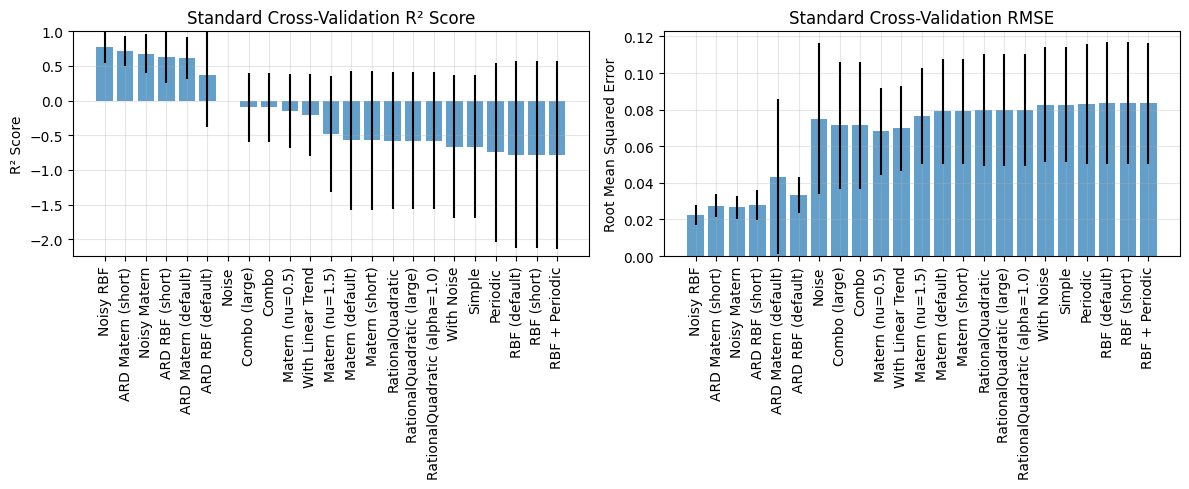


Cross-validating log kernels

Standard Kernel Cross-Validation Results:
Noisy RBF: R² = 0.7690 ± 0.3362, RMSE = 0.0194 ± 0.0067
Noisy Matern: R² = 0.7219 ± 0.3823, RMSE = 0.0218 ± 0.0070
ARD RBF (default): R² = 0.6061 ± 0.3342, RMSE = 0.0314 ± 0.0069
ARD RBF (short): R² = 0.4654 ± 0.4750, RMSE = 0.0322 ± 0.0047
ARD Matern (short): R² = 0.4596 ± 0.4465, RMSE = 0.0326 ± 0.0035
ARD Matern (default): R² = 0.3710 ± 0.6187, RMSE = 0.0469 ± 0.0401
Noise: R² = -0.1349 ± 0.1399, RMSE = 0.0755 ± 0.0410
Combo (large): R² = -0.3235 ± 0.7208, RMSE = 0.0728 ± 0.0344
Combo: R² = -0.3235 ± 0.7208, RMSE = 0.0728 ± 0.0344
Matern (nu=0.5): R² = -0.4691 ± 0.8801, RMSE = 0.0686 ± 0.0218
With Linear Trend: R² = -0.6908 ± 1.0429, RMSE = 0.0728 ± 0.0200
Matern (nu=1.5): R² = -0.8687 ± 1.1760, RMSE = 0.0772 ± 0.0233
Matern (default): R² = -0.9657 ± 1.3386, RMSE = 0.0798 ± 0.0259
Matern (short): R² = -0.9657 ± 1.3386, RMSE = 0.0798 ± 0.0259
RationalQuadratic (alpha=1.0): R² = -1.0193 ± 1.4041, RMSE = 0.0811 ± 

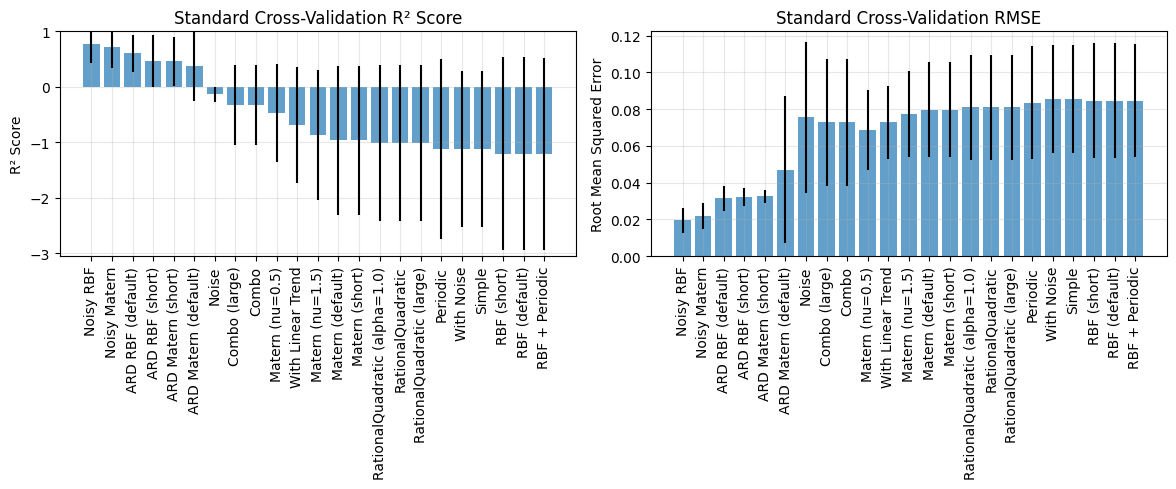


Cross-validating warped kernels

Warped Kernel Cross-Validation Results:
Warped Matern (Tanh): R² = 0.7154 ± 0.2702, RMSE = 0.0244 ± 0.0061
Warped Matern 1.5 (Kumaraswamy): R² = 0.7040 ± 0.1778, RMSE = 0.0300 ± 0.0068
Warped Matern (Kumaraswamy): R² = 0.4417 ± 0.5190, RMSE = 0.0355 ± 0.0057
Warped RBF (Kumaraswamy): R² = 0.4366 ± 0.5272, RMSE = 0.0371 ± 0.0073
Warped RQ (Kumaraswamy): R² = 0.4198 ± 0.5124, RMSE = 0.0362 ± 0.0070


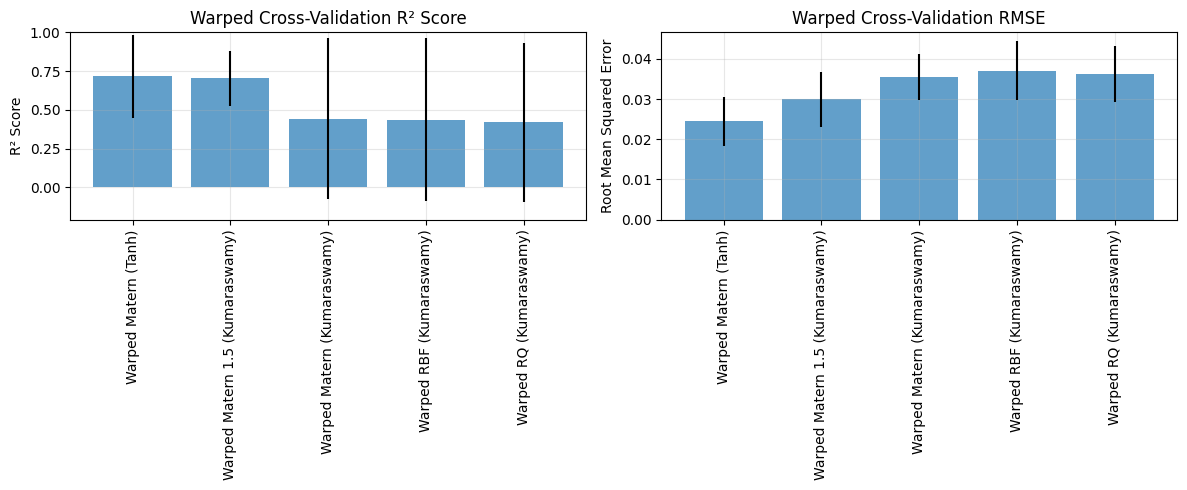


Cross-validating warped kernels with log transform

Warped Kernel Cross-Validation Results:
Warped Matern 1.5 (Kumaraswamy): R² = 0.7314 ± 0.2099, RMSE = 0.0349 ± 0.0164
Warped Matern (Kumaraswamy): R² = 0.6032 ± 0.3475, RMSE = 0.0387 ± 0.0128
Warped RQ (Kumaraswamy): R² = 0.5683 ± 0.4158, RMSE = 0.0396 ± 0.0128
Warped RBF (Kumaraswamy): R² = 0.5399 ± 0.3887, RMSE = 0.0403 ± 0.0112
Warped Matern (Tanh): R² = 0.4139 ± 0.7151, RMSE = 0.0436 ± 0.0167


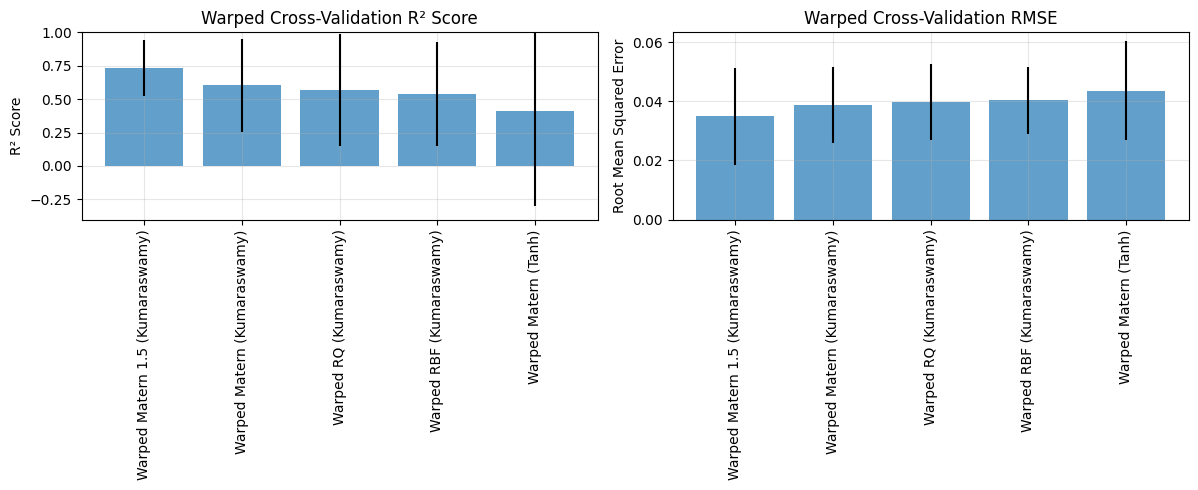

Selected best model: Noisy RBF
Using standard kernel: Noisy RBF
Initialising blend of acquisition functions:


  0%|          | 0/20 [00:00<?, ?it/s]

Methods and candidate points:
              bo_mes : 0.000000-0.999999-0.002429
                  ei : 0.000000-0.575114-0.000218
              log_ei : 0.000000-0.575114-0.000218
             ucb_0.2 : 0.000000-0.609411-0.008821
               ucb_2 : 0.000000-0.568443-0.000000
               ucb_5 : 0.000000-0.999999-0.000000
                pi_0 : 0.000000-0.615111-0.010416
            pi_0.001 : 0.000000-0.613545-0.009971
             pi_0.01 : 0.000000-0.598961-0.006041
              pi_0.1 : 0.000000-0.561100-0.000000
               bo_ei : 0.000000-0.999999-0.000000
            bo_ei_fe : 0.843561-0.602660-0.001265
           bo_log_ei : 0.000000-0.999999-0.000000
        bo_log_ei_fe : 0.654994-0.670361-0.002888
              bo_ucb : 0.999999-0.599552-0.458514
           bo_ucb_fe : 0.700015-0.546311-0.000597
               bo_pi : 0.999999-0.590758-0.440943
            bo_pi_fe : 0.474544-0.558663-0.475740
            bo_mc_ei : 0.000000-0.999999-0.000000
         bo_noisy_ei

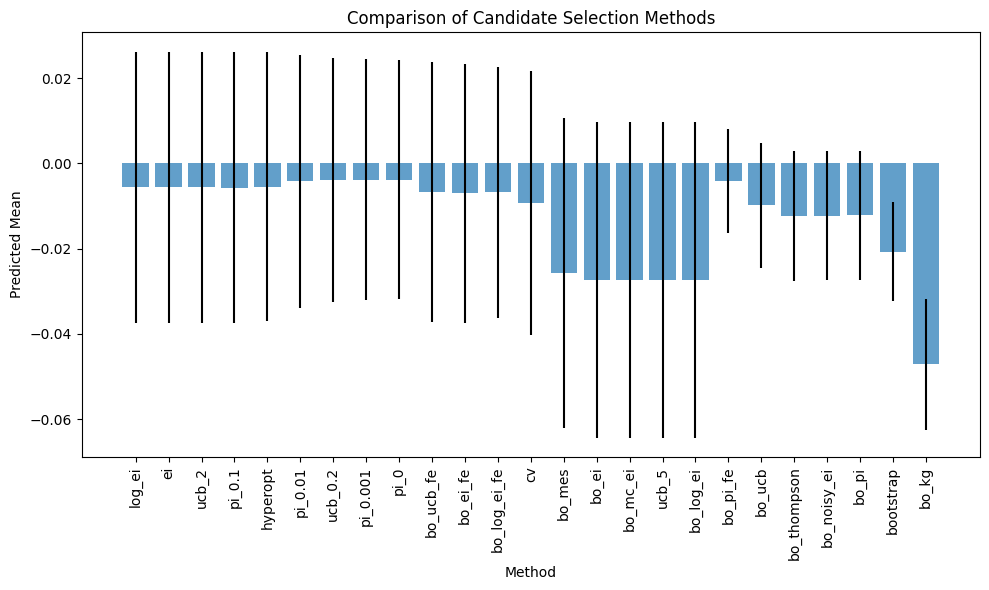


Method Comparison:
          Method  Pred. Mean  Pred. Std        EI
2         log_ei   -0.005561   0.031800  0.010867
1             ei   -0.005561   0.031800  0.010867
4          ucb_2   -0.005644   0.031889  0.010864
9         pi_0.1   -0.005671   0.031899  0.010856
22      hyperopt   -0.005436   0.031621  0.010853
8        pi_0.01   -0.004177   0.029669  0.010657
3        ucb_0.2   -0.003873   0.028688  0.010409
7       pi_0.001   -0.003811   0.028290  0.010280
6           pi_0   -0.003798   0.028138  0.010226
15     bo_ucb_fe   -0.006630   0.030515  0.009884
11      bo_ei_fe   -0.006963   0.030387  0.009689
13  bo_log_ei_fe   -0.006816   0.029559  0.009427
24            cv   -0.009369   0.031013  0.008930
0         bo_mes   -0.025747   0.036322  0.005541
10         bo_ei   -0.027293   0.037047  0.005385
18      bo_mc_ei   -0.027293   0.037047  0.005385
5          ucb_5   -0.027293   0.037047  0.005385
12     bo_log_ei   -0.027293   0.037047  0.005385
17      bo_pi_fe   -0.004131  

  0%|          | 0/49 [00:00<?, ?it/s]


Generating visualizations using BoTorch model...
  Creating partial dependence plots...
  Creating EI landscapes...
  Creating decision boundary plots...
  Creating SHAP plots...


  0%|          | 0/49 [00:00<?, ?it/s]


Generating model-independent visualizations...
  Creating t-SNE plots...
  Creating UMAP plots...


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


  Creating MDS plots...
  Creating feature importance plot...
  Creating interaction heatmap...
  Creating model fit plots...
HTML index generated: Functions/Visualisations/run_20250531_202902/index.html
All visualizations saved to: Functions/Visualisations/run_20250531_202902


In [14]:
optimizer = run_func(3,use_features=True)